# Introducción

El siguiente archivo .ipynb contiene código Python para un proyecto de clasificación de señales RF y SVM.
La clasificación se utiliza según datos obtenidos desde SleepEDF. El procesamiento inicial de los datos es el recorte de etapas Wake para lidiar con el desbalance. Por último, se prueban dos dataset, uno que incluye el canal EOG y otro que incluye EOG+EEG Fpz-Cz+EEG Cz-Oz. El procedimiento seguido es el del estudio llamado "Sleep stage classification using single-channel EOG" (Rahman et. al., 2018)


# Imports

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
import os, re, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
import h5py
import pywt
import time
from collections import defaultdict
import mne
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, confusion_matrix
import pyedflib
from tqdm import tqdm
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import sys, time, shutil, subprocess, requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
from multiprocessing import Pool
from datetime import datetime
import pickle
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
from scipy import signal, stats
from itertools import product
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from collections import defaultdict
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 1. DWT

Se extraen las componentes de 4 niveles de Discrete Wavelet Transform de la señal.

In [ ]:
"""
Convertidor de ventanas NPZ a formato DWT con ESCALADO APROPIADO para EOG
"""

# ===================== CONFIGURACIÓN =====================

# Rutas
INPUT_DIR = r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette"
OUTPUT_DIR = r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results"

# Parámetros DWT
WAVELET = 'db4'  # Daubechies-4
LEVEL = 4        # 4 niveles

# Canales permitidos
ALLOWED_CHANNELS = ['EEG_Fpz-Cz', 'EEG_Pz-Oz', 'EOG_horizontal']

# ⭐ ESCALADO PARA EOG - CRÍTICO PARA PRESERVAR INFORMACIÓN
EOG_SCALE_FACTOR = 1e6  # Convertir V a µV (microvolts)

# ===================== FUNCIONES DWT =====================

def apply_dwt(signal, wavelet='db4', level=4):
    """
    Aplica DWT de 4 niveles y retorna los 8 coeficientes (A1-A4, D1-D4)
    
    IMPORTANTE: La señal debe estar pre-escalada si es EOG
    
    Returns:
    --------
    dict con A1, A2, A3, A4, D1, D2, D3, D4
    """
    try:
        # Descomposición completa nivel 4
        coeffs_4 = pywt.wavedec(signal, wavelet, level=4)
        # coeffs_4 = [cA4, cD4, cD3, cD2, cD1]
        
        # Descomposiciones parciales para A1, A2, A3
        coeffs_3 = pywt.wavedec(signal, wavelet, level=3)
        coeffs_2 = pywt.wavedec(signal, wavelet, level=2)
        coeffs_1 = pywt.wavedec(signal, wavelet, level=1)
        
        dwt_coeffs = {
            'A1': coeffs_1[0],
            'A2': coeffs_2[0],
            'A3': coeffs_3[0],
            'A4': coeffs_4[0],
            'D1': coeffs_4[4],
            'D2': coeffs_4[3],
            'D3': coeffs_4[2],
            'D4': coeffs_4[1],
        }
        
        return dwt_coeffs
        
    except Exception as e:
        print(f"      ❌ Error en DWT: {e}")
        return None

def convert_single_npz(npz_path, output_dir, eog_scale_factor):
    """
    Convierte un archivo NPZ (ventanas crudas) a formato DWT
    
    NUEVO: Aplica escalado apropiado a señales EOG antes de DWT
    
    Parameters:
    -----------
    npz_path : Path
        Ruta al archivo NPZ con ventanas
    output_dir : Path
        Carpeta donde guardar el resultado
    eog_scale_factor : float
        Factor de escalado para señales EOG (ej: 1e6 para V→µV)
    
    Returns:
    --------
    dict: Estadísticas del procesamiento
    """
    try:
        # Cargar NPZ
        data = np.load(npz_path, allow_pickle=True)
        
        ventanas = data['ventanas']           # Shape: (n_ventanas, n_samples)
        etiquetas = data['etiquetas']         # Sleep stages
        freq_muestreo = float(data['freq_muestreo'])
        nombre_canal = str(data['nombre_canal'])
        
        n_ventanas = len(ventanas)
        
        # Validar
        if n_ventanas == 0:
            return {'success': False, 'error': 'no_windows'}
        
        # 🔥 DETERMINAR SI ES EOG
        is_eog = 'EOG' in nombre_canal or 'eog' in nombre_canal.lower()
        
        # Estadísticas de la señal ANTES del escalado
        signal_stats = {
            'mean_amplitude': float(np.mean(np.abs(ventanas))),
            'std_amplitude': float(np.std(ventanas)),
            'max_amplitude': float(np.max(np.abs(ventanas))),
            'min_amplitude': float(np.min(np.abs(ventanas)))
        }
        
        # Aplicar DWT a cada ventana (época)
        dwt_results = {
            'A1': [], 'A2': [], 'A3': [], 'A4': [],
            'D1': [], 'D2': [], 'D3': [], 'D4': []
        }
        
        failed_windows = 0
        
        for i, ventana in enumerate(ventanas):
            # 🔥 ESCALADO CONDICIONAL PARA EOG
            if is_eog:
                ventana_proc = ventana * eog_scale_factor  # V → µV
            else:
                ventana_proc = ventana  # EEG sin cambios
            
            # Aplicar DWT
            dwt_coeffs = apply_dwt(ventana_proc, wavelet=WAVELET, level=LEVEL)
            
            if dwt_coeffs is None:
                failed_windows += 1
                # Rellenar con ceros si falla
                for key in dwt_results.keys():
                    dwt_results[key].append(np.zeros(10))  # Dummy
                continue
            
            # Guardar coeficientes
            for key in ['A1', 'A2', 'A3', 'A4', 'D1', 'D2', 'D3', 'D4']:
                dwt_results[key].append(dwt_coeffs[key])
        
        # Convertir listas a arrays numpy
        for key in dwt_results.keys():
            dwt_results[key] = np.array(dwt_results[key], dtype=object)
        
        # Estadísticas de coeficientes DWT (para verificar que no se perdió info)
        dwt_stats = {}
        for key in ['A1', 'A4', 'D1', 'D4']:  # Muestra representativa
            coeffs = np.concatenate([c.flatten() for c in dwt_results[key] if len(c) > 0])
            dwt_stats[f'{key}_mean'] = float(np.mean(np.abs(coeffs)))
            dwt_stats[f'{key}_std'] = float(np.std(coeffs))
        
        # Extraer subject_id del nombre del archivo
        # Formato: SC4001E_EEG_Fpz-Cz.npz -> SC4001E
        filename = npz_path.stem
        parts = filename.split('_')
        subject_id = parts[0]  # Ej: SC4001E
        
        # Crear carpeta para el sujeto
        subject_dir = output_dir / subject_id
        subject_dir.mkdir(parents=True, exist_ok=True)
        
        # Nombre del archivo de salida
        # SC4001E_EEG_Fpz-Cz.npz -> EEG Fpz-Cz_dwt.npz
        channel_clean = nombre_canal.replace('_', ' ')  # EEG Fpz-Cz
        output_filename = f"{channel_clean}_dwt.npz"
        output_path = subject_dir / output_filename
        
        # Guardar en formato compatible con extracción de features
        np.savez_compressed(
            output_path,
            **dwt_results,
            sfreq=freq_muestreo,
            n_epochs=n_ventanas,
            etiquetas=etiquetas,
            # 🔥 METADATA IMPORTANTE
            channel_name=nombre_canal,
            is_eog=is_eog,
            eog_scale_factor=eog_scale_factor if is_eog else 1.0,
            # Estadísticas para verificación
            signal_stats=signal_stats,
            dwt_stats=dwt_stats
        )
        
        return {
            'success': True,
            'subject_id': subject_id,
            'channel': nombre_canal,
            'n_epochs': n_ventanas,
            'failed_windows': failed_windows,
            'is_eog': is_eog,
            'signal_stats': signal_stats,
            'dwt_stats': dwt_stats
        }
        
    except Exception as e:
        return {'success': False, 'error': str(e)}

# ===================== PROCESAMIENTO BATCH =====================

def convert_all_npz(input_dir, output_dir, eog_scale_factor):
    """
    Convierte todos los archivos NPZ del directorio con escalado apropiado
    """
    print("="*80)
    print("🔄 CONVERSIÓN NPZ → DWT CON ESCALADO EOG")
    print("="*80)
    
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Crear carpeta de resultados con timestamp
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    output_base = output_dir / f"dwt_numpy_{timestamp}"
    output_base.mkdir(parents=True, exist_ok=True)
    
    print(f"\n📂 Input:  {input_dir}")
    print(f"📂 Output: {output_base}")
    print(f"\n⚙️  Configuración:")
    print(f"   Wavelet: {WAVELET}")
    print(f"   Niveles: {LEVEL}")
    print(f"   EOG scale factor: {eog_scale_factor:g} (V → µV)")
    
    # Buscar archivos NPZ
    all_npz = list(input_dir.glob("*.npz"))
    
    # Filtrar por canales permitidos
    npz_files = []
    for npz_file in all_npz:
        # Extraer nombre del canal del filename
        # SC4001E_EEG_Fpz-Cz.npz -> EEG_Fpz-Cz
        parts = npz_file.stem.split('_', 1)
        if len(parts) < 2:
            continue
        channel_part = parts[1]  # EEG_Fpz-Cz
        
        if channel_part in ALLOWED_CHANNELS:
            npz_files.append(npz_file)
    
    print(f"\n📊 Archivos NPZ encontrados: {len(all_npz)}")
    print(f"📊 Archivos a procesar (canales permitidos): {len(npz_files)}")
    
    if not npz_files:
        print("\n❌ No hay archivos NPZ con canales permitidos")
        print(f"   Canales esperados: {ALLOWED_CHANNELS}")
        return None
    
    # Agrupar por sujeto
    subjects = {}
    for npz_file in npz_files:
        subject_id = npz_file.stem.split('_')[0]
        if subject_id not in subjects:
            subjects[subject_id] = []
        subjects[subject_id].append(npz_file)
    
    print(f"📊 Sujetos únicos: {len(subjects)}")
    print(f"\n🚀 Iniciando conversión...\n")
    
    # Estadísticas de procesamiento
    results = []
    eog_results = []
    eeg_results = []
    
    # Procesar
    for npz_file in tqdm(npz_files, desc="Convirtiendo", unit="archivo"):
        result = convert_single_npz(npz_file, output_base, eog_scale_factor)
        
        if result['success']:
            results.append(result)
            
            # Separar estadísticas por tipo
            if result['is_eog']:
                eog_results.append(result)
            else:
                eeg_results.append(result)
    
    # ===================== RESUMEN =====================
    print(f"\n{'='*80}")
    print("✅ CONVERSIÓN COMPLETADA")
    print(f"{'='*80}")
    
    successful = len(results)
    failed = len(npz_files) - successful
    
    print(f"\n📊 Resultados generales:")
    print(f"   ✓ Exitosos: {successful}")
    print(f"   ✗ Fallidos:  {failed}")
    
    # Estadísticas EEG
    if eeg_results:
        print(f"\n📊 Canales EEG ({len(eeg_results)} archivos):")
        eeg_amp_mean = np.mean([r['signal_stats']['mean_amplitude'] for r in eeg_results])
        eeg_amp_std = np.mean([r['signal_stats']['std_amplitude'] for r in eeg_results])
        print(f"   Amplitud media: {eeg_amp_mean:.2e}")
        print(f"   Desviación estándar: {eeg_amp_std:.2e}")
        
        # Coeficientes DWT ejemplo
        eeg_d1_mean = np.mean([r['dwt_stats']['D1_mean'] for r in eeg_results])
        print(f"   Coeficiente D1 medio: {eeg_d1_mean:.2e}")
    
    # Estadísticas EOG
    if eog_results:
        print(f"\n📊 Canales EOG ({len(eog_results)} archivos):")
        eog_amp_mean = np.mean([r['signal_stats']['mean_amplitude'] for r in eog_results])
        eog_amp_std = np.mean([r['signal_stats']['std_amplitude'] for r in eog_results])
        print(f"   Amplitud media ORIGINAL: {eog_amp_mean:.2e}")
        print(f"   Amplitud media ESCALADA: {eog_amp_mean * eog_scale_factor:.2e}")
        print(f"   Desviación estándar: {eog_amp_std:.2e}")
        
        # Coeficientes DWT
        eog_d1_mean = np.mean([r['dwt_stats']['D1_mean'] for r in eog_results])
        print(f"   Coeficiente D1 medio: {eog_d1_mean:.2e}")
        
        print(f"\n   ✅ Factor de escalado: {eog_scale_factor:g}x aplicado")
        print(f"   💡 Esto preserva la información de baja amplitud")
    
    # Verificar estructura
    print(f"\n🔍 Verificando estructura de salida...")
    subject_dirs = sorted([d for d in output_base.iterdir() if d.is_dir()])
    print(f"   Carpetas de sujetos creadas: {len(subject_dirs)}")
    
    if subject_dirs:
        # Mostrar ejemplo
        example_subject = subject_dirs[0]
        example_files = list(example_subject.glob("*.npz"))
        print(f"\n   Ejemplo - {example_subject.name}:")
        for f in sorted(example_files):
            size_kb = f.stat().st_size / 1024
            print(f"      - {f.name} ({size_kb:.1f} KB)")
    
    print(f"\n📂 Archivos DWT guardados en:")
    print(f"   {output_base}")
    
    print(f"\n💡 Siguiente paso:")
    print(f"   Usar en script de extracción de features:")
    print(f"   NUMPY_BASE_DIR = r'{output_base}'")
    
    return output_base

# ===================== VERIFICACIÓN =====================

def verify_dwt_format(dwt_file):
    """Verifica que un archivo DWT tenga el formato correcto y muestra estadísticas"""
    try:
        data = np.load(dwt_file, allow_pickle=True)
        
        print(f"\n🔍 Verificando: {dwt_file.name}")
        print(f"   Keys disponibles: {list(data.keys())}")
        
        required_keys = ['A1', 'A2', 'A3', 'A4', 'D1', 'D2', 'D3', 'D4', 'sfreq', 'n_epochs']
        missing = [k for k in required_keys if k not in data.keys()]
        
        if missing:
            print(f"   ❌ Faltan keys: {missing}")
            return False
        
        print(f"   ✓ Todas las keys requeridas presentes")
        print(f"\n   📊 Información básica:")
        print(f"      n_epochs: {data['n_epochs']}")
        print(f"      sfreq: {data['sfreq']} Hz")
        print(f"      channel_name: {data.get('channel_name', 'N/A')}")
        print(f"      is_eog: {data.get('is_eog', 'N/A')}")
        
        if data.get('is_eog', False):
            scale = data.get('eog_scale_factor', 1.0)
            print(f"      eog_scale_factor: {scale:g}")
        
        print(f"\n   📊 Shapes de coeficientes DWT:")
        for key in ['A1', 'A2', 'A3', 'A4', 'D1', 'D2', 'D3', 'D4']:
            print(f"      {key}: {data[key].shape}")
        
        # Estadísticas de amplitud
        if 'signal_stats' in data:
            stats = data['signal_stats'].item()
            print(f"\n   📊 Estadísticas de señal original:")
            print(f"      Mean amplitude: {stats['mean_amplitude']:.2e}")
            print(f"      Std amplitude: {stats['std_amplitude']:.2e}")
            print(f"      Max amplitude: {stats['max_amplitude']:.2e}")
        
        if 'dwt_stats' in data:
            dwt_stats = data['dwt_stats'].item()
            print(f"\n   📊 Estadísticas de coeficientes DWT:")
            for key, val in dwt_stats.items():
                print(f"      {key}: {val:.2e}")
        
        # Etiquetas
        if 'etiquetas' in data:
            etiquetas = data['etiquetas']
            unique, counts = np.unique(etiquetas, return_counts=True)
            print(f"\n   📊 Distribución de etiquetas de sueño:")
            stage_names = {'W': 'Wake', '1': 'N1', '2': 'N2', '3': 'N3', 'R': 'REM'}
            for label, count in zip(unique, counts):
                label_str = str(label)
                name = stage_names.get(label_str, f'Stage {label_str}')
                pct = (count / len(etiquetas)) * 100
                print(f"      {name:8} | {count:4} ({pct:5.1f}%)")
        
        return True
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        return False

# ===================== MAIN =====================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🎯 CONVERSIÓN DWT CON SOLUCIÓN DE ESCALADO EOG")
    print("="*80)
    print("\n💡 Problema resuelto:")
    print("   ❌ EOG tiene amplitudes ~100x menores que EEG")
    print("   ❌ Sin escalado: se pierde información en coeficientes DWT")
    print("   ✅ Con escalado: EOG × 1e6 → información preservada")
    print("="*80 + "\n")
    
    # Convertir todos los NPZ
    output_base = convert_all_npz(INPUT_DIR, OUTPUT_DIR, EOG_SCALE_FACTOR)
    
    if output_base:
        # Verificar archivos de ejemplo
        print(f"\n{'='*80}")
        print("🔍 VERIFICACIÓN DE ARCHIVOS")
        print(f"{'='*80}")
        
        subject_dirs = sorted([d for d in output_base.iterdir() if d.is_dir()])
        
        if subject_dirs:
            example_files = list(subject_dirs[0].glob("*.npz"))
            
            # Verificar un EEG y un EOG si están disponibles
            eeg_file = None
            eog_file = None
            
            for f in example_files:
                if 'EEG' in f.name and eeg_file is None:
                    eeg_file = f
                elif 'EOG' in f.name and eog_file is None:
                    eog_file = f
            
            if eeg_file:
                verify_dwt_format(eeg_file)
            
            if eog_file:
                verify_dwt_format(eog_file)
        
        print(f"\n{'='*80}")
        print("✅ LISTO PARA EXTRACCIÓN DE FEATURES")
        print(f"{'='*80}")
        print(f"\nRuta para el siguiente script:")
        print(f"NUMPY_BASE_DIR = r'{output_base}'")


🎯 CONVERSIÓN DWT CON SOLUCIÓN DE ESCALADO EOG

💡 Problema resuelto:
   ❌ EOG tiene amplitudes ~100x menores que EEG
   ❌ Sin escalado: se pierde información en coeficientes DWT
   ✅ Con escalado: EOG × 1e6 → información preservada

🔄 CONVERSIÓN NPZ → DWT CON ESCALADO EOG

📂 Input:  C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette
📂 Output: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results\dwt_numpy_20251206_113008

⚙️  Configuración:
   Wavelet: db4
   Niveles: 4
   EOG scale factor: 1e+06 (V → µV)

📊 Archivos NPZ encontrados: 459
📊 Archivos a procesar (canales permitidos): 459
📊 Sujetos únicos: 153

🚀 Iniciando conversión...



Convirtiendo: 100%|██████████| 459/459 [44:34<00:00,  5.83s/archivo]  



✅ CONVERSIÓN COMPLETADA

📊 Resultados generales:
   ✓ Exitosos: 459
   ✗ Fallidos:  0

📊 Canales EEG (306 archivos):
   Amplitud media: 1.00e-05
   Desviación estándar: 1.44e-05
   Coeficiente D1 medio: 2.82e-06

📊 Canales EOG (153 archivos):
   Amplitud media ORIGINAL: 2.21e-05
   Amplitud media ESCALADA: 2.21e+01
   Desviación estándar: 3.51e-05
   Coeficiente D1 medio: 3.30e+00

   ✅ Factor de escalado: 1e+06x aplicado
   💡 Esto preserva la información de baja amplitud

🔍 Verificando estructura de salida...
   Carpetas de sujetos creadas: 153

   Ejemplo - SC4001E:
      - EEG Fpz-Cz_dwt.npz (18515.8 KB)
      - EEG Pz-Oz_dwt.npz (18430.8 KB)
      - EOG horizontal_dwt.npz (18666.9 KB)

📂 Archivos DWT guardados en:
   C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results\dwt_numpy_20251206_113008

💡 Siguiente paso:
   Usar en script de extracción de features:
   NUMPY_BASE_DIR = r'C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-c

## Visualización

Verificar formas de las ondas wavelet de las frecuencias extraidas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# ===================== RUTAS =====================

DWT_BASE_DIR = Path(
    r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results\dwt_numpy_20251206_113008"
)
OUTPUT_DIR = Path(
    r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT"
)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ===================== PARÁMETROS =====================

N_EXAMPLES = 5             # cuántas épocas quieres graficar
SUBBANDS_TO_PLOT = ["A4", "D3", "D1"]  # 3 bandas relevantes (baja, media, alta)

# ===================== BUSCAR UN ARCHIVO EOG =====================

# Busca en las carpetas de sujetos un archivo EOG horizontal_dwt.npz
eog_files = list(DWT_BASE_DIR.glob("*/EOG horizontal_dwt.npz"))

if not eog_files:
    raise FileNotFoundError("No se encontró ningún 'EOG horizontal_dwt.npz' en la ruta base.")

# Aquí tomo el primero, pero podrías iterar sobre varios sujetos si quieres
eog_path = eog_files[0]
print("Usando archivo EOG:", eog_path)

data = np.load(eog_path, allow_pickle=True)

A1 = data["A1"]
A2 = data["A2"]
A3 = data["A3"]
A4 = data["A4"]
D1 = data["D1"]
D2 = data["D2"]
D3 = data["D3"]
D4 = data["D4"]

sfreq = float(data["sfreq"])
n_epochs = int(data["n_epochs"])
etiquetas = data["etiquetas"]

print(f"n_epochs: {n_epochs}, sfreq: {sfreq} Hz")
print("Etiquetas únicas:", np.unique(etiquetas))

# Map opcional de etiquetas a nombre de etapa (ajústalo si tus códigos son distintos)
stage_map = {
    "W": "Wake",
    "1": "N1",
    "2": "N2",
    "3": "N3",
    "R": "REM"
}

# ===================== FUNCIÓN DE PLOT =====================

def plot_dwt_example(epoch_idx):
    """
    Grafica 3 subbandas DWT (A4, D3, D1) para una época del EOG.
    """
    # Extraer coeficientes para esa época
    coeffs = {
        "A1": A1[epoch_idx],
        "A2": A2[epoch_idx],
        "A3": A3[epoch_idx],
        "A4": A4[epoch_idx],
        "D1": D1[epoch_idx],
        "D2": D2[epoch_idx],
        "D3": D3[epoch_idx],
        "D4": D4[epoch_idx],
    }

    label_raw = etiquetas[epoch_idx]
    label_str = str(label_raw)
    stage_name = stage_map.get(label_str, label_str)

    fig, axes = plt.subplots(len(SUBBANDS_TO_PLOT), 1, figsize=(10, 6), sharex=False)
    if len(SUBBANDS_TO_PLOT) == 1:
        axes = [axes]

    fig.suptitle(f"EOG horizontal – época {epoch_idx} – etapa {stage_name} ({label_str})", fontsize=14)

    for ax, band in zip(axes, SUBBANDS_TO_PLOT):
        sig = coeffs[band]
        t = np.arange(len(sig)) / sfreq  # eje "tiempo" aproximado en segundos

        ax.plot(t, sig)
        ax.set_ylabel(band)
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Tiempo aproximado [s]")

    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Guardar figura
    out_name = f"EOG_DWT_epoch{epoch_idx}_stage_{label_str}.png"
    out_path = OUTPUT_DIR / out_name
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

    print(f"   ✓ Guardado: {out_path}")

# ===================== GENERAR EJEMPLOS =====================

print("\nGenerando ejemplos de DWT para EOG...\n")

# Elegimos índices de épocas (aleatorios)
if N_EXAMPLES > n_epochs:
    N_EXAMPLES = n_epochs

epochs_to_plot = random.sample(range(n_epochs), N_EXAMPLES)

for idx in epochs_to_plot:
    plot_dwt_example(idx)

print("\n✅ Listo. Revisa las figuras en:")
print("   ", OUTPUT_DIR)


Usando archivo EOG: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results\dwt_numpy_20251206_113008\SC4001E\EOG horizontal_dwt.npz
n_epochs: 241, sfreq: 100.0 Hz
Etiquetas únicas: ['1' '2' '3' 'R' 'W']

Generando ejemplos de DWT para EOG...

   ✓ Guardado: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT\EOG_DWT_epoch239_stage_1.png
   ✓ Guardado: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT\EOG_DWT_epoch127_stage_2.png
   ✓ Guardado: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT\EOG_DWT_epoch222_stage_R.png
   ✓ Guardado: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT\EOG_DWT_epoch26_stage_2.png
   ✓ Guardado: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT\EOG_DWT_epoch99_stage_3.png

✅ Listo. Revisa las figuras en:
    C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\Resultados\DWT


# 2. Extracción de features (8 subbandas x 15 features = 120 features por época y por canal (3) )

A partir de las Wavelet generadas, se extraen features estadísticas y de entropía.

In [4]:
"""
Extracción de Features según Paper EOG
15 features × 8 subbandas DWT = 120 features por canal
Optimizado para velocidad manteniendo precisión
"""

import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import warnings
import gc
import time

warnings.filterwarnings('ignore')

# ===================== CONFIGURACIÓN =====================

NUMPY_BASE_DIR = r'C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\sleep-cassette\dwt_results\dwt_numpy_20251204_011812'
OUTPUT_DIR = r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\features_batch"

ALLOWED_CHANNELS = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']

LABEL_MAPPING = {
    'W': 0, '1': 1, '2': 2, '3': 3, 'R': 4,
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4
}

# ===================== FEATURES DEL PAPER =====================

def compute_spectral_entropies(signal_data):
    """
    Calcula las 5 spectral entropies del paper:
    Shannon, Log-energy, Sure, Norm, Threshold
    """
    # Calcular PSD usando FFT
    fft_vals = np.fft.rfft(signal_data)
    psd = np.abs(fft_vals) ** 2
    
    # Normalizar para obtener probabilidades
    psd_sum = psd.sum()
    if psd_sum < 1e-15:
        return {
            'shannon_ent': 0.0,
            'log_energy_ent': 0.0,
            'sure_ent': 0.0,
            'norm_ent': 0.0,
            'threshold_ent': 0.0
        }
    
    p = psd / psd_sum
    p = p[p > 1e-15]  # Evitar log(0)
    
    # 1. Shannon Entropy
    shannon_ent = float(-np.sum(p * np.log2(p + 1e-15)))
    
    # 2. Log-energy Entropy
    log_energy_ent = float(-np.sum(np.log2(p + 1e-15)))
    
    # 3. Sure Entropy (threshold adaptatitvo)
    n = len(p)
    t_squared = 2 * np.log(n)
    sure_ent = float(n - 2 * np.sum(p <= t_squared) + np.sum(np.minimum(p**2, t_squared)))
    
    # 4. Norm Entropy (l^k norm con k=1)
    norm_ent = float(-np.sum(p))
    
    # 5. Threshold Entropy (conteo sobre umbral)
    threshold = np.median(p)
    threshold_ent = float(np.sum(p > threshold))
    
    return {
        'shannon_ent': shannon_ent,
        'log_energy_ent': log_energy_ent,
        'sure_ent': sure_ent,
        'norm_ent': norm_ent,
        'threshold_ent': threshold_ent
    }


def compute_moment_features(signal_data):
    """
    Calcula las 3 moment-based measures:
    Variance, Skewness, Kurtosis
    """
    mean_val = float(signal_data.mean())
    
    # Variance
    variance = float(signal_data.var())
    
    # Skewness y Kurtosis usando scipy
    skewness = float(stats.skew(signal_data))
    kurtosis = float(stats.kurtosis(signal_data))
    
    return {
        'variance': variance,
        'skewness': skewness,
        'kurtosis': kurtosis
    }


def compute_rcmde(signal_data, m=3, c=6, d=1, max_scale=4):
    """
    Calcula RCMDE (Refined Composite Multiscale Dispersion Entropy)
    para escalas 1-4 según el paper
    
    Optimizado: usa vectorización donde sea posible
    """
    rcmde_features = {}
    
    L = len(signal_data)
    
    # Normalización inicial con CDF
    mu = signal_data.mean()
    sigma = signal_data.std()
    
    if sigma < 1e-15:
        for scale in range(1, max_scale + 1):
            rcmde_features[f'rcmde_scale{scale}'] = 0.0
        return rcmde_features
    
    for tau in range(1, max_scale + 1):
        try:
            # Coarse-graining
            N = L // tau
            if N < 10:
                rcmde_features[f'rcmde_scale{tau}'] = 0.0
                continue
            
            a = np.array([signal_data[j*tau:(j+1)*tau].mean() for j in range(N)])
            
            # Normalización con CDF gaussiana
            from scipy.stats import norm
            b = norm.cdf(a, loc=mu, scale=sigma)
            
            # Mapeo a clases [1, c]
            z = np.round(c * b + 0.5).astype(int)
            z = np.clip(z, 1, c)
            
            # Crear embedding vectors
            n_vectors = N - (m - 1) * d
            if n_vectors < 1:
                rcmde_features[f'rcmde_scale{tau}'] = 0.0
                continue
            
            # Vectorización del embedding
            indices = np.arange(n_vectors)[:, None] + np.arange(m)[None, :] * d
            embedded = z[indices]
            
            # Convertir a patrones de dispersión (strings para hashing rápido)
            patterns = [''.join(map(str, row)) for row in embedded]
            
            # Contar frecuencias
            unique, counts = np.unique(patterns, return_counts=True)
            probabilities = counts / n_vectors
            
            # Calcular entropía
            entropy = float(-np.sum(probabilities * np.log(probabilities + 1e-15)))
            
            rcmde_features[f'rcmde_scale{tau}'] = entropy
            
        except Exception as e:
            rcmde_features[f'rcmde_scale{tau}'] = 0.0
    
    return rcmde_features


def compute_ar_coefficients(signal_data, order=3):
    """
    Calcula coeficientes AR de orden 3 (paper usa p=4 pero reporta 3 coefs)
    Usa método Yule-Walker optimizado
    """
    # Centrar señal
    centered = signal_data - signal_data.mean()
    
    # Autocorrelación usando numpy (más rápido que manual)
    try:
        # Calcular autocorrelación necesaria
        r = np.correlate(centered, centered, mode='full')
        r = r[len(r)//2:len(r)//2 + order + 1]
        
        # Normalizar
        r = r / (r[0] + 1e-15)
        
        # Construir matriz de Toeplitz para Yule-Walker
        R = np.array([
            [r[0], r[1], r[2]],
            [r[1], r[0], r[1]],
            [r[2], r[1], r[0]]
        ])
        
        # Resolver sistema
        ar = np.linalg.solve(R, r[1:4])
        
        return {
            'ar1': float(ar[0]),
            'ar2': float(ar[1]),
            'ar3': float(ar[2])
        }
        
    except:
        return {
            'ar1': 0.0,
            'ar2': 0.0,
            'ar3': 0.0
        }


def compute_all_paper_features(signal_data):
    """
    Calcula TODOS los 15 features del paper para una subbanda DWT
    """
    # Validación
    if not isinstance(signal_data, np.ndarray):
        return None
    
    if signal_data.size == 0 or len(signal_data) < 10:
        return None
    
    signal_data = signal_data.flatten()
    
    # Verificar que no sean todos iguales
    if np.all(signal_data == signal_data[0]):
        return None
    
    # Verificar varianza mínima
    if signal_data.std() < 1e-15:
        return None
    
    features = {}
    
    try:
        # 1. Spectral Entropies (5 features)
        spectral = compute_spectral_entropies(signal_data)
        features.update(spectral)
        
        # 2. Moment-based (3 features)
        moments = compute_moment_features(signal_data)
        features.update(moments)
        
        # 3. RCMDE scales 1-4 (4 features)
        rcmde = compute_rcmde(signal_data, m=3, c=6, d=1, max_scale=4)
        features.update(rcmde)
        
        # 4. AR Coefficients (3 features)
        ar = compute_ar_coefficients(signal_data, order=3)
        features.update(ar)
        
        return features
        
    except Exception as e:
        return None


def process_epoch_paper(dwt_coeffs, channel_name):
    """
    Procesa UNA época - calcula 15 features × 8 subbandas = 120 features
    """
    all_features = {}
    valid_subbands = 0
    
    for subband in ['D1', 'D2', 'D3', 'D4', 'A1', 'A2', 'A3', 'A4']:
        subband_data = dwt_coeffs.get(subband, None)
        
        if subband_data is None:
            continue
        
        # Conversión de arrays object
        if not isinstance(subband_data, np.ndarray):
            try:
                subband_data = np.array(subband_data, dtype=np.float64)
            except:
                continue
        
        subband_data = subband_data.flatten()
        
        if subband_data.size == 0 or len(subband_data) < 10:
            continue
        
        if np.all(subband_data == subband_data[0]):
            continue
        
        prefix = f"{channel_name}_{subband}_"
        
        # Calcular 15 features del paper
        feat = compute_all_paper_features(subband_data)
        
        if feat is None:
            continue
        
        # Añadir con prefijo
        for key, value in feat.items():
            all_features[prefix + key] = value
        
        valid_subbands += 1
    
    if valid_subbands == 0:
        return None
    
    return all_features


# ===================== PROCESAMIENTO SECUENCIAL =====================

def extract_features_paper(numpy_base_dir, output_dir, label_mapping, save_every=25):
    """
    Extracción de features según paper:
    - 5 Spectral Entropies
    - 3 Moment-based
    - 4 RCMDE scales
    - 3 AR coefficients
    = 15 features × 8 subbandas = 120 por canal
    """
    print("="*80)
    print("EXTRACCIÓN DE FEATURES - SEGÚN PAPER EOG")
    print("="*80)
    
    numpy_base_dir = Path(numpy_base_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    subject_dirs = sorted([d for d in numpy_base_dir.iterdir() if d.is_dir()])
    n_subjects = len(subject_dirs)
    
    print(f"\n📊 Configuración:")
    print(f"   - Sujetos: {n_subjects}")
    print(f"   - Canales: {', '.join(ALLOWED_CHANNELS)}")
    
    print(f"\n⚡ Features por subbanda (15 × 8 = 120 por canal):")
    print(f"   1. Spectral Entropies (5): Shannon, Log-energy, Sure, Norm, Threshold")
    print(f"   2. Moment-based (3): Variance, Skewness, Kurtosis")
    print(f"   3. RCMDE (4): Scales 1-4")
    print(f"   4. AR Coefficients (3): ar1, ar2, ar3")
    
    print(f"\n🚀 Procesando...\n")
    
    all_features = []
    start_time = time.time()
    epochs_processed = 0
    
    debug_stats = {
        'valid': 0,
        'skipped': 0,
        'by_channel': {}
    }
    
    # Procesar cada sujeto
    for idx, subject_dir in enumerate(subject_dirs, 1):
        subject_id = subject_dir.name
        subject_start = time.time()
        
        npz_files = [f for f in subject_dir.glob("*.npz") 
                     if f.stem.replace("_dwt", "") in ALLOWED_CHANNELS]
        
        if not npz_files:
            print(f"[{idx:3d}/{n_subjects}] ⚠️ {subject_id:12} | Sin archivos NPZ")
            continue
        
        subject_epochs = 0
        subject_skipped = 0
        
        for npz_path in npz_files:
            channel_name = npz_path.stem.replace("_dwt", "")
            
            if channel_name not in debug_stats['by_channel']:
                debug_stats['by_channel'][channel_name] = 0
            
            try:
                with np.load(npz_path, allow_pickle=True) as data:
                    
                    required = ['sfreq', 'n_epochs', 'D1', 'D2', 'D3', 'D4', 'A1', 'A2', 'A3', 'A4']
                    if not all(k in data for k in required):
                        continue
                    
                    sfreq = float(data['sfreq'])
                    n_epochs = int(data['n_epochs'])
                    ch_type = 'eog' if 'EOG' in channel_name else 'eeg'
                    etiquetas = data.get('etiquetas', None)
                    
                    is_eog = data.get('is_eog', 'EOG' in channel_name)
                    eog_scale = data.get('eog_scale_factor', 1.0)
                    
                    # Cargar arrays DWT
                    dwt_arrays = {}
                    for k in ['D1', 'D2', 'D3', 'D4', 'A1', 'A2', 'A3', 'A4']:
                        dwt_arrays[k] = data[k]
                    
                    # Determinar número de épocas
                    n_valid = n_epochs
                    if isinstance(dwt_arrays['D1'], np.ndarray):
                        n_valid = min(n_epochs, len(dwt_arrays['D1']))
                    
                    # Procesar cada época
                    for epoch_idx in range(n_valid):
                        try:
                            dwt_coeffs = {}
                            has_valid_data = False
                            
                            for k in dwt_arrays.keys():
                                try:
                                    arr = dwt_arrays[k]
                                    
                                    if not isinstance(arr, np.ndarray):
                                        continue
                                    
                                    # Extraer coeficiente
                                    if arr.ndim == 2:
                                        coeff = arr[epoch_idx, :]
                                    elif arr.ndim == 1:
                                        coeff = arr[epoch_idx]
                                    else:
                                        continue
                                    
                                    if not isinstance(coeff, np.ndarray):
                                        coeff = np.array(coeff, dtype=np.float64)
                                    
                                    coeff = coeff.flatten()
                                    if coeff.dtype == object:
                                        coeff = np.array(coeff, dtype=np.float64)
                                    
                                    if coeff.size > 0:
                                        dwt_coeffs[k] = coeff
                                        if not np.all(coeff == coeff[0]):
                                            has_valid_data = True
                                
                                except:
                                    continue
                            
                            if not has_valid_data:
                                subject_skipped += 1
                                continue
                            
                            # Calcular features del paper
                            features = process_epoch_paper(dwt_coeffs, channel_name)
                            
                            if features is None:
                                subject_skipped += 1
                                continue
                            
                            # Metadatos
                            features['subject_id'] = subject_id
                            features['channel_name'] = channel_name
                            features['channel_type'] = ch_type
                            features['epoch_num'] = epoch_idx
                            features['sfreq'] = sfreq
                            features['is_eog'] = is_eog
                            features['eog_scale_factor'] = eog_scale
                            
                            # Etiqueta
                            if etiquetas is not None and epoch_idx < len(etiquetas):
                                label_raw = etiquetas[epoch_idx]
                                label_str = str(label_raw) if not isinstance(label_raw, str) else label_raw
                                features['sleep_stage'] = label_mapping.get(label_str, -1)
                            else:
                                features['sleep_stage'] = -1
                            
                            all_features.append(features)
                            subject_epochs += 1
                            debug_stats['valid'] += 1
                            debug_stats['by_channel'][channel_name] += 1
                            
                        except:
                            subject_skipped += 1
                            continue
                
            except:
                continue
        
        epochs_processed += subject_epochs
        debug_stats['skipped'] += subject_skipped
        
        # Progreso
        elapsed = time.time() - start_time
        subject_time = time.time() - subject_start
        rate = idx / elapsed if elapsed > 0 else 1
        eta_mins = ((n_subjects - idx) / rate) / 60 if rate > 0 else 0
        
        status = "✓" if subject_epochs > 0 else "⚠️"
        skip_msg = f" (skip: {subject_skipped})" if subject_skipped > 0 else ""
        
        print(f"[{idx:3d}/{n_subjects}] {status} {subject_id:12} | "
              f"{subject_epochs:4d} épocas{skip_msg} | "
              f"{subject_time:5.2f}s | "
              f"Total: {epochs_processed:6,} | "
              f"ETA: {eta_mins:5.1f}min")
        
        # Checkpoint
        if idx % save_every == 0 and all_features:
            df_temp = pd.DataFrame(all_features)
            checkpoint_path = output_dir / f"checkpoint_{idx}.pkl"
            df_temp.to_pickle(checkpoint_path)
            print(f"           💾 Checkpoint: {len(df_temp):,} épocas\n")
        
        if idx % 50 == 0:
            gc.collect()
    
    print(f"\n{'='*80}")
    print("PROCESAMIENTO COMPLETADO")
    print(f"{'='*80}")
    
    print(f"\n📊 Resumen:")
    print(f"   - Épocas válidas: {debug_stats['valid']:,}")
    print(f"   - Épocas omitidas: {debug_stats['skipped']:,}")
    
    if debug_stats['by_channel']:
        print(f"\n📊 Épocas por canal:")
        for channel, count in sorted(debug_stats['by_channel'].items()):
            print(f"   - {channel}: {count:,}")
    
    if not all_features:
        print("\n❌ No se extrajeron features válidas")
        return pd.DataFrame()
    
    # Crear DataFrame
    df_features = pd.DataFrame(all_features)
    
    # Ordenar columnas
    metadata_cols = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                     'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']
    feature_cols = [c for c in df_features.columns if c not in metadata_cols]
    df_features = df_features[metadata_cols + feature_cols]
    
    # Estadísticas
    elapsed = time.time() - start_time
    print(f"\n✓ Tiempo total: {elapsed/60:.1f} min")
    print(f"✓ Velocidad: {len(df_features)/elapsed:.1f} épocas/seg")
    
    print(f"\n📊 DataFrame Final:")
    print(f"  - Total épocas: {len(df_features):,}")
    print(f"  - Total features: {len(feature_cols)}")
    print(f"  - Features esperados: 15 × 8 × {df_features['channel_name'].nunique()} canales")
    print(f"  - Sujetos únicos: {df_features['subject_id'].nunique()}")
    
    # Distribución de sleep stages
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM', -1: 'Unknown'}
    stage_counts = df_features['sleep_stage'].value_counts().sort_index()
    total = len(df_features)
    
    print(f"\n📊 Distribución de sleep stages:")
    for stage, count in stage_counts.items():
        pct = (count / total) * 100
        name = stage_names.get(stage, f'Stage {stage}')
        bar = '█' * int(pct / 2)
        print(f"   {name:8} | {bar} {count:7,} ({pct:5.1f}%)")
    
    return df_features


def clean_and_save(df_features, output_dir):
    """Limpia y guarda el DataFrame final"""
    print(f"\n{'='*80}")
    print("LIMPIEZA Y GUARDADO")
    print(f"{'='*80}")
    
    n_before = len(df_features)
    df_clean = df_features[df_features['sleep_stage'] != -1].copy()
    n_removed = n_before - len(df_clean)
    
    print(f"\n📊 Limpieza:")
    print(f"   Antes: {n_before:,}")
    print(f"   Eliminadas (sin etiqueta): {n_removed:,}")
    print(f"   Finales: {len(df_clean):,}")
    
    output_dir = Path(output_dir)
    
    # Guardar Parquet
    parquet_path = output_dir / "features_paper_eog.parquet"
    df_clean.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)
    size_mb = parquet_path.stat().st_size / (1024**2)
    print(f"\n✓ Parquet: {parquet_path.name} ({size_mb:.1f} MB)")
    
    # Guardar Pickle
    pkl_path = output_dir / "features_paper_eog.pkl"
    df_clean.to_pickle(pkl_path, compression='gzip')
    print(f"✓ Pickle: {pkl_path.name}")
    
    # Info
    info_path = output_dir / "features_paper_info.txt"
    with open(info_path, 'w', encoding='utf-8') as f:
        f.write("FEATURES SEGÚN PAPER EOG\n")
        f.write("="*80 + "\n\n")
        
        metadata_cols = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                         'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']
        feature_cols = [c for c in df_clean.columns if c not in metadata_cols]
        
        f.write(f"Total épocas: {len(df_clean):,}\n")
        f.write(f"Total features: {len(feature_cols)}\n")
        f.write(f"Sujetos únicos: {df_clean['subject_id'].nunique()}\n")
        f.write(f"Canales: {', '.join(df_clean['channel_name'].unique())}\n\n")
        
        f.write("FEATURES POR SUBBANDA (15):\n")
        f.write("  1. Spectral Entropies (5): shannon_ent, log_energy_ent, sure_ent, norm_ent, threshold_ent\n")
        f.write("  2. Moment-based (3): variance, skewness, kurtosis\n")
        f.write("  3. RCMDE (4): rcmde_scale1, rcmde_scale2, rcmde_scale3, rcmde_scale4\n")
        f.write("  4. AR Coefficients (3): ar1, ar2, ar3\n\n")
        
        f.write(f"Sleep stages:\n")
        stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
        for stage, name in stage_names.items():
            count = (df_clean['sleep_stage'] == stage).sum()
            pct = (count / len(df_clean)) * 100
            f.write(f"  {name:8} ({stage}): {count:7,} ({pct:5.1f}%)\n")
    
    print(f"✓ Info: {info_path.name}")
    
    return df_clean


# ===================== MAIN =====================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("EXTRACCIÓN DE FEATURES - SEGÚN PAPER EOG")
    print("="*80)
    print("\n📄 Features del Paper (Rahman et al., 2018):")
    print("   • 5 Spectral Entropies")
    print("   • 3 Moment-based measures")
    print("   • 4 RCMDE scales")
    print("   • 3 AR coefficients")
    print("   = 15 features × 8 subbandas DWT = 120 por canal")
    print("="*80 + "\n")
    
    # Extracción
    df_features = extract_features_paper(
        NUMPY_BASE_DIR, 
        OUTPUT_DIR,
        label_mapping=LABEL_MAPPING,
        save_every=25
    )
    
    if df_features.empty:
        print("\n❌ No se extrajeron features válidas")
        exit(1)
    
    # Guardar
    df_clean = clean_and_save(df_features, OUTPUT_DIR)
    
    print(f"\n{'='*80}")
    print("✅ EXTRACCIÓN COMPLETADA")
    print(f"{'='*80}")
    print(f"\n📁 Archivos generados:")
    print(f"   - features_paper_eog.parquet")
    print(f"   - features_paper_eog.pkl")
    print(f"   - features_paper_info.txt")
    print(f"\n💡 Listo para NCA y clasificación con:")
    print(f"   - RUSBoost")
    print(f"   - Random Forest")
    print(f"   - SVM")
    print()


EXTRACCIÓN DE FEATURES - SEGÚN PAPER EOG

📄 Features del Paper (Rahman et al., 2018):
   • 5 Spectral Entropies
   • 3 Moment-based measures
   • 4 RCMDE scales
   • 3 AR coefficients
   = 15 features × 8 subbandas DWT = 120 por canal

EXTRACCIÓN DE FEATURES - SEGÚN PAPER EOG

📊 Configuración:
   - Sujetos: 153
   - Canales: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal

⚡ Features por subbanda (15 × 8 = 120 por canal):
   1. Spectral Entropies (5): Shannon, Log-energy, Sure, Norm, Threshold
   2. Moment-based (3): Variance, Skewness, Kurtosis
   3. RCMDE (4): Scales 1-4
   4. AR Coefficients (3): ar1, ar2, ar3

🚀 Procesando...

[  1/153] ✓ SC4001E      |  723 épocas | 98.69s | Total:    723 | ETA: 250.0min
[  2/153] ✓ SC4002E      | 1008 épocas | 117.19s | Total:  1,731 | ETA: 271.6min
[  3/153] ✓ SC4011E      |  984 épocas | 113.71s | Total:  2,715 | ETA: 274.6min
[  4/153] ✓ SC4012E      | 1068 épocas | 124.08s | Total:  3,783 | ETA: 281.6min
[  5/153] ✓ SC4021E      |  906 épocas | 105.78

# 3. NCA + 30 Features relevantes

Se ocupa Neighborhood Components Analysis para la selección de las 30 features más relevantes.

In [ ]:
"""
NCA Feature Selection - Adaptado para datos con EOG escalado
Features calculadas en señales RAW, estrategia adaptativa de normalización
"""
# ===================== CONFIGURACIÓN =====================

# 🔥 ACTUALIZAR ESTA RUTA
INPUT_FILE = r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\features_batch\features_final_eog_scaled.parquet"

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

LAMBDA_RANGE = np.logspace(-4, 0, 20)
N_FEATURES_SELECTED = 30

# Metadata ahora incluye is_eog y eog_scale_factor
METADATA_COLS = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']
EOG_CHANNEL_NAME = 'EOG horizontal'

# ===================== FUNCIONES AUXILIARES =====================

def get_features_for_channel(df, channel_name):
    """Identifica features de un canal específico"""
    all_cols = df.columns.tolist()
    feature_cols = [col for col in all_cols 
                   if col not in METADATA_COLS and col.startswith(channel_name + '_')]
    return feature_cols


def get_all_feature_columns(df):
    """Obtiene todas las features (sin metadata)"""
    return [col for col in df.columns if col not in METADATA_COLS]


# ===================== NCA CON ESTRATEGIA ADAPTATIVA =====================

def perform_nca_feature_selection(df_features, channel_type, n_features=30, 
                                  save_plots=True, output_dir='.'):
    """
    NCA con estrategia adaptativa:
    1. Usa RobustScaler (más robusto a outliers de EOG)
    2. Si falla, intenta StandardScaler
    3. Último recurso: RandomForest
    """
    
    print(f"\n{'='*80}")
    print(f"NCA FEATURE SELECTION - {channel_type}")
    print(f"{'='*80}")
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # ===== PASO 1: Verificar datos =====
    print(f"\n📊 Verificando datos...")
    
    if 'sleep_stage' not in df_features.columns:
        raise ValueError("❌ No hay columna 'sleep_stage'")
    
    valid_labels = df_features['sleep_stage'] >= 0
    n_valid = valid_labels.sum()
    n_total = len(df_features)
    
    if n_valid == 0:
        raise ValueError("❌ No hay etiquetas válidas")
    
    print(f"   ✓ Épocas válidas: {n_valid:,} / {n_total:,} ({100*n_valid/n_total:.1f}%)")
    
    if n_valid < n_total:
        df_features = df_features[valid_labels].copy()
    
    # ===== PASO 2: Separar metadata y features =====
    # Usar solo columnas que existen
    existing_metadata = [col for col in METADATA_COLS if col in df_features.columns]
    metadata = df_features[existing_metadata].copy()
    feature_cols = [col for col in df_features.columns if col not in METADATA_COLS]
    
    print(f"\n📋 Dataset:")
    print(f"   - Épocas: {len(df_features):,}")
    print(f"   - Features: {len(feature_cols)}")
    print(f"   - Sujetos: {df_features['subject_id'].nunique()}")
    
    if channel_type == 'EOG_ONLY':
        print(f"   - Canal: {df_features['channel_name'].unique()[0]}")
        if 'is_eog' in df_features.columns:
            n_eog = df_features['is_eog'].sum()
            print(f"   - EOG escalado: {n_eog:,} épocas")
    else:
        print(f"   - Canales: {', '.join(df_features['channel_name'].unique())}")
        if 'is_eog' in df_features.columns:
            n_eog = df_features['is_eog'].sum()
            n_eeg = len(df_features) - n_eog
            print(f"   - EEG: {n_eeg:,} épocas")
            print(f"   - EOG: {n_eog:,} épocas")
    
    if len(feature_cols) == 0:
        raise ValueError(f"❌ No hay features")
    
    print(f"\n   📝 Ejemplos de features:")
    for col in feature_cols[:5]:
        print(f"      - {col}")
    if len(feature_cols) > 5:
        print(f"      ... y {len(feature_cols)-5} más")
    
    # ===== PASO 3: Limpiar features problemáticas =====
    print(f"\n🧹 Limpiando features...")
    
    X_temp = df_features[feature_cols]
    
    # Identificar problemáticas
    nan_cols = X_temp.columns[X_temp.isna().all()].tolist()
    zero_var_cols = X_temp.columns[X_temp.std() == 0].tolist()
    inf_cols = X_temp.columns[np.isinf(X_temp).any()].tolist()
    
    cols_to_drop = list(set(nan_cols + zero_var_cols + inf_cols))
    
    if cols_to_drop:
        print(f"   ⚠️  Eliminando {len(cols_to_drop)} columnas:")
        print(f"      - NaN completos: {len(nan_cols)}")
        print(f"      - Varianza 0: {len(zero_var_cols)}")
        print(f"      - Infinitos: {len(inf_cols)}")
        
        feature_cols = [c for c in feature_cols if c not in cols_to_drop]
        print(f"   ✓ Features válidas restantes: {len(feature_cols)}")
    else:
        print(f"   ✓ Todas las features válidas")
    
    if len(feature_cols) == 0:
        raise ValueError("❌ No quedan features válidas después de limpieza")
    
    X = df_features[feature_cols].values
    y = df_features['sleep_stage'].values
    
    # Rellenar NaN residuales
    if np.any(np.isnan(X)):
        n_nans = np.sum(np.isnan(X))
        print(f"   ⚠️  Rellenando {n_nans} NaN residuales con 0...")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Distribución de clases
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    print(f"\n   📊 Distribución de sleep stages:")
    for stage in sorted(np.unique(y)):
        if stage >= 0:
            count = np.sum(y == stage)
            pct = (count / len(y)) * 100
            bar = '█' * int(pct / 2)
            print(f"      {stage_names.get(stage, f'Stage {stage}'):8} | {bar} {count:7,} ({pct:5.1f}%)")
    
    # ===== PASO 4: NORMALIZACIÓN CON ROBUSTSCALER =====
    print(f"\n🔄 Normalizando con RobustScaler...")
    print(f"   (Robusto a outliers - ideal para EOG escalado)")
    
    try:
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        print(f"   ✓ RobustScaler exitoso")
    except Exception as e:
        print(f"   ⚠️  RobustScaler falló, intentando StandardScaler...")
        try:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            print(f"   ✓ StandardScaler exitoso")
        except Exception as e2:
            print(f"   ⚠️  Normalización falló, usando datos RAW")
            X_scaled = X.copy()
    
    # Verificar datos finales
    if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
        print("   ⚠️  Limpiando NaN/Inf residuales post-escalado...")
        X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"   ✓ Datos listos: shape {X_scaled.shape}")
    print(f"   ✓ Rango: [{X_scaled.min():.2e}, {X_scaled.max():.2e}]")
    
    # ===== PASO 5: Búsqueda de lambda =====
    print(f"\n🔍 Buscando mejor λ con NCA...")
    print(f"   Rango λ: {LAMBDA_RANGE[0]:.2e} a {LAMBDA_RANGE[-1]:.2e}")
    
    best_lambda = None
    best_loss = float('inf')
    losses = []
    successful_lambdas = []
    
    # Sample para búsqueda (más pequeño para velocidad)
    sample_size = min(3000, len(X_scaled))
    indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[indices]
    y_sample = y[indices]
    
    n_components = min(30, len(feature_cols) - 1, sample_size - 1)
    
    print(f"   Muestras para búsqueda: {sample_size:,}")
    print(f"   Componentes NCA: {n_components}")
    
    start_time = time.time()
    
    for i, lam in enumerate(LAMBDA_RANGE):
        try:
            nca = NeighborhoodComponentsAnalysis(
                n_components=n_components,
                init='pca',
                max_iter=50,
                tol=1e-3,
                random_state=42,
                verbose=0
            )
            
            nca.fit(X_sample, y_sample)
            
            if not hasattr(nca, 'components_'):
                raise ValueError("NCA sin components_")
            
            loss = 1.0 - nca.score(X_sample, y_sample)
            losses.append(loss)
            successful_lambdas.append(lam)
            
            if loss < best_loss:
                best_loss = loss
                best_lambda = lam
            
            if (i+1) % 5 == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (i+1)) * (len(LAMBDA_RANGE) - i - 1)
                print(f"      [{i+1:2d}/{len(LAMBDA_RANGE)}] λ={lam:.2e} | loss={loss:.4f} | mejor={best_loss:.4f} | ETA: {eta:.0f}s")
                
        except Exception as e:
            losses.append(None)
            continue
    
    elapsed_search = time.time() - start_time
    print(f"\n   ✓ Búsqueda completada en {elapsed_search:.1f}s")
    print(f"   ✓ Intentos exitosos: {len(successful_lambdas)}/{len(LAMBDA_RANGE)}")
    
    # ===== PASO 6: Calcular importancia =====
    if best_lambda is None or len(successful_lambdas) < 3:
        print("\n⚠️  NCA falló o muy pocos éxitos, usando RandomForest...")
        
        from sklearn.ensemble import RandomForestClassifier
        
        print(f"   Entrenando RandomForest...")
        rf = RandomForestClassifier(n_estimators=200, max_depth=15, 
                                    min_samples_split=20, random_state=42, n_jobs=-1)
        rf.fit(X_sample, y_sample)
        
        feature_importance = rf.feature_importances_
        feature_importance = feature_importance / (np.max(feature_importance) + 1e-10)
        
        score = rf.score(X_sample, y_sample)
        print(f"   ✓ RF accuracy: {score:.4f}")
        
    else:
        print(f"\n   ✓ Mejor λ encontrado: {best_lambda:.2e}")
        print(f"   ✓ Mejor loss: {best_loss:.4f}")
        
        print(f"\n⚖️  Calculando feature weights (NCA final)...")
        
        # Sample más grande para cálculo final
        sample_size_final = min(5000, len(X_scaled))
        indices_final = np.random.choice(len(X_scaled), sample_size_final, replace=False)
        X_final = X_scaled[indices_final]
        y_final = y[indices_final]
        
        n_components_final = min(50, len(feature_cols) - 1, sample_size_final - 1)
        
        print(f"   Muestras finales: {sample_size_final:,}")
        print(f"   Componentes: {n_components_final}")
        
        try:
            nca_final = NeighborhoodComponentsAnalysis(
                n_components=n_components_final,
                init='pca',
                max_iter=100,
                tol=1e-4,
                random_state=42,
                verbose=0
            )
            
            nca_final.fit(X_final, y_final)
            
            transformation = nca_final.components_
            feature_importance = np.linalg.norm(transformation, axis=0)
            feature_importance = feature_importance / (np.max(feature_importance) + 1e-10)
            
            score = nca_final.score(X_final, y_final)
            print(f"   ✓ NCA score: {score:.4f}")
            
        except Exception as e:
            print(f"\n⚠️  NCA final falló: {e}")
            print(f"   Usando RandomForest como fallback...")
            
            from sklearn.ensemble import RandomForestClassifier
            rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
            rf.fit(X_final, y_final)
            feature_importance = rf.feature_importances_
            feature_importance = feature_importance / (np.max(feature_importance) + 1e-10)
            score = rf.score(X_final, y_final)
            print(f"   ✓ RF accuracy: {score:.4f}")
    
    feature_weights = {feat: weight for feat, weight in zip(feature_cols, feature_importance)}
    
    # ===== PASO 7: Seleccionar top N =====
    print(f"\n🎯 Seleccionando top {n_features} features...")
    
    sorted_features = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
    selected_features = [feat for feat, _ in sorted_features[:n_features]]
    
    print(f"\n   Top 10 features:")
    for i, (feat, weight) in enumerate(sorted_features[:10], 1):
        feat_short = feat[:60] + '...' if len(feat) > 60 else feat
        print(f"      {i:2d}. {feat_short:63} | {weight:.4f}")
    
    # ===== PASO 8: DataFrame final =====
    print(f"\n📦 Creando DataFrame con features seleccionadas...")
    
    df_selected = pd.concat([metadata, df_features[selected_features]], axis=1)
    
    print(f"   ✓ Shape: {df_selected.shape}")
    print(f"   ✓ Columnas: {len(existing_metadata)} metadata + {n_features} features")
    
    # ===== PASO 9: Plots =====
    if save_plots and len(successful_lambdas) > 0:
        print(f"\n📊 Generando visualizaciones...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Lambda vs Loss
        valid_losses = [l for l in losses if l is not None]
        if len(valid_losses) > 0:
            ax1.semilogx(successful_lambdas, valid_losses, 'b-', linewidth=2, marker='o')
            if best_lambda in successful_lambdas:
                ax1.axvline(best_lambda, color='r', linestyle='--', linewidth=2, 
                            label=f'Mejor λ = {best_lambda:.2e}')
                ax1.scatter([best_lambda], [best_loss], color='r', s=200, zorder=5, 
                           edgecolors='black', linewidths=2)
            ax1.set_xlabel('Lambda (λ)', fontsize=13, fontweight='bold')
            ax1.set_ylabel('Classification Loss', fontsize=13, fontweight='bold')
            ax1.set_title(f'NCA {channel_type}: Lambda Optimization', 
                         fontsize=15, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=11)
        
        # Plot 2: Feature Weights
        top_weights = [weight for _, weight in sorted_features[:30]]
        
        bars = ax2.barh(range(30), top_weights, color='steelblue', edgecolor='black', linewidth=0.8)
        ax2.set_yticks(range(30))
        ax2.set_yticklabels([f"{i+1}" for i in range(30)], fontsize=9)
        ax2.set_xlabel('Feature Weight (normalized)', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Feature Rank', fontsize=13, fontweight='bold')
        ax2.set_title(f'{channel_type}: Top {n_features} Feature Weights', 
                     fontsize=15, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        ax2.invert_yaxis()
        
        # Colorear top 10
        for i in range(min(10, len(bars))):
            bars[i].set_color('darkgreen')
        
        plt.tight_layout()
        plot_path = output_dir / f"nca_{channel_type.lower()}_plots.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"   ✓ Plot guardado: {plot_path.name}")
        plt.close()
    
    # ===== PASO 10: Guardar archivos =====
    print(f"\n💾 Guardando resultados...")
    
    # Parquet
    parquet_path = output_dir / f"features_{channel_type.lower()}_nca.parquet"
    df_selected.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)
    size_mb = parquet_path.stat().st_size / (1024**2)
    print(f"   ✓ Parquet: {parquet_path.name} ({size_mb:.1f} MB)")
    
    # Pickle
    pkl_path = output_dir / f"features_{channel_type.lower()}_nca.pkl"
    df_selected.to_pickle(pkl_path, compression='gzip')
    print(f"   ✓ Pickle: {pkl_path.name}")
    
    # TXT con features seleccionadas
    features_txt = output_dir / f"nca_{channel_type.lower()}_selected_features.txt"
    with open(features_txt, 'w', encoding='utf-8') as f:
        f.write(f"NCA FEATURE SELECTION - {channel_type}\n")
        f.write("="*80 + "\n\n")
        
        f.write("CONFIGURACIÓN:\n")
        if best_lambda:
            f.write(f"  Método: NCA\n")
            f.write(f"  Mejor λ: {best_lambda:.6e}\n")
            f.write(f"  Loss: {best_loss:.6f}\n")
        else:
            f.write("  Método: RandomForest (NCA falló)\n")
        
        f.write(f"\nDATASET:\n")
        f.write(f"  Épocas: {len(df_selected):,}\n")
        f.write(f"  Sujetos: {df_selected['subject_id'].nunique()}\n")
        f.write(f"  Features seleccionadas: {n_features}\n")
        f.write(f"  Features originales: {len(feature_cols)}\n")
        
        f.write(f"\nSLEEP STAGES:\n")
        for stage in sorted(df_selected['sleep_stage'].unique()):
            if stage >= 0:
                count = (df_selected['sleep_stage'] == stage).sum()
                pct = (count / len(df_selected)) * 100
                f.write(f"  {stage_names.get(stage, f'Stage {stage}'):8} : {count:7,} ({pct:5.1f}%)\n")
        
        f.write(f"\n\nTOP {n_features} FEATURES SELECCIONADAS:\n\n")
        for i, (feat, weight) in enumerate(sorted_features[:n_features], 1):
            f.write(f"{i:3d}. {feat:75} | {weight:.6f}\n")
    
    print(f"   ✓ TXT: {features_txt.name}")
    
    # CSV con todos los weights
    weights_csv = output_dir / f"nca_{channel_type.lower()}_all_weights.csv"
    weights_df = pd.DataFrame({
        'feature': [f for f, _ in sorted_features],
        'weight': [w for _, w in sorted_features],
        'rank': range(1, len(sorted_features) + 1),
        'selected': ['YES' if f in selected_features else 'NO' for f, _ in sorted_features]
    })
    weights_df.to_csv(weights_csv, index=False)
    print(f"   ✓ CSV: {weights_csv.name}")
    
    return df_selected, selected_features, feature_weights


# ===================== VALIDACIÓN =====================

def validate_selection(df_original, df_selected, channel_type):
    """Valida integridad de la selección"""
    
    print(f"\n{'='*80}")
    print(f"VALIDACIÓN - {channel_type}")
    print(f"{'='*80}\n")
    
    checks = []
    
    # Check 1: Número de épocas
    check1 = len(df_original) == len(df_selected)
    checks.append(check1)
    print(f"{'✓' if check1 else '❌'} Épocas: {len(df_selected):,} (original: {len(df_original):,})")
    
    # Check 2: Metadatos preservados
    common_metadata = [col for col in METADATA_COLS if col in df_original.columns and col in df_selected.columns]
    check2 = all((df_original[col] == df_selected[col]).all() for col in common_metadata)
    checks.append(check2)
    print(f"{'✓' if check2 else '❌'} Metadatos preservados: {len(common_metadata)} columnas")
    
    # Check 3: Distribución sleep_stage
    orig_dist = df_original['sleep_stage'].value_counts().sort_index()
    sel_dist = df_selected['sleep_stage'].value_counts().sort_index()
    check3 = (orig_dist == sel_dist).all()
    checks.append(check3)
    print(f"{'✓' if check3 else '❌'} Distribución sleep_stage preservada")
    
    # Check 4: Sujetos
    check4 = set(df_original['subject_id'].unique()) == set(df_selected['subject_id'].unique())
    checks.append(check4)
    print(f"{'✓' if check4 else '❌'} Sujetos: {df_selected['subject_id'].nunique()} preservados")
    
    # Check 5: No NaN en features
    feature_cols = [c for c in df_selected.columns if c not in METADATA_COLS]
    nan_count = df_selected[feature_cols].isna().sum().sum()
    check5 = nan_count == 0
    checks.append(check5)
    print(f"{'✓' if check5 else '❌'} NaN en features: {nan_count}")
    
    print(f"\n{'='*80}")
    if all(checks):
        print(f"✅ VALIDACIÓN EXITOSA - Todos los checks pasaron")
    else:
        print(f"⚠️  ALGUNAS VALIDACIONES FALLARON")
        print(f"   Checks pasados: {sum(checks)}/{len(checks)}")
    print(f"{'='*80}\n")
    
    return all(checks)


# ===================== MAIN =====================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("NCA FEATURE SELECTION - DATOS CON EOG ESCALADO")
    print("="*80)
    print(f"\n📂 Input: {Path(INPUT_FILE).name}")
    print(f"📂 Output EOG: {OUTPUT_EOG}")
    print(f"📂 Output ALL: {OUTPUT_ALL}")
    print(f"🎯 Features a seleccionar: {N_FEATURES_SELECTED}")
    
    # ===== CARGAR DATOS =====
    print(f"\n{'='*80}")
    print("CARGANDO DATOS")
    print(f"{'='*80}\n")
    
    input_path = Path(INPUT_FILE)
    if not input_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {input_path}")
    
    print(f"📥 Cargando {input_path.name}...")
    df_all = pd.read_parquet(input_path)
    
    print(f"   ✓ Cargado: {df_all.shape}")
    
    # Verificar columnas requeridas
    required_basic = ['subject_id', 'channel_name', 'sleep_stage']
    missing = [c for c in required_basic if c not in df_all.columns]
    if missing:
        raise ValueError(f"❌ Faltan columnas básicas: {missing}")
    
    print(f"\n📊 Información general:")
    print(f"   - Épocas totales: {len(df_all):,}")
    print(f"   - Sujetos: {df_all['subject_id'].nunique()}")
    print(f"   - Canales: {', '.join(df_all['channel_name'].unique())}")
    
    if 'is_eog' in df_all.columns:
        n_eog = df_all['is_eog'].sum()
        n_eeg = len(df_all) - n_eog
        print(f"   - Épocas EEG: {n_eeg:,}")
        print(f"   - Épocas EOG: {n_eog:,}")
    
    # Distribución sleep stages
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    print(f"\n   Sleep stages (dataset completo):")
    for stage in sorted(df_all['sleep_stage'].unique()):
        if stage >= 0:
            count = (df_all['sleep_stage'] == stage).sum()
            pct = (count / len(df_all)) * 100
            bar = '█' * int(pct / 2)
            print(f"      {stage_names.get(stage, f'Stage {stage}'):8} | {bar} {count:7,} ({pct:5.1f}%)")
    
    # ===== PARTE 1: EOG HORIZONTAL =====
    print(f"\n{'='*80}")
    print("PARTE 1: EOG HORIZONTAL")
    print(f"{'='*80}")
    
    df_eog_rows = df_all[df_all['channel_name'] == EOG_CHANNEL_NAME].copy()
    
    if len(df_eog_rows) == 0:
        print(f"\n⚠️  No se encontraron datos de '{EOG_CHANNEL_NAME}'")
        print("   Saltando selección EOG...")
    else:
        eog_feature_cols = get_features_for_channel(df_eog_rows, EOG_CHANNEL_NAME)
        
        print(f"\n📊 Dataset EOG:")
        print(f"   - Épocas: {len(df_eog_rows):,}")
        print(f"   - Features: {len(eog_feature_cols)}")
        
        if len(eog_feature_cols) > 0:
            df_eog = df_eog_rows[METADATA_COLS + eog_feature_cols].copy()
            
            df_eog_selected, features_eog, weights_eog = perform_nca_feature_selection(
                df_eog,
                channel_type='EOG_ONLY',
                n_features=N_FEATURES_SELECTED,
                save_plots=True,
                output_dir=OUTPUT_EOG
            )
            
            validate_selection(df_eog, df_eog_selected, 'EOG_ONLY')
    
    # ALL
    print(f"\n{'='*70}")
    print("PARTE 2: ALL CHANNELS")
    print(f"{'='*70}")
    
    print(f"\n📊 ALL:")
    print(f"   - Épocas: {len(df_all):,}")
    print(f"   - Sujetos: {df_all['subject_id'].nunique()}")
    print(f"   - Canales: {', '.join(df_all['channel_name'].unique())}")
    
    all_feature_cols = get_all_feature_columns(df_all)
    print(f"   - Features: {len(all_feature_cols)}")
    
    df_all_selected, features_all, weights_all = perform_nca_feature_selection(
        df_all,
        channel_type='ALL_CHANNELS',
        n_features=N_FEATURES_SELECTED,
        save_plots=True,
        output_dir=OUTPUT_ALL
    )
    
    validate_selection(df_all, df_all_selected, 'ALL_CHANNELS')
    
    # RESUMEN
    print(f"\n{'='*70}")
    print("RESUMEN FINAL")
    print(f"{'='*70}")
    
    print(f"\n📁 EOG:")
    if len(df_eog_rows) > 0 and len(eog_feature_cols) > 0:
        print(f"   ✓ Carpeta: {OUTPUT_EOG.name}")
        print(f"   ✓ Épocas: {len(df_eog_selected):,}")
        print(f"   ✓ Features: {len(features_eog)}")
        print(f"   ✓ Archivo: features_eog_only_nca.parquet")
    
    print(f"\n📁 ALL:")
    print(f"   ✓ Carpeta: {OUTPUT_ALL.name}")
    print(f"   ✓ Épocas: {len(df_all_selected):,}")
    print(f"   ✓ Features: {len(features_all)}")
    print(f"   ✓ Archivo: features_all_channels_nca.parquet")
    
    print(f"\n{'='*70}")
    print("✅ COMPLETADO")
    print(f"{'='*70}\n")


NCA FEATURE SELECTION - DATOS CON EOG ESCALADO

📂 Input: features_final_eog_scaled.parquet
📂 Output EOG: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\features_eog_nca
📂 Output ALL: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\features_all_channels_nca
🎯 Features a seleccionar: 30

CARGANDO DATOS

📥 Cargando features_final_eog_scaled.parquet...
   ✓ Cargado: (177711, 368)

📊 Información general:
   - Épocas totales: 177,711
   - Sujetos: 153
   - Canales: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal
   - Épocas EEG: 118,474
   - Épocas EOG: 59,237

   Sleep stages (dataset completo):
      Wake     | █████████████  48,198 ( 27.1%)
      N1       | ██████  21,666 ( 12.2%)
      N2       | ███████████████████  69,156 ( 38.9%)
      N3       | ███  12,966 (  7.3%)
      REM      | ███████  25,725 ( 14.5%)

PARTE 1: EOG HORIZONTAL

📊 Dataset EOG:
   - Épocas: 59,237
   - Features: 120

NCA FEATURE SELECTION - EOG_ONLY

📊 Verificando datos...
   ✓ Épocas válidas: 59

## Visualizar Resultados

In [6]:
"""
Visualización de Resultados NCA - Feature Selection
Genera gráficos informativos de los features seleccionados
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

# Carpeta para guardar visualizaciones
VIZ_OUTPUT = BASE_DIR / "nca_visualizations"
VIZ_OUTPUT.mkdir(exist_ok=True)

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#96CEB4', 4: '#FFEAA7'}

# ===================== FUNCIONES =====================

def load_nca_data(output_dir):
    """Carga datos de un directorio NCA"""
    
    output_dir = Path(output_dir)
    
    # Buscar archivos
    parquet_files = list(output_dir.glob("*.parquet"))
    weights_files = list(output_dir.glob("*all_weights.csv"))
    
    if not parquet_files:
        raise FileNotFoundError(f"No se encontró .parquet en {output_dir}")
    
    # Cargar dataset
    df = pd.read_parquet(parquet_files[0])
    
    # Cargar weights si existe
    weights_df = None
    if weights_files:
        weights_df = pd.read_csv(weights_files[0])
    
    return df, weights_df, output_dir.name


def extract_feature_info(feature_name):
    """Extrae información del nombre de feature - Adaptado para wavelets"""
    
    parts = feature_name.split('_')
    fname_lower = feature_name.lower()
    
    # Extraer canal (primera parte antes del primer _)
    channel = parts[0] if len(parts) > 0 else 'unknown'
    # Si hay espacios, tomar todo hasta el primer _
    if ' ' in feature_name:
        channel = feature_name.split('_')[0]
    
    info = {
        'channel': channel,
        'wavelet_level': None,
        'metric': None,
        'full_name': feature_name
    }
    
    # Detectar nivel de wavelet (D1-D5, A1-A5)
    # D = Detail coefficients (alta frecuencia)
    # A = Approximation coefficients (baja frecuencia)
    wavelet_patterns = {
        'D1': ['_d1_', '_d1'],  # Detail level 1 (más alta frecuencia)
        'D2': ['_d2_', '_d2'],  # Detail level 2
        'D3': ['_d3_', '_d3'],  # Detail level 3
        'D4': ['_d4_', '_d4'],  # Detail level 4
        'D5': ['_d5_', '_d5'],  # Detail level 5
        'A1': ['_a1_', '_a1'],  # Approximation level 1
        'A2': ['_a2_', '_a2'],  # Approximation level 2
        'A3': ['_a3_', '_a3'],  # Approximation level 3
        'A4': ['_a4_', '_a4'],  # Approximation level 4
        'A5': ['_a5_', '_a5'],  # Approximation level 5
    }
    
    for level_name, patterns in wavelet_patterns.items():
        if any(pattern in fname_lower for pattern in patterns):
            info['wavelet_level'] = level_name
            break
    
    # Detectar tipo de métrica
    # Orden de prioridad: específicas primero, luego generales
    if '_hjorth_act' in fname_lower or '_hjorth_activity' in fname_lower:
        info['metric'] = 'Hjorth Activity'
    elif '_hjorth_mob' in fname_lower or '_hjorth_mobility' in fname_lower:
        info['metric'] = 'Hjorth Mobility'
    elif '_hjorth_comp' in fname_lower or '_hjorth_complexity' in fname_lower:
        info['metric'] = 'Hjorth Complexity'
    elif 'hjorth' in fname_lower:
        info['metric'] = 'Hjorth'
    elif '_psd_mean' in fname_lower:
        info['metric'] = 'PSD Mean'
    elif '_psd_std' in fname_lower:
        info['metric'] = 'PSD Std'
    elif 'psd' in fname_lower or 'power' in fname_lower:
        info['metric'] = 'Power Spectral'
    elif '_ar1' in fname_lower or '_ar2' in fname_lower or '_ar3' in fname_lower:
        info['metric'] = 'Autoregressive'
    elif '_zc' in fname_lower or 'zero_crossing' in fname_lower:
        info['metric'] = 'Zero Crossing'
    elif 'rms' in fname_lower:
        info['metric'] = 'RMS'
    elif 'std' in fname_lower:
        info['metric'] = 'Std Dev'
    elif 'var' in fname_lower:
        info['metric'] = 'Variance'
    elif 'kurt' in fname_lower:
        info['metric'] = 'Kurtosis'
    elif 'skew' in fname_lower:
        info['metric'] = 'Skewness'
    elif 'mean' in fname_lower:
        info['metric'] = 'Mean'
    elif 'entropy' in fname_lower:
        info['metric'] = 'Entropy'
    elif 'fractal' in fname_lower:
        info['metric'] = 'Fractal'
    
    return info


def plot_sleep_stage_distribution(df, title, save_path):
    """Gráfico de distribución de sleep stages"""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    stage_counts = df['sleep_stage'].value_counts().sort_index()
    
    colors = [STAGE_COLORS.get(stage, '#95a5a6') for stage in stage_counts.index]
    labels = [STAGE_NAMES.get(stage, f'Stage {stage}') for stage in stage_counts.index]
    
    bars = ax.bar(labels, stage_counts.values, color=colors, edgecolor='black', linewidth=1.5)
    
    # Añadir valores y porcentajes
    total = len(df)
    for i, (bar, count) in enumerate(zip(bars, stage_counts.values)):
        height = bar.get_height()
        pct = (count / total) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Número de Épocas', fontsize=13, fontweight='bold')
    ax.set_xlabel('Sleep Stage', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Guardado: {save_path.name}")
    plt.close()


def plot_feature_composition(weights_df, top_n, title, save_path):
    """Analiza composición de features por tipo - Adaptado para wavelets"""
    
    if weights_df is None or 'selected' not in weights_df.columns:
        print("   ⚠️  No hay weights_df, saltando composición...")
        return
    
    selected_features = weights_df[weights_df['selected'] == 'YES']['feature'].tolist()[:top_n]
    
    # Extraer información
    feature_info = [extract_feature_info(f) for f in selected_features]
    
    # Contar por categorías
    channels = [info['channel'] for info in feature_info]
    wavelets = [info['wavelet_level'] for info in feature_info if info['wavelet_level']]
    metrics = [info['metric'] for info in feature_info if info['metric']]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Por canal
    if channels:
        channel_counts = Counter(channels)
        ax = axes[0]
        
        # Ordenar por conteo
        sorted_channels = sorted(channel_counts.items(), key=lambda x: x[1], reverse=True)
        ch_names = [ch for ch, _ in sorted_channels]
        ch_values = [count for _, count in sorted_channels]
        
        colors_ch = sns.color_palette("Set2", len(ch_names))
        bars = ax.bar(range(len(ch_names)), ch_values, color=colors_ch, 
                     edgecolor='black', linewidth=1.2)
        
        ax.set_xticks(range(len(ch_names)))
        ax.set_xticklabels(ch_names, rotation=45, ha='right', fontsize=9)
        ax.set_title('Features por Canal', fontsize=13, fontweight='bold')
        ax.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Añadir valores en barras
        for bar, val in zip(bars, ch_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Por nivel de Wavelet
    if wavelets:
        wavelet_counts = Counter(wavelets)
        ax = axes[1]
        
        # Ordenar: D1, D2, D3, D4, D5, A1, A2, A3, A4, A5
        wavelet_order = ['D1', 'D2', 'D3', 'D4', 'D5', 'A1', 'A2', 'A3', 'A4', 'A5']
        ordered_wavelets = {w: wavelet_counts.get(w, 0) for w in wavelet_order if w in wavelet_counts}
        
        # Colores: azules para D (detalles/alta freq), verdes para A (aprox/baja freq)
        colors_wav = []
        for w in ordered_wavelets.keys():
            if w.startswith('D'):
                colors_wav.append(plt.cm.Blues(0.5 + 0.1 * int(w[1])))
            else:
                colors_wav.append(plt.cm.Greens(0.5 + 0.1 * int(w[1])))
        
        bars = ax.bar(ordered_wavelets.keys(), ordered_wavelets.values(), 
                     color=colors_wav, edgecolor='black', linewidth=1.2)
        
        ax.set_title('Features por Nivel Wavelet', fontsize=13, fontweight='bold')
        ax.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
        ax.set_xlabel('D=Detail (↑freq)  A=Approx (↓freq)', fontsize=9, style='italic')
        ax.grid(axis='y', alpha=0.3)
        
        # Añadir valores
        for bar, val in zip(bars, ordered_wavelets.values()):
            height = bar.get_height()
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'Sin wavelets\nidentificados', 
                    ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    # Plot 3: Por tipo de métrica
    if metrics:
        metric_counts = Counter(metrics)
        ax = axes[2]
        
        # Ordenar por conteo
        sorted_metrics = sorted(metric_counts.items(), key=lambda x: x[1], reverse=True)
        metric_names = [m for m, _ in sorted_metrics]
        metric_values = [count for _, count in sorted_metrics]
        
        colors_metric = sns.color_palette("viridis", len(metric_names))
        bars = ax.barh(range(len(metric_names)), metric_values, color=colors_metric,
                      edgecolor='black', linewidth=1.2)
        
        ax.set_yticks(range(len(metric_names)))
        ax.set_yticklabels(metric_names, fontsize=9)
        ax.set_title('Features por Tipo de Métrica', fontsize=13, fontweight='bold')
        ax.set_xlabel('Cantidad', fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Añadir valores
        for bar, val in zip(bars, metric_values):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2.,
                   f' {val}', ha='left', va='center', fontsize=9, fontweight='bold')
    else:
        axes[2].text(0.5, 0.5, 'Sin métricas\nidentificadas', 
                    ha='center', va='center', fontsize=12)
        axes[2].axis('off')
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Guardado: {save_path.name}")
    plt.close()


def plot_top_features_weights(weights_df, top_n, title, save_path):
    """Gráfico de top features con sus weights"""
    
    if weights_df is None:
        print("   ⚠️  No hay weights_df, saltando weights...")
        return
    
    top_features = weights_df.nsmallest(top_n, 'rank')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Preparar labels (acortar nombres)
    labels = []
    for feat in top_features['feature']:
        if len(feat) > 50:
            labels.append(feat[:47] + '...')
        else:
            labels.append(feat)
    
    y_pos = np.arange(len(labels))
    weights = top_features['weight'].values
    
    # Colorear top 10 diferente
    colors = ['darkgreen' if i < 10 else 'steelblue' for i in range(len(labels))]
    
    bars = ax.barh(y_pos, weights, color=colors, edgecolor='black', linewidth=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Feature Weight (normalizado)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Añadir valores
    for i, (bar, weight) in enumerate(zip(bars, weights)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f' {weight:.3f}',
                ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Guardado: {save_path.name}")
    plt.close()


def plot_comparison_eog_vs_all(weights_eog, weights_all, top_n, save_path):
    """Compara features seleccionadas entre EOG y ALL"""
    
    if weights_eog is None or weights_all is None:
        print("   ⚠️  Faltan datos para comparación, saltando...")
        return
    
    # Top features de cada uno
    top_eog = set(weights_eog.nsmallest(top_n, 'rank')['feature'])
    top_all = set(weights_all.nsmallest(top_n, 'rank')['feature'])
    
    # Análisis de overlap
    overlap = top_eog & top_all
    eog_only = top_eog - top_all
    all_only = top_all - top_eog
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Venn diagram style
    ax = axes[0]
    sizes = [len(eog_only), len(overlap), len(all_only)]
    labels = [f'EOG only\n({len(eog_only)})', 
              f'Compartidos\n({len(overlap)})', 
              f'ALL only\n({len(all_only)})']
    colors_venn = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax.bar(labels, sizes, color=colors_venn, edgecolor='black', linewidth=2)
    ax.set_ylabel('Cantidad de Features', fontsize=12, fontweight='bold')
    ax.set_title(f'Overlap entre Top {top_n} Features', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        pct = (size / top_n) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 2: Weight distribution comparison
    ax = axes[1]
    
    eog_weights = weights_eog.nsmallest(top_n, 'rank')['weight'].values
    all_weights = weights_all.nsmallest(top_n, 'rank')['weight'].values
    
    x = np.arange(1, top_n + 1)
    
    ax.plot(x, eog_weights, 'o-', label='EOG Only', linewidth=2, 
            markersize=6, color='#FF6B6B')
    ax.plot(x, all_weights, 's-', label='ALL Channels', linewidth=2, 
            markersize=6, color='#45B7D1')
    
    ax.set_xlabel('Feature Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature Weight', fontsize=12, fontweight='bold')
    ax.set_title('Distribución de Weights', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.suptitle(f'Comparación EOG vs ALL Channels (Top {top_n})', 
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Guardado: {save_path.name}")
    plt.close()


def generate_summary_report(df_eog, df_all, weights_eog, weights_all, save_path):
    """Genera reporte de texto con resumen"""
    
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("REPORTE DE RESULTADOS - NCA FEATURE SELECTION\n")
        f.write("="*80 + "\n\n")
        
        # EOG SECTION
        if df_eog is not None:
            f.write("📊 EOG HORIZONTAL\n")
            f.write("-"*80 + "\n")
            f.write(f"  Épocas totales: {len(df_eog):,}\n")
            f.write(f"  Sujetos únicos: {df_eog['subject_id'].nunique()}\n")
            f.write(f"  Features seleccionadas: {len([c for c in df_eog.columns if c not in ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']])}\n")
            
            f.write(f"\n  Distribución Sleep Stages:\n")
            for stage in sorted(df_eog['sleep_stage'].unique()):
                if stage >= 0:
                    count = (df_eog['sleep_stage'] == stage).sum()
                    pct = (count / len(df_eog)) * 100
                    f.write(f"    {STAGE_NAMES.get(stage, f'Stage {stage}'):8} : {count:7,} ({pct:5.1f}%)\n")
            f.write("\n")
        
        # ALL SECTION
        if df_all is not None:
            f.write("📊 ALL CHANNELS\n")
            f.write("-"*80 + "\n")
            f.write(f"  Épocas totales: {len(df_all):,}\n")
            f.write(f"  Sujetos únicos: {df_all['subject_id'].nunique()}\n")
            f.write(f"  Canales: {', '.join(df_all['channel_name'].unique())}\n")
            f.write(f"  Features seleccionadas: {len([c for c in df_all.columns if c not in ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']])}\n")
            
            f.write(f"\n  Distribución Sleep Stages:\n")
            for stage in sorted(df_all['sleep_stage'].unique()):
                if stage >= 0:
                    count = (df_all['sleep_stage'] == stage).sum()
                    pct = (count / len(df_all)) * 100
                    f.write(f"    {STAGE_NAMES.get(stage, f'Stage {stage}'):8} : {count:7,} ({pct:5.1f}%)\n")
        
        f.write("\n" + "="*80 + "\n")
        f.write("Visualizaciones generadas en: " + str(VIZ_OUTPUT) + "\n")
        f.write("="*80 + "\n")
    
    print(f"   ✓ Guardado: {save_path.name}")


# ===================== MAIN =====================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("VISUALIZACIÓN DE RESULTADOS NCA")
    print("="*80 + "\n")
    
    print(f"📂 Output: {VIZ_OUTPUT}\n")
    
    # ===== CARGAR DATOS =====
    print("📥 Cargando datos...")
    
    try:
        df_eog, weights_eog, name_eog = load_nca_data(OUTPUT_EOG)
        print(f"   ✓ EOG: {len(df_eog):,} épocas")
    except Exception as e:
        print(f"   ⚠️  EOG no disponible: {e}")
        df_eog, weights_eog = None, None
    
    try:
        df_all, weights_all, name_all = load_nca_data(OUTPUT_ALL)
        print(f"   ✓ ALL: {len(df_all):,} épocas")
    except Exception as e:
        print(f"   ⚠️  ALL no disponible: {e}")
        df_all, weights_all = None, None
    
    if df_eog is None and df_all is None:
        raise ValueError("❌ No se pudo cargar ningún dataset")
    
    # ===== GENERAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones...\n")
    
    # 1. Distribución de sleep stages
    if df_eog is not None:
        plot_sleep_stage_distribution(
            df_eog, 
            'Distribución Sleep Stages - EOG Horizontal',
            VIZ_OUTPUT / '1_eog_sleep_stages.png'
        )
    
    if df_all is not None:
        plot_sleep_stage_distribution(
            df_all,
            'Distribución Sleep Stages - ALL Channels',
            VIZ_OUTPUT / '1_all_sleep_stages.png'
        )
    
    # 2. Top features weights
    if weights_eog is not None:
        plot_top_features_weights(
            weights_eog,
            20,
            'Top 20 Features - EOG Horizontal',
            VIZ_OUTPUT / '2_eog_top_weights.png'
        )
    
    if weights_all is not None:
        plot_top_features_weights(
            weights_all,
            20,
            'Top 20 Features - ALL Channels',
            VIZ_OUTPUT / '2_all_top_weights.png'
        )
    
    # 3. Composición de features
    if weights_eog is not None:
        plot_feature_composition(
            weights_eog,
            30,
            'Composición Features Seleccionadas - EOG',
            VIZ_OUTPUT / '3_eog_composition.png'
        )
    
    if weights_all is not None:
        plot_feature_composition(
            weights_all,
            30,
            'Composición Features Seleccionadas - ALL',
            VIZ_OUTPUT / '3_all_composition.png'
        )
    
    # 4. Comparación EOG vs ALL
    if weights_eog is not None and weights_all is not None:
        plot_comparison_eog_vs_all(
            weights_eog,
            weights_all,
            30,
            VIZ_OUTPUT / '4_comparison_eog_vs_all.png'
        )
    
    # 5. Reporte de texto
    generate_summary_report(
        df_eog, df_all, weights_eog, weights_all,
        VIZ_OUTPUT / 'summary_report.txt'
    )
    
    # ===== RESUMEN FINAL =====
    print(f"\n{'='*80}")
    print("✅ VISUALIZACIONES COMPLETADAS")
    print(f"{'='*80}\n")
    
    print(f"📁 Archivos generados en: {VIZ_OUTPUT}\n")
    
    viz_files = sorted(VIZ_OUTPUT.glob('*.png')) + sorted(VIZ_OUTPUT.glob('*.txt'))
    for i, file in enumerate(viz_files, 1):
        size_kb = file.stat().st_size / 1024
        print(f"   {i}. {file.name:40} ({size_kb:6.1f} KB)")
    
    print(f"\n{'='*80}\n")


VISUALIZACIÓN DE RESULTADOS NCA

📂 Output: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\nca_visualizations

📥 Cargando datos...
   ✓ EOG: 59,237 épocas
   ✓ ALL: 177,711 épocas

📊 Generando visualizaciones...

   ✓ Guardado: 1_eog_sleep_stages.png
   ✓ Guardado: 1_all_sleep_stages.png
   ✓ Guardado: 2_eog_top_weights.png
   ✓ Guardado: 2_all_top_weights.png
   ✓ Guardado: 3_eog_composition.png
   ✓ Guardado: 3_all_composition.png
   ✓ Guardado: 4_comparison_eog_vs_all.png
   ✓ Guardado: summary_report.txt

✅ VISUALIZACIONES COMPLETADAS

📁 Archivos generados en: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\nca_visualizations

   1. 1_all_sleep_stages.png                   ( 153.0 KB)
   2. 1_eog_sleep_stages.png                   ( 135.8 KB)
   3. 2_all_top_weights.png                    ( 268.6 KB)
   4. 2_eog_top_weights.png                    ( 297.8 KB)
   5. 3_all_composition.png                    ( 218.8 KB)
   6. 3_eog_composition.png            

# 4. Random Forest

Se procede a la clasificación con Random Forest. En primer lugar se itera para encontrar los mejores hiperparámetros para el entrenamiento


RANDOM FOREST HYPERPARAMETER TUNING
Búsqueda del mejor modelo para evitar overfitting

Grid de búsqueda:
  - max_depth: [10, 15, 20, 25, 30, None]
  - n_estimators: [50, 100, 150, 200, 300]
  - min_samples_leaf: [1, 2, 4, 8]
  Total: 120 configuraciones
  Iteraciones por config: 3

PROCESANDO: ALL CHANNELS

CARGANDO DATASET: ALL Channels

✓ Cargado: (177711, 38)
  - Épocas: 177,711
  - Sujetos: 153
  - Features (antes de limpieza): 30
  NaNs restantes (después de quitar columnas vacías): 3554220
  🔧 Imputando NaNs con mediana por feature...
  - Features (después de limpieza): 30

GRID SEARCH - Explorando 120 configuraciones


[1/120] Evaluando: depth=10, trees=50, min_leaf=1
  Val F1: 0.5457 ± 0.0148 | Overfit Gap: 0.0419

[2/120] Evaluando: depth=10, trees=50, min_leaf=2
  Val F1: 0.5423 ± 0.0124 | Overfit Gap: 0.0453

[3/120] Evaluando: depth=10, trees=50, min_leaf=4
  Val F1: 0.5438 ± 0.0142 | Overfit Gap: 0.0413

[4/120] Evaluando: depth=10, trees=50, min_leaf=8
  Val F1: 0.5436 ±

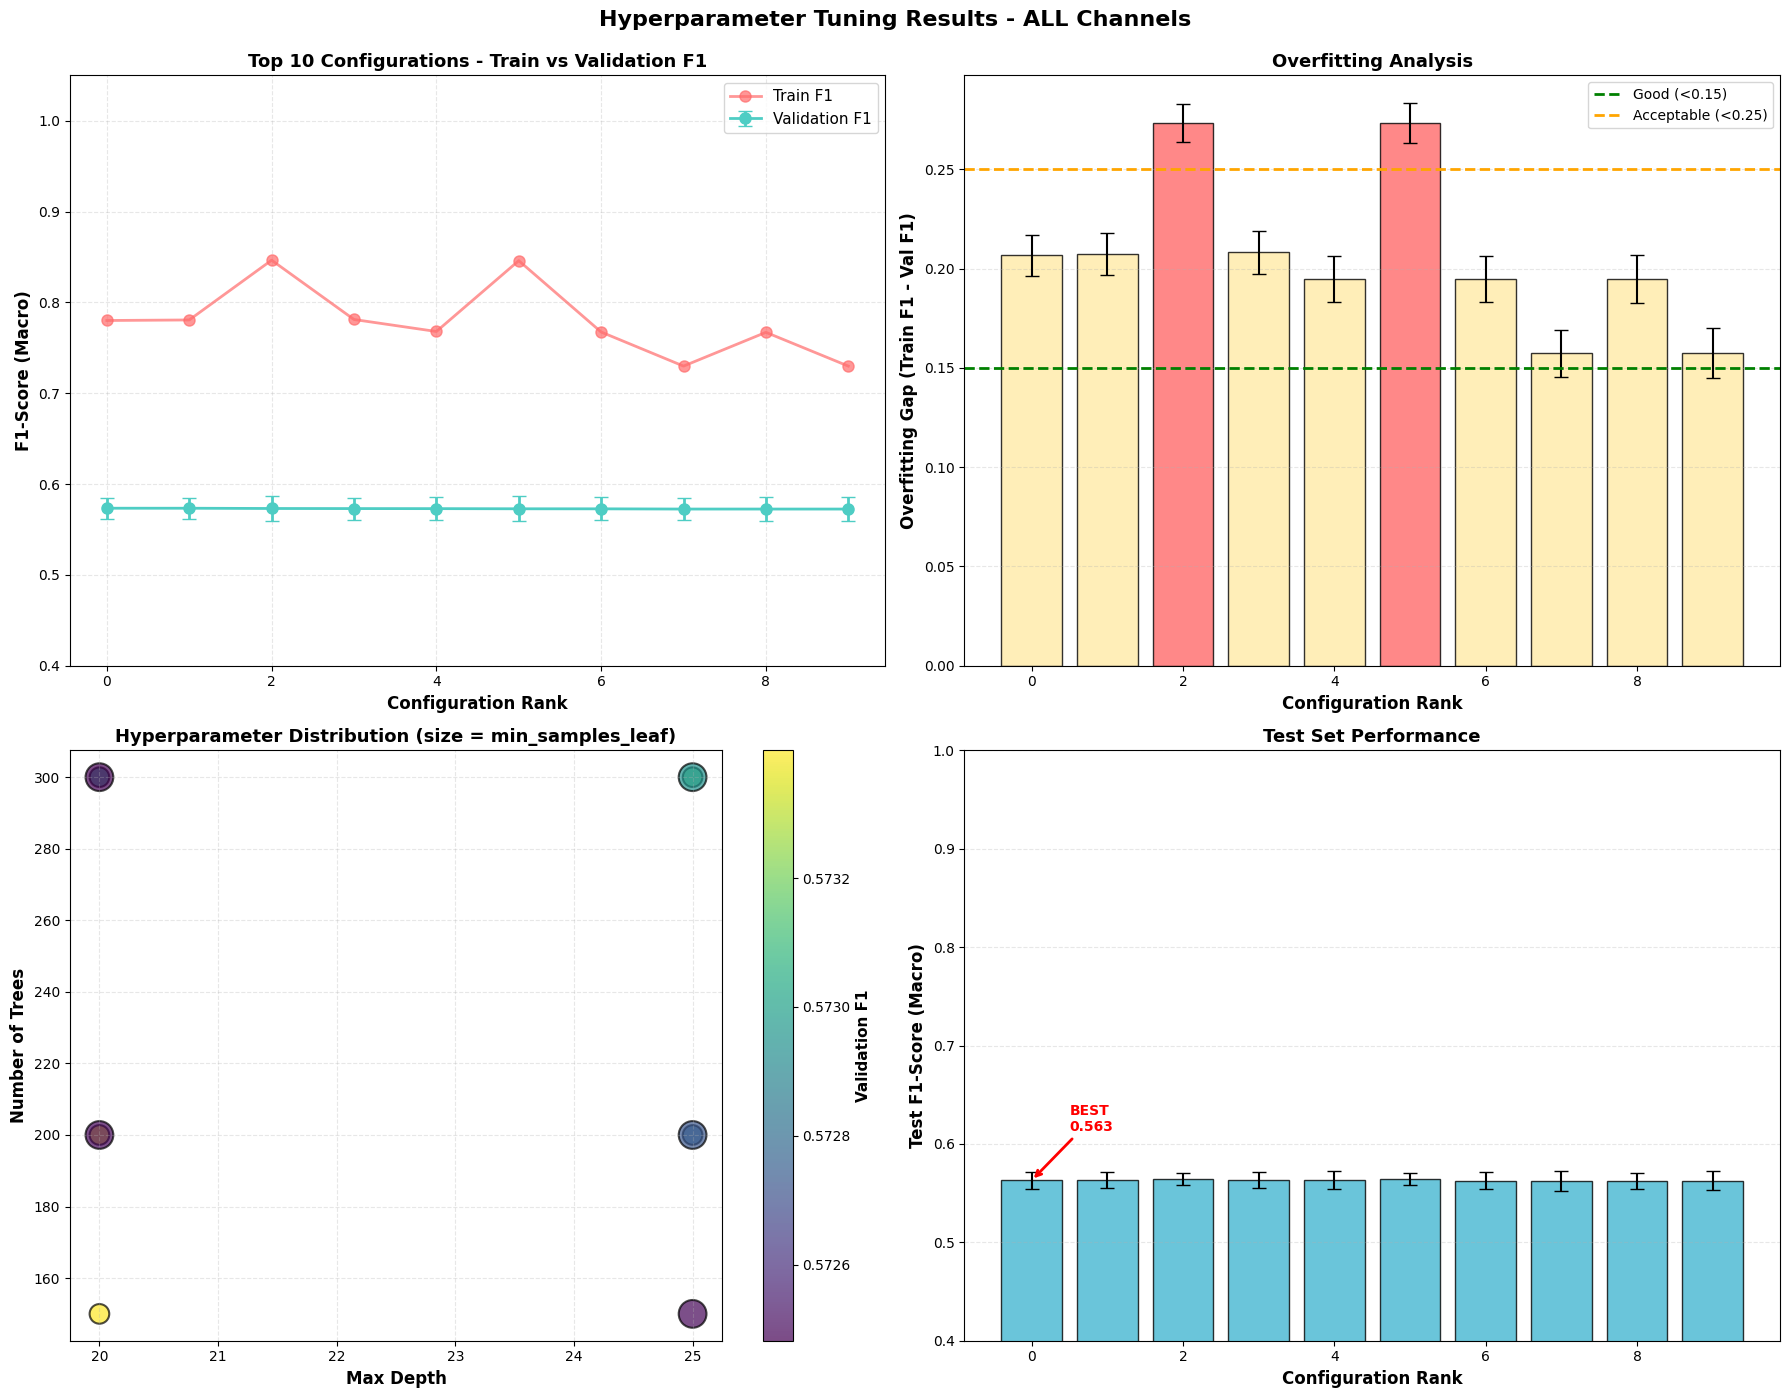


✅ MEJOR CONFIGURACIÓN ALL:
   {'max_depth': 20, 'n_estimators': 150, 'min_samples_leaf': 4}
   Val F1: 0.5734

📈 Generando curvas del mejor modelo...
  ✓ Guardado: best_model_curves_all_channels.png

📝 Generando reporte...
  ✓ Guardado: tuning_report_all_channels.txt

✅ HYPERPARAMETER TUNING COMPLETADO

MEJOR MODELO ALL:
  Params: {'max_depth': 20, 'n_estimators': 150, 'min_samples_leaf': 4}
  Val F1: 0.5734 ± 0.0114
  Test F1: 0.5630 ± 0.0088

📁 Resultados guardados en: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\rf_hyperparameter_tuning

   1. best_model_curves_all_channels.png                 (  239.1 KB)
   2. hyperparameter_tuning_all_channels.png             (  526.5 KB)
   3. tuning_report_all_channels.txt                     (    2.9 KB)




In [ ]:
"""
Random Forest Hyperparameter Tuning - Sleep Stage Classification
Grid Search para encontrar la mejor configuración de RF y evitar overfitting

ESTRATEGIA:
- Grid search sobre: max_depth, n_estimators, min_samples_leaf
- Validación en set separado (split por sujeto)
- Selección del mejor modelo basado en Validation F1-macro
- Visualización de curvas de learning para diferentes configuraciones
"""

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

RESULTS_DIR = BASE_DIR / "rf_hyperparameter_tuning"
RESULTS_DIR.mkdir(exist_ok=True)

# Grid de hiperparámetros a explorar
PARAM_GRID = {
    'max_depth': [10, 15, 20, 25, 30, None],  # Profundidad máxima
    'n_estimators': [50, 100, 150, 200, 300],  # Número de árboles
    'min_samples_leaf': [1, 2, 4, 8],          # Mínimo de muestras por hoja
}

# Parámetros fijos
FIXED_PARAMS = {
    'min_samples_split': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'bootstrap': True,
    'criterion': 'gini'
}

N_ITERATIONS = 3  # Repeticiones con diferentes splits
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
METADATA_COLS = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']

# ===================== FUNCIONES =====================

def load_dataset(parquet_path, dataset_name):
    """Carga dataset"""
    print(f"\n{'='*80}")
    print(f"CARGANDO DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {parquet_path}")
    
    df = pd.read_parquet(parquet_path)
    
    print(f"✓ Cargado: {df.shape}")
    print(f"  - Épocas: {len(df):,}")
    print(f"  - Sujetos: {df['subject_id'].nunique()}")
    
    feature_cols = [col for col in df.columns if col not in METADATA_COLS]
    print(f"  - Features: {len(feature_cols)}")
    
    X = df[feature_cols].values
    y = df['sleep_stage'].values
    subjects = df['subject_id'].values
    
    return X, y, subjects, feature_cols

def load_dataset(parquet_path, dataset_name):
    """Carga dataset y limpia NaNs (imputación mediana)"""
    print(f"\n{'='*80}")
    print(f"CARGANDO DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {parquet_path}")
    
    df = pd.read_parquet(parquet_path)
    
    print(f"✓ Cargado: {df.shape}")
    print(f"  - Épocas: {len(df):,}")
    print(f"  - Sujetos: {df['subject_id'].nunique()}")
    
    feature_cols = [col for col in df.columns if col not in METADATA_COLS]
    print(f"  - Features (antes de limpieza): {len(feature_cols)}")
    
    X_raw = df[feature_cols]
    
    # 1) Columnas completamente NaN
    all_nan_cols = X_raw.columns[X_raw.isna().all()].tolist()
    if all_nan_cols:
        print(f"  ⚠️ Columnas con TODO NaN (se eliminan): {len(all_nan_cols)}")
        # opcional: print(all_nan_cols)
        feature_cols = [c for c in feature_cols if c not in all_nan_cols]
        X_raw = df[feature_cols]
    
    # 2) Contar NaNs restantes
    total_nans = X_raw.isna().sum().sum()
    print(f"  NaNs restantes (después de quitar columnas vacías): {total_nans}")
    
    # 3) Imputación mediana
    if total_nans > 0:
        print("  🔧 Imputando NaNs con mediana por feature...")
        imputer = SimpleImputer(strategy="median")
        X = imputer.fit_transform(X_raw)
    else:
        X = X_raw.values
    
    print(f"  - Features (después de limpieza): {len(feature_cols)}")
    
    y = df['sleep_stage'].values
    subjects = df['subject_id'].values
    
    return X, y, subjects, feature_cols



def split_by_subject(subjects, y, random_state=42):
    """Split por sujeto (60/20/20)"""
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    
    rng = np.random.RandomState(random_state)
    shuffled_subjects = unique_subjects.copy()
    rng.shuffle(shuffled_subjects)
    
    n_train = max(1, int(n_subjects * TRAIN_RATIO))
    n_val = max(1, int(n_subjects * VAL_RATIO))
    n_test = n_subjects - n_train - n_val
    
    if n_test < 1:
        n_test = 1
        n_val = n_subjects - n_train - n_test
    
    train_subjects = shuffled_subjects[:n_train]
    val_subjects = shuffled_subjects[n_train:n_train+n_val]
    test_subjects = shuffled_subjects[n_train+n_val:]
    
    train_mask = np.isin(subjects, train_subjects)
    val_mask = np.isin(subjects, val_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    return train_mask, val_mask, test_mask


def train_and_evaluate_config(X_train, y_train, X_val, y_val, X_test, y_test, params):
    """Entrena y evalúa una configuración específica"""
    
    config = {**FIXED_PARAMS, **params}
    
    start_time = time.time()
    rf = RandomForestClassifier(**config)
    rf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predicciones
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    y_test_pred = rf.predict(X_test)
    
    # Métricas
    results = {
        'params': params,
        'train_time': train_time,
        
        'train_f1': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        'val_f1': f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        'test_f1': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
        
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        
        'train_kappa': cohen_kappa_score(y_train, y_train_pred),
        'val_kappa': cohen_kappa_score(y_val, y_val_pred),
        'test_kappa': cohen_kappa_score(y_test, y_test_pred),
        
        'overfitting_gap': f1_score(y_train, y_train_pred, average='macro', zero_division=0) - 
                          f1_score(y_val, y_val_pred, average='macro', zero_division=0),
    }
    
    return results, rf


def grid_search(X, y, subjects, n_iterations=3):
    """
    Grid search con validación por sujeto
    Retorna: lista de resultados ordenados por validation F1
    """
    
    print(f"\n{'='*80}")
    print(f"GRID SEARCH - Explorando {len(list(product(*PARAM_GRID.values())))} configuraciones")
    print(f"{'='*80}\n")
    
    all_results = []
    total_configs = len(list(product(*PARAM_GRID.values())))
    config_num = 0
    
    # Iterar sobre todas las combinaciones
    for max_depth in PARAM_GRID['max_depth']:
        for n_estimators in PARAM_GRID['n_estimators']:
            for min_samples_leaf in PARAM_GRID['min_samples_leaf']:
                
                config_num += 1
                params = {
                    'max_depth': max_depth,
                    'n_estimators': n_estimators,
                    'min_samples_leaf': min_samples_leaf
                }
                
                print(f"\n[{config_num}/{total_configs}] Evaluando: depth={max_depth}, trees={n_estimators}, min_leaf={min_samples_leaf}")
                
                # Probar con múltiples splits
                iteration_results = []
                
                for iter_num in range(1, n_iterations + 1):
                    # Split por sujeto
                    train_mask, val_mask, test_mask = split_by_subject(
                        subjects, y, random_state=42 + iter_num
                    )
                    
                    X_train, y_train = X[train_mask], y[train_mask]
                    X_val, y_val = X[val_mask], y[val_mask]
                    X_test, y_test = X[test_mask], y[test_mask]
                    
                    # Entrenar y evaluar
                    result, _ = train_and_evaluate_config(
                        X_train, y_train, X_val, y_val, X_test, y_test, params
                    )
                    
                    iteration_results.append(result)
                
                # Promediar resultados de las iteraciones
                avg_result = {
                    'params': params,
                    'max_depth': max_depth,
                    'n_estimators': n_estimators,
                    'min_samples_leaf': min_samples_leaf,
                }
                
                for metric in ['train_f1', 'val_f1', 'test_f1', 
                              'train_acc', 'val_acc', 'test_acc',
                              'train_kappa', 'val_kappa', 'test_kappa',
                              'overfitting_gap', 'train_time']:
                    values = [r[metric] for r in iteration_results]
                    avg_result[f'{metric}_mean'] = np.mean(values)
                    avg_result[f'{metric}_std'] = np.std(values)
                
                all_results.append(avg_result)
                
                print(f"  Val F1: {avg_result['val_f1_mean']:.4f} ± {avg_result['val_f1_std']:.4f} | "
                      f"Overfit Gap: {avg_result['overfitting_gap_mean']:.4f}")
    
    # Ordenar por validation F1 (descendente)
    all_results.sort(key=lambda x: x['val_f1_mean'], reverse=True)
    
    return all_results


def plot_top_configs(results, top_n=10, save_dir=None, dataset_name=""):
    """Visualiza las mejores configuraciones"""
    
    print(f"\n📊 Generando visualización de top {top_n} configuraciones...")
    
    top_results = results[:top_n]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Val F1 vs Train F1
    ax = axes[0, 0]
    train_f1 = [r['train_f1_mean'] for r in top_results]
    val_f1 = [r['val_f1_mean'] for r in top_results]
    val_f1_std = [r['val_f1_std'] for r in top_results]
    
    x = np.arange(len(top_results))
    ax.errorbar(x, train_f1, fmt='o-', color='#FF6B6B', linewidth=2, 
                markersize=8, label='Train F1', alpha=0.7)
    ax.errorbar(x, val_f1, yerr=val_f1_std, fmt='o-', color='#4ECDC4', 
                linewidth=2, markersize=8, label='Validation F1', capsize=5)
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Configurations - Train vs Validation F1', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim([0.4, 1.05])
    
    # Plot 2: Overfitting Gap
    ax = axes[0, 1]
    overfit_gap = [r['overfitting_gap_mean'] for r in top_results]
    overfit_std = [r['overfitting_gap_std'] for r in top_results]
    
    colors = ['#96CEB4' if gap < 0.15 else '#FFEAA7' if gap < 0.25 else '#FF6B6B' 
              for gap in overfit_gap]
    
    ax.bar(x, overfit_gap, yerr=overfit_std, capsize=5, color=colors, 
           alpha=0.8, edgecolor='black', linewidth=1)
    ax.axhline(y=0.15, color='green', linestyle='--', linewidth=2, label='Good (<0.15)')
    ax.axhline(y=0.25, color='orange', linestyle='--', linewidth=2, label='Acceptable (<0.25)')
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overfitting Gap (Train F1 - Val F1)', fontsize=12, fontweight='bold')
    ax.set_title('Overfitting Analysis', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 3: Hiperparámetros de las mejores configs
    ax = axes[1, 0]
    depths = [r['max_depth'] if r['max_depth'] is not None else 50 for r in top_results]
    trees = [r['n_estimators'] for r in top_results]
    leaf_sizes = [r['min_samples_leaf'] for r in top_results]
    
    scatter = ax.scatter(depths, trees, s=[l*50 for l in leaf_sizes], 
                        c=val_f1, cmap='viridis', alpha=0.7, 
                        edgecolors='black', linewidth=1.5)
    
    ax.set_xlabel('Max Depth', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Trees', fontsize=12, fontweight='bold')
    ax.set_title('Hyperparameter Distribution (size = min_samples_leaf)', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Validation F1', fontsize=11, fontweight='bold')
    
    # Plot 4: Test F1 scores
    ax = axes[1, 1]
    test_f1 = [r['test_f1_mean'] for r in top_results]
    test_f1_std = [r['test_f1_std'] for r in top_results]
    
    bars = ax.bar(x, test_f1, yerr=test_f1_std, capsize=5, 
                  color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title('Test Set Performance', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0.4, 1.0])
    
    # Anotar mejor resultado
    best_idx = 0
    ax.annotate(f'BEST\n{test_f1[best_idx]:.3f}', 
               xy=(best_idx, test_f1[best_idx]), 
               xytext=(best_idx+0.5, test_f1[best_idx]+0.05),
               fontsize=10, fontweight='bold', color='red',
               arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    plt.suptitle(f'Hyperparameter Tuning Results - {dataset_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / f'hyperparameter_tuning_{dataset_name.lower().replace(" ", "_")}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Guardado: {save_path.name}")
    
    plt.show()


def plot_learning_curves_best_model(X, y, subjects, best_params, dataset_name, save_dir):
    """Genera curvas de aprendizaje del mejor modelo"""
    
    print(f"\n📈 Generando curvas del mejor modelo...")
    
    # Split
    train_mask, val_mask, test_mask = split_by_subject(subjects, y, random_state=42)
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    
    # Entrenar progresivamente
    n_estimators_range = range(10, best_params['n_estimators'] + 1, 10)
    train_scores = []
    val_scores = []
    
    for n_est in n_estimators_range:
        config = {**FIXED_PARAMS, **best_params, 'n_estimators': n_est}
        rf = RandomForestClassifier(**config)
        rf.fit(X_train, y_train)
        
        train_f1 = f1_score(y_train, rf.predict(X_train), average='macro', zero_division=0)
        val_f1 = f1_score(y_val, rf.predict(X_val), average='macro', zero_division=0)
        
        train_scores.append(train_f1)
        val_scores.append(val_f1)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # F1-Score
    ax = axes[0]
    ax.plot(list(n_estimators_range), train_scores, 'o-', color='#FF6B6B', 
            linewidth=2.5, markersize=8, label='Train F1')
    ax.plot(list(n_estimators_range), val_scores, 'o-', color='#4ECDC4', 
            linewidth=2.5, markersize=8, label='Validation F1')
    
    ax.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title('Learning Curve: Best Model', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Loss
    ax = axes[1]
    train_loss = [1 - s for s in train_scores]
    val_loss = [1 - s for s in val_scores]
    
    ax.plot(list(n_estimators_range), train_loss, 'o-', color='#FF6B6B', 
            linewidth=2.5, markersize=8, label='Train Loss')
    ax.plot(list(n_estimators_range), val_loss, 'o-', color='#4ECDC4', 
            linewidth=2.5, markersize=8, label='Validation Loss')
    
    ax.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (1 - F1-Score)', fontsize=12, fontweight='bold')
    ax.set_title('Loss Curve: Best Model', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    param_str = f"depth={best_params['max_depth']}, min_leaf={best_params['min_samples_leaf']}"
    plt.suptitle(f'Best Model Learning Curves - {dataset_name}\n{param_str}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = save_dir / f'best_model_curves_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def generate_report(results, dataset_name, save_dir):
    """Genera reporte de texto"""
    
    print(f"\n📝 Generando reporte...")
    
    report_path = save_dir / f'tuning_report_{dataset_name.lower().replace(" ", "_")}.txt'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"HYPERPARAMETER TUNING REPORT - {dataset_name}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Total configuraciones evaluadas: {len(results)}\n")
        f.write(f"Iteraciones por configuración: {N_ITERATIONS}\n\n")
        
        f.write("="*80 + "\n")
        f.write("TOP 10 CONFIGURACIONES (ordenadas por Validation F1)\n")
        f.write("="*80 + "\n\n")
        
        for i, r in enumerate(results[:10], 1):
            f.write(f"{i}. max_depth={r['max_depth']}, n_estimators={r['n_estimators']}, min_samples_leaf={r['min_samples_leaf']}\n")
            f.write(f"   Val F1:      {r['val_f1_mean']:.4f} ± {r['val_f1_std']:.4f}\n")
            f.write(f"   Test F1:     {r['test_f1_mean']:.4f} ± {r['test_f1_std']:.4f}\n")
            f.write(f"   Train F1:    {r['train_f1_mean']:.4f} ± {r['train_f1_std']:.4f}\n")
            f.write(f"   Overfit Gap: {r['overfitting_gap_mean']:.4f}\n")
            f.write(f"   Train Time:  {r['train_time_mean']:.2f}s\n\n")
        
        f.write("="*80 + "\n")
        f.write("MEJOR CONFIGURACIÓN (Validation F1)\n")
        f.write("="*80 + "\n\n")
        best = results[0]
        f.write(f"max_depth: {best['max_depth']}\n")
        f.write(f"n_estimators: {best['n_estimators']}\n")
        f.write(f"min_samples_leaf: {best['min_samples_leaf']}\n\n")
        f.write(f"Validation F1: {best['val_f1_mean']:.4f} ± {best['val_f1_std']:.4f}\n")
        f.write(f"Test F1:       {best['test_f1_mean']:.4f} ± {best['test_f1_std']:.4f}\n")
        f.write(f"Overfitting Gap: {best['overfitting_gap_mean']:.4f}\n")
    
    print(f"  ✓ Guardado: {report_path.name}")


# ===================== MAIN =====================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("RANDOM FOREST HYPERPARAMETER TUNING")
    print("Búsqueda del mejor modelo para evitar overfitting")
    print("="*80)
    print(f"\nGrid de búsqueda:")
    print(f"  - max_depth: {PARAM_GRID['max_depth']}")
    print(f"  - n_estimators: {PARAM_GRID['n_estimators']}")
    print(f"  - min_samples_leaf: {PARAM_GRID['min_samples_leaf']}")
    print(f"  Total: {len(list(product(*PARAM_GRID.values())))} configuraciones")
    print(f"  Iteraciones por config: {N_ITERATIONS}")
    print("="*80)
    """
    # ===== DATASET 1: EOG ONLY =====
    try:
        print("\n" + "="*80)
        print("PROCESANDO: EOG ONLY")
        print("="*80)
        
        eog_parquet = list(OUTPUT_EOG.glob("*.parquet"))[0]
        X_eog, y_eog, subjects_eog, _ = load_dataset(eog_parquet, "EOG Only")
        
        # Grid search
        results_eog = grid_search(X_eog, y_eog, subjects_eog, N_ITERATIONS)
        
        # Visualizaciones
        plot_top_configs(results_eog, top_n=10, save_dir=RESULTS_DIR, dataset_name="EOG Only")
        
        # Mejor modelo
        best_params_eog = results_eog[0]['params']
        print(f"\n✅ MEJOR CONFIGURACIÓN EOG:")
        print(f"   {best_params_eog}")
        print(f"   Val F1: {results_eog[0]['val_f1_mean']:.4f}")
        
        plot_learning_curves_best_model(X_eog, y_eog, subjects_eog, best_params_eog, 
                                       "EOG Only", RESULTS_DIR)
        
        # Reporte
        generate_report(results_eog, "EOG Only", RESULTS_DIR)
        
    except Exception as e:
        print(f"\n❌ Error en EOG: {e}")
        import traceback
        traceback.print_exc()
        results_eog = None
    """
    # ===== DATASET 2: ALL CHANNELS =====
    try:
        print("\n" + "="*80)
        print("PROCESANDO: ALL CHANNELS")
        print("="*80)
        
        all_parquet = list(OUTPUT_ALL.glob("*.parquet"))[0]
        X_all, y_all, subjects_all, _ = load_dataset(all_parquet, "ALL Channels")
        
        # Grid search
        results_all = grid_search(X_all, y_all, subjects_all, N_ITERATIONS)
        
        # Visualizaciones
        plot_top_configs(results_all, top_n=10, save_dir=RESULTS_DIR, dataset_name="ALL Channels")
        
        # Mejor modelo
        best_params_all = results_all[0]['params']
        print(f"\n✅ MEJOR CONFIGURACIÓN ALL:")
        print(f"   {best_params_all}")
        print(f"   Val F1: {results_all[0]['val_f1_mean']:.4f}")
        
        plot_learning_curves_best_model(X_all, y_all, subjects_all, best_params_all, 
                                       "ALL Channels", RESULTS_DIR)
        
        # Reporte
        generate_report(results_all, "ALL Channels", RESULTS_DIR)
        
    except Exception as e:
        print(f"\n❌ Error en ALL: {e}")
        import traceback
        traceback.print_exc()
        results_all = None
    
    # ===== RESUMEN FINAL =====
    print(f"\n{'='*80}")
    print("✅ HYPERPARAMETER TUNING COMPLETADO")
    print(f"{'='*80}\n")
    """
    if results_eog:
        print(f"MEJOR MODELO EOG:")
        print(f"  Params: {results_eog[0]['params']}")
        print(f"  Val F1: {results_eog[0]['val_f1_mean']:.4f} ± {results_eog[0]['val_f1_std']:.4f}")
        print(f"  Test F1: {results_eog[0]['test_f1_mean']:.4f} ± {results_eog[0]['test_f1_std']:.4f}\n")
    """
    if results_all:
        print(f"MEJOR MODELO ALL:")
        print(f"  Params: {results_all[0]['params']}")
        print(f"  Val F1: {results_all[0]['val_f1_mean']:.4f} ± {results_all[0]['val_f1_std']:.4f}")
        print(f"  Test F1: {results_all[0]['test_f1_mean']:.4f} ± {results_all[0]['test_f1_std']:.4f}\n")
    
    print(f"📁 Resultados guardados en: {RESULTS_DIR}\n")
    
    result_files = sorted(RESULTS_DIR.glob('*'))
    for i, file in enumerate(result_files, 1):
        size_kb = file.stat().st_size / 1024
        print(f"   {i}. {file.name:50} ({size_kb:7.1f} KB)")
    
    print(f"\n{'='*80}\n")

Entrenamiento

In [7]:
"""
Random Forest Training & Evaluation - Sleep Stage Classification
Basado en: Rahman et al. (2018) - Sleep stage classification using single-channel EOG

CORRECCIONES:
- Split 60/20/20 train/val/test POR SUJETO (no mezclar épocas)
- Curvas de entrenamiento corregidas (train y validation reales)
- Gráficos de loss (1 - F1-score)
- 5 iteraciones con diferentes splits de sujetos
- Cohen's Kappa por etapa agregado
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             f1_score, cohen_kappa_score, accuracy_score)
from collections import defaultdict
import warnings
import time

warnings.filterwarnings('ignore')

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

RESULTS_DIR = BASE_DIR / "rf_training_results_corrected"
RESULTS_DIR.mkdir(exist_ok=True)

# Configuración Random Forest
RF_CONFIGEOG = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 8,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'bootstrap': True,
    'criterion': 'gini'
}

RF_CONFIGALL = {
    'n_estimators': 150,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'bootstrap': True,
    'criterion': 'gini'
}

N_ITERATIONS = 5
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#96CEB4', 4: '#FFEAA7'}

METADATA_COLS = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']

# ===================== FUNCIONES =====================

def load_dataset(parquet_path, dataset_name):
    """Carga dataset y separa features/labels"""
    
    print(f"\n{'='*80}")
    print(f"CARGANDO DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {parquet_path}")
    
    df = pd.read_parquet(parquet_path)
    
    print(f"✓ Cargado: {df.shape}")
    print(f"  - Épocas: {len(df):,}")
    print(f"  - Sujetos: {df['subject_id'].nunique()}")
    
    metadata_present = [col for col in METADATA_COLS if col in df.columns]
    feature_cols = [col for col in df.columns if col not in METADATA_COLS]
    
    print(f"  - Features: {len(feature_cols)}")
    
    X = df[feature_cols].values
    y = df['sleep_stage'].values
    subjects = df['subject_id'].values
    
    print(f"\n  Distribución Sleep Stages:")
    for stage in sorted(np.unique(y)):
        if stage >= 0:
            count = np.sum(y == stage)
            pct = (count / len(y)) * 100
            bar = '█' * int(pct / 2)
            print(f"    {STAGE_NAMES.get(stage, f'Stage {stage}'):8} | {bar} {count:7,} ({pct:5.1f}%)")
    
    return X, y, subjects, feature_cols, df


def split_by_subject(subjects, y, random_state=42):
    """Split datos por sujeto (60/20/20) - NO MEZCLA ÉPOCAS DE SUJETOS"""
    
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    
    print(f"\n  📊 Split por sujeto (sin mezclar épocas):")
    print(f"     Total sujetos: {n_subjects}")
    
    rng = np.random.RandomState(random_state)
    shuffled_subjects = unique_subjects.copy()
    rng.shuffle(shuffled_subjects)
    
    n_train = max(1, int(n_subjects * TRAIN_RATIO))
    n_val = max(1, int(n_subjects * VAL_RATIO))
    n_test = n_subjects - n_train - n_val
    
    if n_test < 1:
        n_test = 1
        n_val = n_subjects - n_train - n_test
    
    train_subjects = shuffled_subjects[:n_train]
    val_subjects = shuffled_subjects[n_train:n_train+n_val]
    test_subjects = shuffled_subjects[n_train+n_val:]
    
    print(f"     Train: {len(train_subjects)} sujetos - {train_subjects}")
    print(f"     Val:   {len(val_subjects)} sujetos - {val_subjects}")
    print(f"     Test:  {len(test_subjects)} sujetos - {test_subjects}")
    
    train_mask = np.isin(subjects, train_subjects)
    val_mask = np.isin(subjects, val_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    n_train_epochs = np.sum(train_mask)
    n_val_epochs = np.sum(val_mask)
    n_test_epochs = np.sum(test_mask)
    
    print(f"\n     Épocas Train: {n_train_epochs:,} ({100*n_train_epochs/len(subjects):.1f}%)")
    print(f"     Épocas Val:   {n_val_epochs:,} ({100*n_val_epochs/len(subjects):.1f}%)")
    print(f"     Épocas Test:  {n_test_epochs:,} ({100*n_test_epochs/len(subjects):.1f}%)")
    
    return train_mask, val_mask, test_mask


def cohen_kappa_per_class(y_true, y_pred, labels=None):
    """Calcula Cohen's Kappa para cada clase (One-vs-Rest)"""
    if labels is None:
        labels = np.unique(y_true)
    
    kappas = {}
    for label in labels:
        y_true_binary = (y_true == label).astype(int)
        y_pred_binary = (y_pred == label).astype(int)
        kappa = cohen_kappa_score(y_true_binary, y_pred_binary)
        kappas[label] = kappa
    
    return kappas


def train_with_monitoring(X_train, y_train, X_val, y_val, iteration, RF_CONFIG):
    """Entrena RF monitoreando progreso durante el entrenamiento"""
    
    print(f"\n  🌲 Iteración {iteration}/{N_ITERATIONS}")
    
    n_estimators_list = [10, 25, 50, 75, 100, 150, 200]
    
    train_f1_curve = []
    val_f1_curve = []
    train_loss_curve = []
    val_loss_curve = []
    
    print(f"     Entrenando progresivamente...")
    
    for n_est in n_estimators_list:
        rf = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=RF_CONFIG['max_depth'],
            min_samples_split=RF_CONFIG['min_samples_split'],
            min_samples_leaf=RF_CONFIG['min_samples_leaf'],
            max_features=RF_CONFIG['max_features'],
            random_state=RF_CONFIG['random_state'],
            n_jobs=RF_CONFIG['n_jobs'],
            class_weight=RF_CONFIG['class_weight'],
            bootstrap=RF_CONFIG['bootstrap'],
            criterion=RF_CONFIG['criterion']
        )
        
        rf.fit(X_train, y_train)
        
        y_train_pred = rf.predict(X_train)
        y_val_pred = rf.predict(X_val)
        
        train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
        val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        
        train_f1_curve.append(train_f1)
        val_f1_curve.append(val_f1)
        
        train_loss_curve.append(1 - train_f1)
        val_loss_curve.append(1 - val_f1)
        
        print(f"       {n_est:3d} trees | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
    
    rf_final = RandomForestClassifier(**RF_CONFIG)
    
    start_time = time.time()
    rf_final.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    return rf_final, train_f1_curve, val_f1_curve, train_loss_curve, val_loss_curve, train_time, n_estimators_list


def evaluate_model(rf, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evalúa modelo en los 3 sets"""
    
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    y_test_pred = rf.predict(X_test)
    
    # Cohen's Kappa por clase
    labels = sorted(np.unique(y_test))
    test_kappa_per_class = cohen_kappa_per_class(y_test, y_test_pred, labels)
    
    metrics = {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        
        'train_f1_macro': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        'test_f1_macro': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
        
        'train_kappa': cohen_kappa_score(y_train, y_train_pred),
        'val_kappa': cohen_kappa_score(y_val, y_val_pred),
        'test_kappa': cohen_kappa_score(y_test, y_test_pred),
        
        'test_f1_per_class': f1_score(y_test, y_test_pred, average=None, zero_division=0),
        'test_kappa_per_class': test_kappa_per_class,
        'confusion_matrix': confusion_matrix(y_test, y_test_pred)
    }
    
    print(f"\n     📊 Métricas finales:")
    print(f"        Train | Acc: {metrics['train_acc']:.4f} | F1: {metrics['train_f1_macro']:.4f} | Kappa: {metrics['train_kappa']:.4f}")
    print(f"        Val   | Acc: {metrics['val_acc']:.4f} | F1: {metrics['val_f1_macro']:.4f} | Kappa: {metrics['val_kappa']:.4f}")
    print(f"        Test  | Acc: {metrics['test_acc']:.4f} | F1: {metrics['test_f1_macro']:.4f} | Kappa: {metrics['test_kappa']:.4f}")
    
    return metrics


def plot_learning_curves(all_train_curves, all_val_curves, all_loss_train, all_loss_val, 
                         n_estimators_list, dataset_name, save_dir):
    """Grafica curvas de F1 y Loss durante entrenamiento"""
    
    print(f"\n  📈 Generando curvas de entrenamiento...")
    
    train_f1_mean = np.mean(all_train_curves, axis=0)
    train_f1_std = np.std(all_train_curves, axis=0)
    val_f1_mean = np.mean(all_val_curves, axis=0)
    val_f1_std = np.std(all_val_curves, axis=0)
    
    train_loss_mean = np.mean(all_loss_train, axis=0)
    train_loss_std = np.std(all_loss_train, axis=0)
    val_loss_mean = np.mean(all_loss_val, axis=0)
    val_loss_std = np.std(all_loss_val, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: F1-Score
    ax = axes[0]
    ax.plot(n_estimators_list, train_f1_mean, 'o-', color='#FF6B6B', 
            linewidth=2.5, markersize=8, label='Train F1-macro')
    ax.fill_between(n_estimators_list, 
                     train_f1_mean - train_f1_std, 
                     train_f1_mean + train_f1_std, 
                     alpha=0.2, color='#FF6B6B')
    
    ax.plot(n_estimators_list, val_f1_mean, 'o-', color='#4ECDC4', 
            linewidth=2.5, markersize=8, label='Validation F1-macro')
    ax.fill_between(n_estimators_list, 
                     val_f1_mean - val_f1_std, 
                     val_f1_mean + val_f1_std, 
                     alpha=0.2, color='#4ECDC4')
    
    ax.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title(f'Learning Curve: F1-Score - {dataset_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Plot 2: Loss
    ax = axes[1]
    ax.plot(n_estimators_list, train_loss_mean, 'o-', color='#FF6B6B', 
            linewidth=2.5, markersize=8, label='Train Loss')
    ax.fill_between(n_estimators_list, 
                     train_loss_mean - train_loss_std, 
                     train_loss_mean + train_loss_std, 
                     alpha=0.2, color='#FF6B6B')
    
    ax.plot(n_estimators_list, val_loss_mean, 'o-', color='#4ECDC4', 
            linewidth=2.5, markersize=8, label='Validation Loss')
    ax.fill_between(n_estimators_list, 
                     val_loss_mean - val_loss_std, 
                     val_loss_mean + val_loss_std, 
                     alpha=0.2, color='#4ECDC4')
    
    ax.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (1 - F1-Score)', fontsize=12, fontweight='bold')
    ax.set_title(f'Learning Curve: Loss - {dataset_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    save_path = save_dir / f'learning_curves_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def plot_kappa_per_stage(results_eog, results_all, save_dir):
    """Grafica Cohen's Kappa por etapa de sueño"""
    
    print(f"\n  📊 Generando gráfico de Kappa por etapa...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    datasets = ['EOG Only', 'ALL Channels']
    results_list = [results_eog, results_all]
    colors = ['#FF6B6B', '#4ECDC4']
    
    stages = sorted(results_eog['test_kappa_per_stage'].keys())
    x = np.arange(len(stages))
    width = 0.35
    
    for idx, (name, results, color) in enumerate(zip(datasets, results_list, colors)):
        kappa_per_stage = results['test_kappa_per_stage']
        means = [kappa_per_stage[s]['mean'] for s in stages]
        stds = [kappa_per_stage[s]['std'] for s in stages]
        
        offset = width * (idx - 0.5)
        bars = ax.bar(x + offset, means, width, yerr=stds, capsize=5,
                     label=name, color=color, alpha=0.8, 
                     edgecolor='black', linewidth=1)
        
        # Agregar valores en las barras
        for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                   f'{mean:.3f}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax.set_title("Cohen's Kappa por Sleep Stage (Test Set)", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES.get(s, f'S{s}') for s in stages])
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Línea de referencia
    ax.axhline(y=0.6, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Substantial agreement (0.6)')
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Almost perfect (0.8)')
    
    plt.tight_layout()
    save_path = save_dir / 'kappa_per_stage.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def plot_confusion_matrices(confusion_matrices, dataset_name, y_all, save_dir):
    """Grafica matriz de confusión promedio"""
    
    print(f"\n  📊 Generando matriz de confusión...")
    
    cm_avg = np.mean(confusion_matrices, axis=0)
    cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    
    classes = sorted(np.unique(y_all))
    labels = [STAGE_NAMES.get(c, f'Stage {c}') for c in classes]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz 1: Conteos
    ax = axes[0]
    sns.heatmap(cm_avg, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, 
                cbar_kws={'label': 'Count'}, ax=ax, 
                linewidths=0.5, linecolor='gray')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix (Average Counts)', fontsize=13, fontweight='bold')
    
    # Matriz 2: Normalizada
    ax = axes[1]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='RdYlGn', 
                xticklabels=labels, yticklabels=labels, 
                cbar_kws={'label': 'Proportion'}, ax=ax, 
                vmin=0, vmax=1, linewidths=0.5, linecolor='gray')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix (Normalized)', fontsize=13, fontweight='bold')
    
    plt.suptitle(f'{dataset_name} - Test Set (Promedio {N_ITERATIONS} Iteraciones)', 
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = save_dir / f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def plot_performance_comparison(results_eog, results_all, save_dir):
    """Compara rendimiento EOG vs ALL"""
    
    print(f"\n  📊 Generando comparación...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = ['EOG Only', 'ALL Channels']
    results_list = [results_eog, results_all]
    
    # Plot 1: F1 por stage
    ax = axes[0, 0]
    for idx, (name, results) in enumerate(zip(datasets, results_list)):
        f1_per_stage = results['test_f1_per_stage']
        stages = sorted(f1_per_stage.keys())
        means = [f1_per_stage[s]['mean'] for s in stages]
        stds = [f1_per_stage[s]['std'] for s in stages]
        
        x_pos = np.arange(len(stages)) + idx * 0.35
        colors = ['#FF6B6B', '#4ECDC4']
        
        ax.bar(x_pos, means, 0.35, yerr=stds, capsize=5, 
               label=name, color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('F1-Score por Sleep Stage (Test Set)', fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(stages)) + 0.175)
    ax.set_xticklabels([STAGE_NAMES.get(s, f'S{s}') for s in stages])
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Plot 2: Métricas globales
    ax = axes[0, 1]
    metrics_global = ['F1-Macro', 'Kappa']
    x = np.arange(len(metrics_global))
    width = 0.35
    
    eog_vals = [results_eog['test_f1_macro']['mean'], results_eog['test_kappa']['mean']]
    eog_stds = [results_eog['test_f1_macro']['std'], results_eog['test_kappa']['std']]
    all_vals = [results_all['test_f1_macro']['mean'], results_all['test_kappa']['mean']]
    all_stds = [results_all['test_f1_macro']['std'], results_all['test_kappa']['std']]
    
    ax.bar(x - width/2, eog_vals, width, yerr=eog_stds, capsize=5,
           label='EOG Only', color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1)
    ax.bar(x + width/2, all_vals, width, yerr=all_stds, capsize=5,
           label='ALL Channels', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Métricas Globales (Test Set)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_global)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for i, (ev, es, av, as_) in enumerate(zip(eog_vals, eog_stds, all_vals, all_stds)):
        ax.text(i - width/2, ev + es + 0.02, f'{ev:.3f}±{es:.3f}', 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
        ax.text(i + width/2, av + as_ + 0.02, f'{av:.3f}±{as_:.3f}', 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Plot 3: Accuracy
    ax = axes[1, 0]
    acc_vals = [results_eog['test_acc']['mean'], results_all['test_acc']['mean']]
    acc_stds = [results_eog['test_acc']['std'], results_all['test_acc']['std']]
    
    bars = ax.bar(['EOG Only', 'ALL Channels'], acc_vals, yerr=acc_stds, capsize=5,
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Test Accuracy', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bar, val, std in zip(bars, acc_vals, acc_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
               f'{val:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Training time
    ax = axes[1, 1]
    time_vals = [results_eog['train_time']['mean'], results_all['train_time']['mean']]
    time_stds = [results_eog['train_time']['std'], results_all['train_time']['std']]
    
    bars = ax.bar(['EOG Only', 'ALL Channels'], time_vals, yerr=time_stds, capsize=5,
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('Training Time', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, val, std in zip(bars, time_vals, time_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 1,
               f'{val:.1f}±{std:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Comparación de Rendimiento: EOG vs ALL Channels', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = save_dir / 'performance_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def generate_summary_report(results_eog, results_all, save_dir):
    """Genera reporte de texto"""
    
    print(f"\n  📝 Generando reporte...")
    
    report_path = save_dir / 'training_summary_report.txt'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("RANDOM FOREST TRAINING & EVALUATION - SLEEP STAGE CLASSIFICATION\n")
        f.write("Basado en: Rahman et al. (2018)\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"CONFIGURACIÓN:\n")
        f.write(f"  - Iteraciones: {N_ITERATIONS}\n")
        f.write(f"  - Split: {int(TRAIN_RATIO*100)}% Train / {int(VAL_RATIO*100)}% Val / {int(TEST_RATIO*100)}% Test\n")
        f.write(f"  - Split por SUJETO (no se mezclan épocas entre sets)\n")
        f.write(f"  - RF criterion: Gini impurity (función interna)\n")
        f.write(f"  - Loss mostrado: 1 - F1-score (proxy para gráficos)\n\n")
        
        for name, results in [("EOG HORIZONTAL", results_eog), ("ALL CHANNELS", results_all)]:
            f.write(f"\n{'='*80}\n")
            f.write(f"RESULTADOS: {name}\n")
            f.write(f"{'='*80}\n\n")
            
            f.write(f"MÉTRICAS GLOBALES EN TEST SET (promedio ± std de {N_ITERATIONS} iteraciones):\n")
            f.write(f"  - Test Accuracy:  {results['test_acc']['mean']:.4f} ± {results['test_acc']['std']:.4f}\n")
            f.write(f"  - Test F1-Macro:  {results['test_f1_macro']['mean']:.4f} ± {results['test_f1_macro']['std']:.4f}\n")
            f.write(f"  - Test Kappa:     {results['test_kappa']['mean']:.4f} ± {results['test_kappa']['std']:.4f}\n")
            f.write(f"  - Training Time:  {results['train_time']['mean']:.2f} ± {results['train_time']['std']:.2f} segundos\n")
            
            f.write(f"\nF1-SCORE POR SLEEP STAGE (Test Set):\n")
            for stage in sorted(results['test_f1_per_stage'].keys()):
                mean = results['test_f1_per_stage'][stage]['mean']
                std = results['test_f1_per_stage'][stage]['std']
                stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
                f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
            
            f.write(f"\nCOHEN'S KAPPA POR SLEEP STAGE (Test Set):\n")
            for stage in sorted(results['test_kappa_per_stage'].keys()):
                mean = results['test_kappa_per_stage'][stage]['mean']
                std = results['test_kappa_per_stage'][stage]['std']
                stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
                f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
        
        f.write(f"\n{'='*80}\n")
        f.write("COMPARACIÓN EOG vs ALL\n")
        f.write(f"{'='*80}\n\n")
        
        diff_acc = results_all['test_acc']['mean'] - results_eog['test_acc']['mean']
        diff_f1 = results_all['test_f1_macro']['mean'] - results_eog['test_f1_macro']['mean']
        diff_kappa = results_all['test_kappa']['mean'] - results_eog['test_kappa']['mean']
        
        f.write(f"Diferencias (ALL - EOG):\n")
        f.write(f"  - Accuracy:  {diff_acc:+.4f}\n")
        f.write(f"  - F1-Macro:  {diff_f1:+.4f}\n")
        f.write(f"  - Kappa:     {diff_kappa:+.4f}\n")
    
    print(f"    ✓ Guardado: {report_path.name}")


def run_training_evaluation(X, y, subjects, RF_CONFIG, dataset_name, save_dir):
    """Ejecuta 5 iteraciones de entrenamiento y evaluación"""
    
    print(f"\n{'='*80}")
    print(f"ENTRENAMIENTO Y EVALUACIÓN: {dataset_name}")
    print(f"{'='*80}")
    
    all_metrics = defaultdict(list)
    all_confusion_matrices = []
    all_train_curves = []
    all_val_curves = []
    all_loss_train_curves = []
    all_loss_val_curves = []
    n_estimators_list = None
    
    for iteration in range(1, N_ITERATIONS + 1):
        
        train_mask, val_mask, test_mask = split_by_subject(
            subjects, y, 
            random_state=42 + iteration
        )
        
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_val = X[val_mask]
        y_val = y[val_mask]
        X_test = X[test_mask]
        y_test = y[test_mask]
        
        rf_model, train_f1, val_f1, train_loss, val_loss, train_time, n_est_list = train_with_monitoring(
            X_train, y_train, X_val, y_val, iteration, RF_CONFIG
        )
        
        if n_estimators_list is None:
            n_estimators_list = n_est_list
        
        all_train_curves.append(train_f1)
        all_val_curves.append(val_f1)
        all_loss_train_curves.append(train_loss)
        all_loss_val_curves.append(val_loss)
        
        metrics = evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test)
        
        all_metrics['train_time'].append(train_time)
        all_metrics['train_acc'].append(metrics['train_acc'])
        all_metrics['val_acc'].append(metrics['val_acc'])
        all_metrics['test_acc'].append(metrics['test_acc'])
        all_metrics['train_f1_macro'].append(metrics['train_f1_macro'])
        all_metrics['val_f1_macro'].append(metrics['val_f1_macro'])
        all_metrics['test_f1_macro'].append(metrics['test_f1_macro'])
        all_metrics['train_kappa'].append(metrics['train_kappa'])
        all_metrics['val_kappa'].append(metrics['val_kappa'])
        all_metrics['test_kappa'].append(metrics['test_kappa'])
        
        for i, stage in enumerate(sorted(np.unique(y))):
            if i < len(metrics['test_f1_per_class']):
                all_metrics[f'test_f1_stage_{stage}'].append(metrics['test_f1_per_class'][i])
        
        for stage, kappa in metrics['test_kappa_per_class'].items():
            all_metrics[f'test_kappa_stage_{stage}'].append(kappa)
        
        all_confusion_matrices.append(metrics['confusion_matrix'])
    
    results = {}
    
    for key in ['train_time', 'train_acc', 'val_acc', 'test_acc', 
                'train_f1_macro', 'val_f1_macro', 'test_f1_macro', 
                'train_kappa', 'val_kappa', 'test_kappa']:
        if key in all_metrics and len(all_metrics[key]) > 0:
            results[key] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    results['test_f1_per_stage'] = {}
    for stage in sorted(np.unique(y)):
        key = f'test_f1_stage_{stage}'
        if key in all_metrics:
            results['test_f1_per_stage'][stage] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    results['test_kappa_per_stage'] = {}
    for stage in sorted(np.unique(y)):
        key = f'test_kappa_stage_{stage}'
        if key in all_metrics:
            results['test_kappa_per_stage'][stage] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    print(f"\n{'='*80}")
    print(f"RESUMEN - {dataset_name}")
    print(f"{'='*80}\n")
    print(f"Test Accuracy:  {results['test_acc']['mean']:.4f} ± {results['test_acc']['std']:.4f}")
    print(f"Test F1-Macro:  {results['test_f1_macro']['mean']:.4f} ± {results['test_f1_macro']['std']:.4f}")
    print(f"Test Kappa:     {results['test_kappa']['mean']:.4f} ± {results['test_kappa']['std']:.4f}")
    print(f"Training Time:  {results['train_time']['mean']:.2f} ± {results['train_time']['std']:.2f}s")
    
    print(f"\nF1-Score por Stage:")
    for stage in sorted(results['test_f1_per_stage'].keys()):
        mean = results['test_f1_per_stage'][stage]['mean']
        std = results['test_f1_per_stage'][stage]['std']
        stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
        print(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}")
    
    print(f"\nCohen's Kappa por Stage:")
    for stage in sorted(results['test_kappa_per_stage'].keys()):
        mean = results['test_kappa_per_stage'][stage]['mean']
        std = results['test_kappa_per_stage'][stage]['std']
        stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
        print(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}")
    
    print(f"\n📊 Generando visualizaciones...")
    
    plot_learning_curves(
        all_train_curves, all_val_curves, 
        all_loss_train_curves, all_loss_val_curves,
        n_estimators_list, dataset_name, save_dir
    )
    
    plot_confusion_matrices(all_confusion_matrices, dataset_name, y, save_dir)
    
    return results


if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("RANDOM FOREST TRAINING & EVALUATION - CON KAPPA POR ETAPA")
    print("Sleep Stage Classification usando Single-Channel EOG")
    print("Basado en: Rahman et al. (2018)")
    print("="*80)
    print("\nCORRECCIONES APLICADAS:")
    print("  ✅ Split 60/20/20 por SUJETO (sin mezclar épocas)")
    print("  ✅ Curvas de entrenamiento REALES (train y validation)")
    print("  ✅ Gráficos de Loss (1 - F1-score)")
    print("  ✅ 5 iteraciones con diferentes splits aleatorios")
    print("  ✅ Cohen's Kappa por etapa de sueño")
    print("="*80)
    
    print(f"\n📂 Resultados se guardarán en: {RESULTS_DIR}\n")
    
    try:
        eog_parquet = list(OUTPUT_EOG.glob("*.parquet"))[0]
        X_eog, y_eog, subjects_eog, features_eog, df_eog = load_dataset(eog_parquet, "EOG Only")
        
        results_eog = run_training_evaluation(
            X_eog, y_eog, subjects_eog, RF_CONFIGEOG,
            "EOG Only", 
            RESULTS_DIR
        )
        
    except Exception as e:
        print(f"\n❌ Error en EOG dataset: {e}")
        import traceback
        traceback.print_exc()
        results_eog = None
    
    try:
        all_parquet = list(OUTPUT_ALL.glob("*.parquet"))[0]
        X_all, y_all, subjects_all, features_all, df_all = load_dataset(all_parquet, "ALL Channels")
        
        results_all = run_training_evaluation(
            X_all, y_all, subjects_all, RF_CONFIGALL,
            "ALL Channels", 
            RESULTS_DIR
        )
        
    except Exception as e:
        print(f"\n❌ Error en ALL dataset: {e}")
        import traceback
        traceback.print_exc()
        results_all = None
    
    if results_eog and results_all:
        print(f"\n{'='*80}")
        print("GENERANDO COMPARACIÓN FINAL")
        print(f"{'='*80}")
        
        plot_performance_comparison(results_eog, results_all, RESULTS_DIR)
        plot_kappa_per_stage(results_eog, results_all, RESULTS_DIR)
        generate_summary_report(results_eog, results_all, RESULTS_DIR)
    
    print(f"\n{'='*80}")
    print("✅ ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS")
    print(f"{'='*80}\n")
    
    print(f"📁 Archivos generados en: {RESULTS_DIR}\n")
    
    result_files = sorted(RESULTS_DIR.glob('*'))
    for i, file in enumerate(result_files, 1):
        size_kb = file.stat().st_size / 1024
        print(f"   {i}. {file.name:50} ({size_kb:7.1f} KB)")
    
    print(f"\n{'='*80}\n")


RANDOM FOREST TRAINING & EVALUATION - CON KAPPA POR ETAPA
Sleep Stage Classification usando Single-Channel EOG
Basado en: Rahman et al. (2018)

CORRECCIONES APLICADAS:
  ✅ Split 60/20/20 por SUJETO (sin mezclar épocas)
  ✅ Curvas de entrenamiento REALES (train y validation)
  ✅ Gráficos de Loss (1 - F1-score)
  ✅ 5 iteraciones con diferentes splits aleatorios
  ✅ Cohen's Kappa por etapa de sueño

📂 Resultados se guardarán en: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\rf_training_results_corrected


CARGANDO DATASET: EOG Only

✓ Cargado: (59237, 38)
  - Épocas: 59,237
  - Sujetos: 153
  - Features: 30

  Distribución Sleep Stages:
    Wake     | █████████████  16,066 ( 27.1%)
    N1       | ██████   7,222 ( 12.2%)
    N2       | ███████████████████  23,052 ( 38.9%)
    N3       | ███   4,322 (  7.3%)
    REM      | ███████   8,575 ( 14.5%)

ENTRENAMIENTO Y EVALUACIÓN: EOG Only

  📊 Split por sujeto (sin mezclar épocas):
     Total sujetos: 153
     Train: 91 sujetos 

# 5. SVM

Tal como el caso anterior, se itera primero para encontrar los mejores hiperparámetros para el entrenamiento con Support Vector Machine

In [ ]:
"""
SVM Hyperparameter Tuning - Sleep Stage Classification
Grid Search para encontrar la mejor configuración de SVM
Basado en: Rahman et al. (2018) - Sleep stage classification using single-channel EOG

ESTRATEGIA:
- Grid search sobre: kernel, C, gamma (para RBF)
- Validación en set separado (split por sujeto)
- Selección del mejor modelo basado en Validation F1-macro
- Incluye Cohen's Kappa por etapa
"""

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

RESULTS_DIR = BASE_DIR / "svm_hyperparameter_tuning"
RESULTS_DIR.mkdir(exist_ok=True)

# Grid de hiperparámetros a explorar (según paper)

PARAM_GRID = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100, 1000],  # Parámetro de regularización
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Solo para RBF y poly
    'degree': [2, 3, 4],  # Solo para poly
}

N_ITERATIONS = 1  # Repeticiones con diferentes splits
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
METADATA_COLS = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']

# ===================== FUNCIONES =====================

from sklearn.impute import SimpleImputer

def load_dataset(parquet_path, dataset_name):
    """Carga dataset y limpia NaNs (imputación mediana)"""
    print(f"\n{'='*80}")
    print(f"CARGANDO DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {parquet_path}")
    
    df = pd.read_parquet(parquet_path)
    
    print(f"✓ Cargado: {df.shape}")
    print(f"  - Épocas: {len(df):,}")
    print(f"  - Sujetos: {df['subject_id'].nunique()}")
    
    feature_cols = [col for col in df.columns if col not in METADATA_COLS]
    print(f"  - Features (antes de limpieza): {len(feature_cols)}")
    
    X_raw = df[feature_cols]
    
    # 1) Columnas completamente NaN
    all_nan_cols = X_raw.columns[X_raw.isna().all()].tolist()
    if all_nan_cols:
        print(f"  ⚠️ Columnas con TODO NaN (se eliminan): {len(all_nan_cols)}")
        # opcional: print(all_nan_cols)
        feature_cols = [c for c in feature_cols if c not in all_nan_cols]
        X_raw = df[feature_cols]
    
    # 2) Contar NaNs restantes
    total_nans = X_raw.isna().sum().sum()
    print(f"  NaNs restantes (después de quitar columnas vacías): {total_nans}")
    
    # 3) Imputación mediana
    if total_nans > 0:
        print("  🔧 Imputando NaNs con mediana por feature...")
        imputer = SimpleImputer(strategy="median")
        X = imputer.fit_transform(X_raw)
    else:
        X = X_raw.values
    
    print(f"  - Features (después de limpieza): {len(feature_cols)}")
    
    y = df['sleep_stage'].values
    subjects = df['subject_id'].values
    
    return X, y, subjects, feature_cols



def split_by_subject(subjects, y, random_state=42):
    """Split por sujeto (60/20/20)"""
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    
    rng = np.random.RandomState(random_state)
    shuffled_subjects = unique_subjects.copy()
    rng.shuffle(shuffled_subjects)
    
    n_train = max(1, int(n_subjects * TRAIN_RATIO))
    n_val = max(1, int(n_subjects * VAL_RATIO))
    n_test = n_subjects - n_train - n_val
    
    if n_test < 1:
        n_test = 1
        n_val = n_subjects - n_train - n_test
    
    train_subjects = shuffled_subjects[:n_train]
    val_subjects = shuffled_subjects[n_train:n_train+n_val]
    test_subjects = shuffled_subjects[n_train+n_val:]
    
    train_mask = np.isin(subjects, train_subjects)
    val_mask = np.isin(subjects, val_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    return train_mask, val_mask, test_mask


def cohen_kappa_per_class(y_true, y_pred, labels=None):
    """Calcula Cohen's Kappa para cada clase (One-vs-Rest)"""
    if labels is None:
        labels = np.unique(y_true)
    
    kappas = {}
    for label in labels:
        y_true_binary = (y_true == label).astype(int)
        y_pred_binary = (y_pred == label).astype(int)
        kappa = cohen_kappa_score(y_true_binary, y_pred_binary)
        kappas[label] = kappa
    
    return kappas


def train_and_evaluate_config(X_train, y_train, X_val, y_val, X_test, y_test, params):
    """Entrena y evalúa una configuración específica de SVM"""
    
    # Normalizar datos (IMPORTANTE para SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Crear configuración SVM
    svm_config = {'random_state': 42, 'max_iter': 10000}
    
    if params['kernel'] == 'linear':
        svm_config.update({
            'kernel': 'linear',
            'C': params['C']
        })
    elif params['kernel'] == 'rbf':
        svm_config.update({
            'kernel': 'rbf',
            'C': params['C'],
            'gamma': params['gamma']
        })
    elif params['kernel'] == 'poly':
        svm_config.update({
            'kernel': 'poly',
            'C': params['C'],
            'gamma': params['gamma'],
            'degree': params['degree']
        })

    start_time = time.time()

    if params['kernel'] == 'linear':
        svm = LinearSVC(C=params['C'], max_iter=10000)

    elif params['kernel'] == 'rbf':
        svm = Pipeline([
            ('scaler', StandardScaler()),
            ('rbf_features', RBFSampler(
                gamma=(params['gamma'] if isinstance(params['gamma'], float) else 0.01),
                n_components=500,
                random_state=42
            )),
            ('clf', LinearSVC(C=params['C'], max_iter=10000))
        ])
    else:
        svm = SVC(**svm_config)  # poly
    
    try:
        svm.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time
        
        # Predicciones
        y_train_pred = svm.predict(X_train_scaled)
        y_val_pred = svm.predict(X_val_scaled)
        y_test_pred = svm.predict(X_test_scaled)
        
        # Cohen's Kappa por clase
        labels = sorted(np.unique(y_test))
        test_kappa_per_class = cohen_kappa_per_class(y_test, y_test_pred, labels)
        
        # Métricas
        results = {
            'params': params,
            'train_time': train_time,
            'success': True,
            
            'train_f1': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
            'val_f1': f1_score(y_val, y_val_pred, average='macro', zero_division=0),
            'test_f1': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
            
            'train_acc': accuracy_score(y_train, y_train_pred),
            'val_acc': accuracy_score(y_val, y_val_pred),
            'test_acc': accuracy_score(y_test, y_test_pred),
            
            'train_kappa': cohen_kappa_score(y_train, y_train_pred),
            'val_kappa': cohen_kappa_score(y_val, y_val_pred),
            'test_kappa': cohen_kappa_score(y_test, y_test_pred),
            
            'test_kappa_per_class': test_kappa_per_class,
            'test_f1_per_class': f1_score(y_test, y_test_pred, average=None, zero_division=0),
            
            'overfitting_gap': f1_score(y_train, y_train_pred, average='macro', zero_division=0) - 
                              f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        }
        
    except Exception as e:
        print(f"    ⚠️ Error en entrenamiento: {e}")
        results = {
            'params': params,
            'train_time': 0,
            'success': False,
            'train_f1': 0, 'val_f1': 0, 'test_f1': 0,
            'train_acc': 0, 'val_acc': 0, 'test_acc': 0,
            'train_kappa': 0, 'val_kappa': 0, 'test_kappa': 0,
            'test_kappa_per_class': {}, 'test_f1_per_class': [],
            'overfitting_gap': 0,
        }
    
    return results


def grid_search_svm(X, y, subjects, n_iterations=3):
    """
    Grid search con validación por sujeto
    Retorna: lista de resultados ordenados por validation F1
    """
    
    print(f"\n{'='*80}")
    print(f"GRID SEARCH SVM")
    print(f"{'='*80}\n")
    
    all_results = []
    config_num = 0
    
    # Generar todas las combinaciones
    for kernel in PARAM_GRID['kernel']:
        for C in PARAM_GRID['C']:
            if kernel == 'linear':
                # Linear no usa gamma ni degree
                configs_to_test = [{'kernel': kernel, 'C': C, 'gamma': None, 'degree': None}]
            elif kernel == 'rbf':
                # RBF usa gamma pero no degree
                configs_to_test = [{'kernel': kernel, 'C': C, 'gamma': g, 'degree': None} 
                                  for g in PARAM_GRID['gamma']]
            elif kernel == 'poly':
                # Poly usa gamma y degree
                configs_to_test = [{'kernel': kernel, 'C': C, 'gamma': g, 'degree': d}
                                  for g in PARAM_GRID['gamma']
                                  for d in PARAM_GRID['degree']]
            
            for params in configs_to_test:
                config_num += 1
                
                param_str = f"kernel={params['kernel']}, C={params['C']}"
                if params['gamma'] is not None:
                    param_str += f", gamma={params['gamma']}"
                if params['degree'] is not None:
                    param_str += f", degree={params['degree']}"
                
                print(f"\n[Config {config_num}] Evaluando: {param_str}")
                
                # Probar con múltiples splits
                iteration_results = []
                
                for iter_num in range(1, n_iterations + 1):
                    # Split por sujeto
                    train_mask, val_mask, test_mask = split_by_subject(
                        subjects, y, random_state=42 + iter_num
                    )
                    
                    X_train, y_train = X[train_mask], y[train_mask]
                    X_val, y_val = X[val_mask], y[val_mask]
                    X_test, y_test = X[test_mask], y[test_mask]
                    
                    # Entrenar y evaluar
                    result = train_and_evaluate_config(
                        X_train, y_train, X_val, y_val, X_test, y_test, params
                    )
                    
                    if result['success']:
                        iteration_results.append(result)
                
                if not iteration_results:
                    print(f"    ❌ Todas las iteraciones fallaron")
                    continue
                
                # Promediar resultados
                avg_result = {
                    'params': params,
                    'kernel': params['kernel'],
                    'C': params['C'],
                    'gamma': params['gamma'],
                    'degree': params['degree'],
                }
                
                for metric in ['train_f1', 'val_f1', 'test_f1', 
                              'train_acc', 'val_acc', 'test_acc',
                              'train_kappa', 'val_kappa', 'test_kappa',
                              'overfitting_gap', 'train_time']:
                    values = [r[metric] for r in iteration_results]
                    avg_result[f'{metric}_mean'] = np.mean(values)
                    avg_result[f'{metric}_std'] = np.std(values)
                
                # Kappa por clase
                all_stages = sorted(np.unique(y))
                avg_result['test_kappa_per_stage'] = {}
                avg_result['test_f1_per_stage'] = {}
                
                for stage in all_stages:
                    kappa_values = [r['test_kappa_per_class'].get(stage, 0) for r in iteration_results]
                    avg_result['test_kappa_per_stage'][stage] = {
                        'mean': np.mean(kappa_values),
                        'std': np.std(kappa_values)
                    }
                    
                    f1_idx = list(all_stages).index(stage)
                    f1_values = [r['test_f1_per_class'][f1_idx] if f1_idx < len(r['test_f1_per_class']) else 0 
                                for r in iteration_results]
                    avg_result['test_f1_per_stage'][stage] = {
                        'mean': np.mean(f1_values),
                        'std': np.std(f1_values)
                    }
                
                all_results.append(avg_result)
                
                print(f"  Val F1: {avg_result['val_f1_mean']:.4f} ± {avg_result['val_f1_std']:.4f} | "
                      f"Overfit Gap: {avg_result['overfitting_gap_mean']:.4f} | "
                      f"Time: {avg_result['train_time_mean']:.1f}s")
    
    # Ordenar por validation F1 (descendente)
    all_results.sort(key=lambda x: x['val_f1_mean'], reverse=True)
    
    print(f"\n{'='*80}")
    print(f"✅ Grid Search completado: {len(all_results)} configuraciones evaluadas")
    print(f"{'='*80}")
    
    return all_results


def plot_top_configs_svm(results, top_n=10, save_dir=None, dataset_name=""):
    """Visualiza las mejores configuraciones de SVM"""
    
    print(f"\n📊 Generando visualización de top {top_n} configuraciones...")
    
    top_results = results[:top_n]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Val F1 vs Train F1
    ax = axes[0, 0]
    train_f1 = [r['train_f1_mean'] for r in top_results]
    val_f1 = [r['val_f1_mean'] for r in top_results]
    val_f1_std = [r['val_f1_std'] for r in top_results]
    
    x = np.arange(len(top_results))
    ax.errorbar(x, train_f1, fmt='o-', color='#FF6B6B', linewidth=2, 
                markersize=8, label='Train F1', alpha=0.7)
    ax.errorbar(x, val_f1, yerr=val_f1_std, fmt='o-', color='#4ECDC4', 
                linewidth=2, markersize=8, label='Validation F1', capsize=5)
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} SVM Configurations - Train vs Validation F1', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim([0.4, 1.05])
    
    # Plot 2: Overfitting Gap
    ax = axes[0, 1]
    overfit_gap = [r['overfitting_gap_mean'] for r in top_results]
    overfit_std = [r['overfitting_gap_std'] for r in top_results]
    
    colors = ['#96CEB4' if gap < 0.15 else '#FFEAA7' if gap < 0.25 else '#FF6B6B' 
              for gap in overfit_gap]
    
    ax.bar(x, overfit_gap, yerr=overfit_std, capsize=5, color=colors, 
           alpha=0.8, edgecolor='black', linewidth=1)
    ax.axhline(y=0.15, color='green', linestyle='--', linewidth=2, label='Good (<0.15)')
    ax.axhline(y=0.25, color='orange', linestyle='--', linewidth=2, label='Acceptable (<0.25)')
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overfitting Gap (Train F1 - Val F1)', fontsize=12, fontweight='bold')
    ax.set_title('Overfitting Analysis', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 3: Kernel distribution
    ax = axes[1, 0]
    kernels = [r['kernel'] for r in top_results]
    kernel_counts = pd.Series(kernels).value_counts()
    
    colors_kernel = {'linear': '#FF6B6B', 'rbf': '#4ECDC4', 'poly': '#96CEB4'}
    bar_colors = [colors_kernel.get(k, '#CCCCCC') for k in kernel_counts.index]
    
    bars = ax.bar(kernel_counts.index, kernel_counts.values, color=bar_colors, 
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Kernel Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count in Top ' + str(top_n), fontsize=12, fontweight='bold')
    ax.set_title('Kernel Distribution in Top Configurations', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 4: Test F1 scores
    ax = axes[1, 1]
    test_f1 = [r['test_f1_mean'] for r in top_results]
    test_f1_std = [r['test_f1_std'] for r in top_results]
    
    bars = ax.bar(x, test_f1, yerr=test_f1_std, capsize=5, 
                  color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test F1-Score (Macro)', fontsize=12, fontweight='bold')
    ax.set_title('Test Set Performance', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0.4, 1.0])
    
    # Anotar mejor resultado
    best_idx = 0
    ax.annotate(f'BEST\n{test_f1[best_idx]:.3f}', 
               xy=(best_idx, test_f1[best_idx]), 
               xytext=(best_idx+0.5, test_f1[best_idx]+0.05),
               fontsize=10, fontweight='bold', color='red',
               arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    plt.suptitle(f'SVM Hyperparameter Tuning Results - {dataset_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / f'svm_tuning_{dataset_name.lower().replace(" ", "_")}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Guardado: {save_path.name}")
    
    plt.close()


def plot_kappa_per_stage_svm(results, dataset_name, save_dir):
    """Grafica Cohen's Kappa por etapa del mejor modelo SVM"""
    
    print(f"\n📊 Generando gráfico de Kappa por etapa...")
    
    best_result = results[0]
    kappa_per_stage = best_result['test_kappa_per_stage']
    
    stages = sorted(kappa_per_stage.keys())
    means = [kappa_per_stage[s]['mean'] for s in stages]
    stds = [kappa_per_stage[s]['std'] for s in stages]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(stages))
    bars = ax.bar(x, means, yerr=stds, capsize=5,
                 color='#4ECDC4', alpha=0.8, 
                 edgecolor='black', linewidth=1)
    
    # Agregar valores
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
               f'{mean:.3f}', ha='center', va='bottom', 
               fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax.set_title(f"Cohen's Kappa por Sleep Stage - Best SVM Model\n{dataset_name}", 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES.get(s, f'S{s}') for s in stages])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Líneas de referencia
    ax.axhline(y=0.6, color='orange', linestyle='--', linewidth=1, alpha=0.5, 
              label='Substantial agreement (0.6)')
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=1, alpha=0.5, 
              label='Almost perfect (0.8)')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    save_path = save_dir / f'svm_kappa_per_stage_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def generate_report_svm(results, dataset_name, save_dir):
    """Genera reporte de texto"""
    
    print(f"\n📝 Generando reporte...")
    
    report_path = save_dir / f'svm_tuning_report_{dataset_name.lower().replace(" ", "_")}.txt'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"SVM HYPERPARAMETER TUNING REPORT - {dataset_name}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Total configuraciones evaluadas: {len(results)}\n")
        f.write(f"Iteraciones por configuración: {N_ITERATIONS}\n\n")
        
        f.write("="*80 + "\n")
        f.write("TOP 10 CONFIGURACIONES (ordenadas por Validation F1)\n")
        f.write("="*80 + "\n\n")
        
        for i, r in enumerate(results[:10], 1):
            f.write(f"{i}. kernel={r['kernel']}, C={r['C']}")
            if r['gamma'] is not None:
                f.write(f", gamma={r['gamma']}")
            if r['degree'] is not None:
                f.write(f", degree={r['degree']}")
            f.write("\n")
            f.write(f"   Val F1:      {r['val_f1_mean']:.4f} ± {r['val_f1_std']:.4f}\n")
            f.write(f"   Test F1:     {r['test_f1_mean']:.4f} ± {r['test_f1_std']:.4f}\n")
            f.write(f"   Train F1:    {r['train_f1_mean']:.4f} ± {r['train_f1_std']:.4f}\n")
            f.write(f"   Test Kappa:  {r['test_kappa_mean']:.4f} ± {r['test_kappa_std']:.4f}\n")
            f.write(f"   Overfit Gap: {r['overfitting_gap_mean']:.4f}\n")
            f.write(f"   Train Time:  {r['train_time_mean']:.2f}s\n\n")
        
        f.write("="*80 + "\n")
        f.write("MEJOR CONFIGURACIÓN (Validation F1)\n")
        f.write("="*80 + "\n\n")
        best = results[0]
        f.write(f"kernel: {best['kernel']}\n")
        f.write(f"C: {best['C']}\n")
        if best['gamma'] is not None:
            f.write(f"gamma: {best['gamma']}\n")
        if best['degree'] is not None:
            f.write(f"degree: {best['degree']}\n")
        f.write(f"\nValidation F1: {best['val_f1_mean']:.4f} ± {best['val_f1_std']:.4f}\n")
        f.write(f"Test F1:       {best['test_f1_mean']:.4f} ± {best['test_f1_std']:.4f}\n")
        f.write(f"Test Kappa:    {best['test_kappa_mean']:.4f} ± {best['test_kappa_std']:.4f}\n")
        f.write(f"Overfitting Gap: {best['overfitting_gap_mean']:.4f}\n")
        
        f.write(f"\nCOHEN'S KAPPA POR SLEEP STAGE (Best Model):\n")
        for stage in sorted(best['test_kappa_per_stage'].keys()):
            mean = best['test_kappa_per_stage'][stage]['mean']
            std = best['test_kappa_per_stage'][stage]['std']
            stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
            f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
        
        f.write(f"\nF1-SCORE POR SLEEP STAGE (Best Model):\n")
        for stage in sorted(best['test_f1_per_stage'].keys()):
            mean = best['test_f1_per_stage'][stage]['mean']
            std = best['test_f1_per_stage'][stage]['std']
            stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
            f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
    
    print(f"  ✓ Guardado: {report_path.name}")


# ===================== MAIN =====================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("SVM HYPERPARAMETER TUNING - SLEEP STAGE CLASSIFICATION")
    print("Basado en: Rahman et al. (2018)")
    print("="*80)
    print(f"\nGrid de búsqueda:")
    print(f"  - kernel: {PARAM_GRID['kernel']}")
    print(f"  - C: {PARAM_GRID['C']}")
    print(f"  - gamma: {PARAM_GRID['gamma']}")
    print(f"  - degree (poly): {PARAM_GRID['degree']}")
    print(f"\n  Iteraciones por config: {N_ITERATIONS}")
    print(f"  ⚠️  NOTA: SVM puede ser LENTO - considere reducir el grid si toma mucho tiempo")
    print("="*80)
    
    # ===== DATASET 1: EOG ONLY ====
    try:
        print("\n" + "="*80)
        print("PROCESANDO: EOG ONLY")
        print("="*80)
        
        eog_parquet = list(OUTPUT_EOG.glob("*.parquet"))[0]
        X_eog, y_eog, subjects_eog, _ = load_dataset(eog_parquet, "EOG Only")
        
        # Grid search
        results_eog = grid_search_svm(X_eog, y_eog, subjects_eog, N_ITERATIONS)
        
        # Visualizaciones
        plot_top_configs_svm(results_eog, top_n=10, save_dir=RESULTS_DIR, dataset_name="EOG Only")
        plot_kappa_per_stage_svm(results_eog, "EOG Only", RESULTS_DIR)
        
        # Mejor modelo
        best_params_eog = results_eog[0]['params']
        print(f"\n✅ MEJOR CONFIGURACIÓN EOG:")
        print(f"   {best_params_eog}")
        print(f"   Val F1: {results_eog[0]['val_f1_mean']:.4f}")
        print(f"   Test F1: {results_eog[0]['test_f1_mean']:.4f}")
        print(f"   Test Kappa: {results_eog[0]['test_kappa_mean']:.4f}")
        
        # Reporte
        generate_report_svm(results_eog, "EOG Only", RESULTS_DIR)
        
    except Exception as e:
        print(f"\n❌ Error en EOG: {e}")
        import traceback
        traceback.print_exc()
        results_eog = None
    # ===== DATASET 2: ALL CHANNELS =====
    try:
        print("\n" + "="*80)
        print("PROCESANDO: ALL CHANNELS")
        print("="*80)
        
        all_parquet = list(OUTPUT_ALL.glob("*.parquet"))[0]
        X_all, y_all, subjects_all, _ = load_dataset(all_parquet, "ALL Channels")
        
        # Grid search
        results_all = grid_search_svm(X_all, y_all, subjects_all, N_ITERATIONS)
        
        # Visualizaciones
        plot_top_configs_svm(results_all, top_n=10, save_dir=RESULTS_DIR, dataset_name="ALL Channels")
        plot_kappa_per_stage_svm(results_all, "ALL Channels", RESULTS_DIR)
        
        # Mejor modelo
        best_params_all = results_all[0]['params']
        print(f"\n✅ MEJOR CONFIGURACIÓN ALL:")
        print(f"   {best_params_all}")
        print(f"   Val F1: {results_all[0]['val_f1_mean']:.4f}")
        print(f"   Test F1: {results_all[0]['test_f1_mean']:.4f}")
        print(f"   Test Kappa: {results_all[0]['test_kappa_mean']:.4f}")
        
        # Reporte
        generate_report_svm(results_all, "ALL Channels", RESULTS_DIR)
        
    except Exception as e:
        print(f"\n❌ Error en ALL: {e}")
        import traceback
        traceback.print_exc()
        results_all = None
    
    # ===== RESUMEN FINAL =====
    print(f"\n{'='*80}")
    print("✅ SVM HYPERPARAMETER TUNING COMPLETADO")
    print(f"{'='*80}\n")
    
    if results_eog:
        print(f"MEJOR MODELO SVM EOG:")
        print(f"  Params: kernel={results_eog[0]['kernel']}, C={results_eog[0]['C']}")
        if results_eog[0]['gamma'] is not None:
            print(f"          gamma={results_eog[0]['gamma']}")
        if results_eog[0]['degree'] is not None:
            print(f"          degree={results_eog[0]['degree']}")
        print(f"  Val F1: {results_eog[0]['val_f1_mean']:.4f} ± {results_eog[0]['val_f1_std']:.4f}")
        print(f"  Test F1: {results_eog[0]['test_f1_mean']:.4f} ± {results_eog[0]['test_f1_std']:.4f}")
        print(f"  Test Kappa: {results_eog[0]['test_kappa_mean']:.4f} ± {results_eog[0]['test_kappa_std']:.4f}\n")
    
    if results_all:
        print(f"MEJOR MODELO SVM ALL:")
        print(f"  Params: kernel={results_all[0]['kernel']}, C={results_all[0]['C']}")
        if results_all[0]['gamma'] is not None:
            print(f"          gamma={results_all[0]['gamma']}")
        if results_all[0]['degree'] is not None:
            print(f"          degree={results_all[0]['degree']}")
        print(f"  Val F1: {results_all[0]['val_f1_mean']:.4f} ± {results_all[0]['val_f1_std']:.4f}")
        print(f"  Test F1: {results_all[0]['test_f1_mean']:.4f} ± {results_all[0]['test_f1_std']:.4f}")
        print(f"  Test Kappa: {results_all[0]['test_kappa_mean']:.4f} ± {results_all[0]['test_kappa_std']:.4f}\n")
    
    print(f"📁 Resultados guardados en: {RESULTS_DIR}\n")
    
    result_files = sorted(RESULTS_DIR.glob('*'))
    for i, file in enumerate(result_files, 1):
        size_kb = file.stat().st_size / 1024
        print(f"   {i}. {file.name:50} ({size_kb:7.1f} KB)")
    
    print(f"\n{'='*80}")
    print("💡 RECOMENDACIONES:")
    print("  - SVM es más lento que RF, especialmente con kernels RBF y poly")
    print("  - Si el tiempo es excesivo, considere reducir el grid de búsqueda")
    print("  - El kernel 'linear' suele ser más rápido y funciona bien para datos de alta dimensionalidad")
    print("  - Normalización (StandardScaler) es CRÍTICA para SVM")
    print(f"{'='*80}\n")


SVM HYPERPARAMETER TUNING - SLEEP STAGE CLASSIFICATION
Basado en: Rahman et al. (2018)

Grid de búsqueda:
  - kernel: ['linear', 'rbf']
  - C: [0.1, 1, 10, 100, 1000]
  - gamma: ['scale', 'auto', 0.001, 0.01, 0.1, 1]
  - degree (poly): [2, 3, 4]

  Iteraciones por config: 1
  ⚠️  NOTA: SVM puede ser LENTO - considere reducir el grid si toma mucho tiempo

PROCESANDO: EOG ONLY

CARGANDO DATASET: EOG Only

✓ Cargado: (59237, 38)
  - Épocas: 59,237
  - Sujetos: 153
  - Features (antes de limpieza): 30
  NaNs restantes (después de quitar columnas vacías): 0
  - Features (después de limpieza): 30

GRID SEARCH SVM


[Config 1] Evaluando: kernel=linear, C=0.1
  Val F1: 0.5663 ± 0.0000 | Overfit Gap: 0.0375 | Time: 0.7s

[Config 2] Evaluando: kernel=linear, C=1
  Val F1: 0.5683 ± 0.0000 | Overfit Gap: 0.0392 | Time: 1.2s

[Config 3] Evaluando: kernel=linear, C=10
  Val F1: 0.5697 ± 0.0000 | Overfit Gap: 0.0387 | Time: 2.7s

[Config 4] Evaluando: kernel=linear, C=100
  Val F1: 0.5668 ± 0.0000 |

Entrenamiento

In [ ]:
"""
SVM Training & Evaluation - Sleep Stage Classification
Basado en: Rahman et al. (2018) - Sleep stage classification using single-channel EOG

CARACTERÍSTICAS:
- Split 60/20/20 train/val/test POR SUJETO (no mezclar épocas)
- Normalización con StandardScaler (crítico para SVM)
- 5 iteraciones con diferentes splits de sujetos
- Métricas completas: F1, Kappa (global y por etapa), Accuracy
- Visualizaciones: curvas de aprendizaje, matrices de confusión, comparaciones
"""

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
OUTPUT_EOG = BASE_DIR / "features_eog_nca"
OUTPUT_ALL = BASE_DIR / "features_all_channels_nca"

RESULTS_DIR = BASE_DIR / "svm_training_results"
RESULTS_DIR.mkdir(exist_ok=True)

# ========== MEJORES HIPERPARÁMETROS (de hyperparameter tuning) ==========
SVM_CONFIG_EOG = {
    'kernel': 'rbf',
    'C': 100,
    'gamma': 'scale',
    'random_state': 42,
    'max_iter': 10000,
    'cache_size': 2000,
}

SVM_CONFIG_ALL = {
    'kernel': 'rbf',
    'C': 100,
    'gamma': 'scale',
    'random_state': 42,
    'max_iter': 10000,
    'cache_size': 2000,
}

N_ITERATIONS = 3
TRAIN_RATIO = 0.6  # 60%
VAL_RATIO = 0.2    # 20%
TEST_RATIO = 0.2   # 20%

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#96CEB4', 4: '#FFEAA7'}

METADATA_COLS = ['subject_id', 'channel_name', 'channel_type', 'epoch_num', 
                 'sfreq', 'is_eog', 'eog_scale_factor', 'sleep_stage']

# ===================== FUNCIONES =====================

def load_dataset(parquet_path, dataset_name):
    """Carga dataset y separa features/labels"""
    
    print(f"\n{'='*80}")
    print(f"CARGANDO DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"❌ Archivo no existe: {parquet_path}")
    
    df = pd.read_parquet(parquet_path)
    
    print(f"✓ Cargado: {df.shape}")
    print(f"  - Épocas: {len(df):,}")
    print(f"  - Sujetos: {df['subject_id'].nunique()}")
    
    metadata_present = [col for col in METADATA_COLS if col in df.columns]
    feature_cols = [col for col in df.columns if col not in METADATA_COLS]
    
    print(f"  - Features: {len(feature_cols)}")
    
    X = df[feature_cols].values
    y = df['sleep_stage'].values
    subjects = df['subject_id'].values
    
    print(f"\n  Distribución Sleep Stages:")
    for stage in sorted(np.unique(y)):
        if stage >= 0:
            count = np.sum(y == stage)
            pct = (count / len(y)) * 100
            bar = '█' * int(pct / 2)
            print(f"    {STAGE_NAMES.get(stage, f'Stage {stage}'):8} | {bar} {count:7,} ({pct:5.1f}%)")
    
    return X, y, subjects, feature_cols, df


def split_by_subject(subjects, y, random_state=42):
    """Split datos por sujeto (60/20/20) - NO MEZCLA ÉPOCAS DE SUJETOS"""
    
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    
    print(f"\n  📊 Split por sujeto (sin mezclar épocas):")
    print(f"     Total sujetos: {n_subjects}")
    
    rng = np.random.RandomState(random_state)
    shuffled_subjects = unique_subjects.copy()
    rng.shuffle(shuffled_subjects)
    
    n_train = max(1, int(n_subjects * TRAIN_RATIO))
    n_val = max(1, int(n_subjects * VAL_RATIO))
    n_test = n_subjects - n_train - n_val
    
    if n_test < 1:
        n_test = 1
        n_val = n_subjects - n_train - n_test
    
    train_subjects = shuffled_subjects[:n_train]
    val_subjects = shuffled_subjects[n_train:n_train+n_val]
    test_subjects = shuffled_subjects[n_train+n_val:]
    
    print(f"     Train: {len(train_subjects)} sujetos - {train_subjects}")
    print(f"     Val:   {len(val_subjects)} sujetos - {val_subjects}")
    print(f"     Test:  {len(test_subjects)} sujetos - {test_subjects}")
    
    train_mask = np.isin(subjects, train_subjects)
    val_mask = np.isin(subjects, val_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    n_train_epochs = np.sum(train_mask)
    n_val_epochs = np.sum(val_mask)
    n_test_epochs = np.sum(test_mask)
    
    print(f"\n     Épocas Train: {n_train_epochs:,} ({100*n_train_epochs/len(subjects):.1f}%)")
    print(f"     Épocas Val:   {n_val_epochs:,} ({100*n_val_epochs/len(subjects):.1f}%)")
    print(f"     Épocas Test:  {n_test_epochs:,} ({100*n_test_epochs/len(subjects):.1f}%)")
    
    return train_mask, val_mask, test_mask


def cohen_kappa_per_class(y_true, y_pred, labels=None):
    """Calcula Cohen's Kappa para cada clase (One-vs-Rest)"""
    if labels is None:
        labels = np.unique(y_true)
    
    kappas = {}
    for label in labels:
        y_true_binary = (y_true == label).astype(int)
        y_pred_binary = (y_pred == label).astype(int)
        kappa = cohen_kappa_score(y_true_binary, y_pred_binary)
        kappas[label] = kappa
    
    return kappas


def train_svm(X_train, y_train, X_val, y_val, iteration, SVM_CONFIG):
    """
    Entrena SVM y evalúa en train y validation
    INCLUYE manejo de NaN con SimpleImputer
    """
    
    print(f"\n  🔷 Iteración {iteration}/{N_ITERATIONS}")
    
    # 1. IMPUTAR NaN (llenar valores faltantes con la media)
    print(f"     Imputando valores NaN...")
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    
    # 2. NORMALIZAR datos (CRÍTICO para SVM)
    print(f"     Normalizando datos con StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    
    # 3. ENTRENAR SVM
    print(f"     Entrenando SVM con kernel={SVM_CONFIG['kernel']}, C={SVM_CONFIG['C']}...")
    
    svm = SVC(**SVM_CONFIG)
    
    start_time = time.time()
    svm.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    print(f"     ✓ Entrenamiento completado en {train_time:.2f}s")
    
    # 4. EVALUAR
    y_train_pred = svm.predict(X_train_scaled)
    y_val_pred = svm.predict(X_val_scaled)
    
    train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    
    print(f"       Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
    
    return svm, imputer, scaler, train_time


def evaluate_model(svm, imputer, scaler, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evalúa modelo en los 3 sets"""
    
    # Imputar NaN
    X_train_imputed = imputer.transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    X_test_imputed = imputer.transform(X_test)
    
    # Normalizar
    X_train_scaled = scaler.transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Predicciones
    y_train_pred = svm.predict(X_train_scaled)
    y_val_pred = svm.predict(X_val_scaled)
    y_test_pred = svm.predict(X_test_scaled)
    
    # Cohen's Kappa por clase
    labels = sorted(np.unique(y_test))
    test_kappa_per_class = cohen_kappa_per_class(y_test, y_test_pred, labels)
    
    # Métricas
    metrics = {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        
        'train_f1_macro': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        'test_f1_macro': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
        
        'train_kappa': cohen_kappa_score(y_train, y_train_pred),
        'val_kappa': cohen_kappa_score(y_val, y_val_pred),
        'test_kappa': cohen_kappa_score(y_test, y_test_pred),
        
        'test_f1_per_class': f1_score(y_test, y_test_pred, average=None, zero_division=0),
        'test_kappa_per_class': test_kappa_per_class,
        'confusion_matrix': confusion_matrix(y_test, y_test_pred)
    }
    
    print(f"\n     📊 Métricas finales:")
    print(f"        Train | Acc: {metrics['train_acc']:.4f} | F1: {metrics['train_f1_macro']:.4f} | Kappa: {metrics['train_kappa']:.4f}")
    print(f"        Val   | Acc: {metrics['val_acc']:.4f} | F1: {metrics['val_f1_macro']:.4f} | Kappa: {metrics['val_kappa']:.4f}")
    print(f"        Test  | Acc: {metrics['test_acc']:.4f} | F1: {metrics['test_f1_macro']:.4f} | Kappa: {metrics['test_kappa']:.4f}")
    
    return metrics


def plot_confusion_matrices(confusion_matrices, dataset_name, y_all, save_dir):
    """Grafica matriz de confusión promedio"""
    
    print(f"\n  📊 Generando matriz de confusión...")
    
    cm_avg = np.mean(confusion_matrices, axis=0)
    cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    
    classes = sorted(np.unique(y_all))
    labels = [STAGE_NAMES.get(c, f'Stage {c}') for c in classes]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz 1: Conteos
    ax = axes[0]
    sns.heatmap(cm_avg, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, 
                cbar_kws={'label': 'Count'}, ax=ax, 
                linewidths=0.5, linecolor='gray')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix (Average Counts)', fontsize=13, fontweight='bold')
    
    # Matriz 2: Normalizada
    ax = axes[1]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='RdYlGn', 
                xticklabels=labels, yticklabels=labels, 
                cbar_kws={'label': 'Proportion'}, ax=ax, 
                vmin=0, vmax=1, linewidths=0.5, linecolor='gray')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix (Normalized)', fontsize=13, fontweight='bold')
    
    plt.suptitle(f'{dataset_name} - Test Set (Promedio {N_ITERATIONS} Iteraciones)', 
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = save_dir / f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def plot_kappa_per_stage(results_eog, results_all, save_dir):
    """Grafica Cohen's Kappa por etapa de sueño"""
    
    print(f"\n  📊 Generando gráfico de Kappa por etapa...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    datasets = ['EOG Only', 'ALL Channels']
    results_list = [results_eog, results_all]
    colors = ['#FF6B6B', '#4ECDC4']
    
    stages = sorted(results_eog['test_kappa_per_stage'].keys())
    x = np.arange(len(stages))
    width = 0.35
    
    for idx, (name, results, color) in enumerate(zip(datasets, results_list, colors)):
        kappa_per_stage = results['test_kappa_per_stage']
        means = [kappa_per_stage[s]['mean'] for s in stages]
        stds = [kappa_per_stage[s]['std'] for s in stages]
        
        offset = width * (idx - 0.5)
        bars = ax.bar(x + offset, means, width, yerr=stds, capsize=5,
                     label=name, color=color, alpha=0.8, 
                     edgecolor='black', linewidth=1)
        
        for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                   f'{mean:.3f}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax.set_title("Cohen's Kappa por Sleep Stage (Test Set) - SVM", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES.get(s, f'S{s}') for s in stages])
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    ax.axhline(y=0.6, color='orange', linestyle='--', linewidth=1, alpha=0.5, 
              label='Substantial (0.6)')
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=1, alpha=0.5, 
              label='Almost perfect (0.8)')
    
    plt.tight_layout()
    save_path = save_dir / 'kappa_per_stage_svm.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def plot_performance_comparison(results_eog, results_all, save_dir):
    """Compara rendimiento EOG vs ALL"""
    
    print(f"\n  📊 Generando comparación...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = ['EOG Only', 'ALL Channels']
    results_list = [results_eog, results_all]
    
    # Plot 1: F1 por stage
    ax = axes[0, 0]
    for idx, (name, results) in enumerate(zip(datasets, results_list)):
        f1_per_stage = results['test_f1_per_stage']
        stages = sorted(f1_per_stage.keys())
        means = [f1_per_stage[s]['mean'] for s in stages]
        stds = [f1_per_stage[s]['std'] for s in stages]
        
        x_pos = np.arange(len(stages)) + idx * 0.35
        colors = ['#FF6B6B', '#4ECDC4']
        
        ax.bar(x_pos, means, 0.35, yerr=stds, capsize=5, 
               label=name, color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('F1-Score por Sleep Stage (Test Set) - SVM', fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(stages)) + 0.175)
    ax.set_xticklabels([STAGE_NAMES.get(s, f'S{s}') for s in stages])
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Plot 2: Métricas globales
    ax = axes[0, 1]
    metrics_global = ['F1-Macro', 'Kappa']
    x = np.arange(len(metrics_global))
    width = 0.35
    
    eog_vals = [results_eog['test_f1_macro']['mean'], results_eog['test_kappa']['mean']]
    eog_stds = [results_eog['test_f1_macro']['std'], results_eog['test_kappa']['std']]
    all_vals = [results_all['test_f1_macro']['mean'], results_all['test_kappa']['mean']]
    all_stds = [results_all['test_f1_macro']['std'], results_all['test_kappa']['std']]
    
    ax.bar(x - width/2, eog_vals, width, yerr=eog_stds, capsize=5,
           label='EOG Only', color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1)
    ax.bar(x + width/2, all_vals, width, yerr=all_stds, capsize=5,
           label='ALL Channels', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Métricas Globales (Test Set) - SVM', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_global)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for i, (ev, es, av, as_) in enumerate(zip(eog_vals, eog_stds, all_vals, all_stds)):
        ax.text(i - width/2, ev + es + 0.02, f'{ev:.3f}±{es:.3f}', 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
        ax.text(i + width/2, av + as_ + 0.02, f'{av:.3f}±{as_:.3f}', 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Plot 3: Accuracy
    ax = axes[1, 0]
    acc_vals = [results_eog['test_acc']['mean'], results_all['test_acc']['mean']]
    acc_stds = [results_eog['test_acc']['std'], results_all['test_acc']['std']]
    
    bars = ax.bar(['EOG Only', 'ALL Channels'], acc_vals, yerr=acc_stds, capsize=5,
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Test Accuracy - SVM', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bar, val, std in zip(bars, acc_vals, acc_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
               f'{val:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Training time
    ax = axes[1, 1]
    time_vals = [results_eog['train_time']['mean'], results_all['train_time']['mean']]
    time_stds = [results_eog['train_time']['std'], results_all['train_time']['std']]
    
    bars = ax.bar(['EOG Only', 'ALL Channels'], time_vals, yerr=time_stds, capsize=5,
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('Training Time - SVM', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, val, std in zip(bars, time_vals, time_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 1,
               f'{val:.1f}±{std:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Comparación de Rendimiento: EOG vs ALL Channels (SVM)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = save_dir / 'performance_comparison_svm.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"    ✓ Guardado: {save_path.name}")
    plt.close()


def generate_summary_report(results_eog, results_all, save_dir):
    """Genera reporte de texto"""
    
    print(f"\n  📝 Generando reporte...")
    
    report_path = save_dir / 'training_summary_report_svm.txt'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("SVM TRAINING & EVALUATION - SLEEP STAGE CLASSIFICATION\n")
        f.write("Basado en: Rahman et al. (2018)\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"CONFIGURACIÓN:\n")
        f.write(f"  - Iteraciones: {N_ITERATIONS}\n")
        f.write(f"  - Split: {int(TRAIN_RATIO*100)}% Train / {int(VAL_RATIO*100)}% Val / {int(TEST_RATIO*100)}% Test\n")
        f.write(f"  - Split por SUJETO (no se mezclan épocas entre sets)\n")
        f.write(f"  - Normalización: StandardScaler (crítico para SVM)\n\n")
        
        for name, results, config in [("EOG HORIZONTAL", results_eog, SVM_CONFIG_EOG), 
                                      ("ALL CHANNELS", results_all, SVM_CONFIG_ALL)]:
            f.write(f"\n{'='*80}\n")
            f.write(f"RESULTADOS: {name}\n")
            f.write(f"{'='*80}\n\n")
            
            f.write(f"HIPERPARÁMETROS SVM:\n")
            f.write(f"  - kernel: {config['kernel']}\n")
            f.write(f"  - C: {config['C']}\n")
            if 'gamma' in config:
                f.write(f"  - gamma: {config['gamma']}\n")
            if 'degree' in config:
                f.write(f"  - degree: {config['degree']}\n")
            f.write("\n")
            
            f.write(f"MÉTRICAS GLOBALES EN TEST SET (promedio ± std de {N_ITERATIONS} iteraciones):\n")
            f.write(f"  - Test Accuracy:  {results['test_acc']['mean']:.4f} ± {results['test_acc']['std']:.4f}\n")
            f.write(f"  - Test F1-Macro:  {results['test_f1_macro']['mean']:.4f} ± {results['test_f1_macro']['std']:.4f}\n")
            f.write(f"  - Test Kappa:     {results['test_kappa']['mean']:.4f} ± {results['test_kappa']['std']:.4f}\n")
            f.write(f"  - Training Time:  {results['train_time']['mean']:.2f} ± {results['train_time']['std']:.2f} segundos\n")
            
            f.write(f"\nF1-SCORE POR SLEEP STAGE (Test Set):\n")
            for stage in sorted(results['test_f1_per_stage'].keys()):
                mean = results['test_f1_per_stage'][stage]['mean']
                std = results['test_f1_per_stage'][stage]['std']
                stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
                f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
            
            f.write(f"\nCOHEN'S KAPPA POR SLEEP STAGE (Test Set):\n")
            for stage in sorted(results['test_kappa_per_stage'].keys()):
                mean = results['test_kappa_per_stage'][stage]['mean']
                std = results['test_kappa_per_stage'][stage]['std']
                stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
                f.write(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}\n")
        
        f.write(f"\n{'='*80}\n")
        f.write("COMPARACIÓN EOG vs ALL\n")
        f.write(f"{'='*80}\n\n")
        
        diff_acc = results_all['test_acc']['mean'] - results_eog['test_acc']['mean']
        diff_f1 = results_all['test_f1_macro']['mean'] - results_eog['test_f1_macro']['mean']
        diff_kappa = results_all['test_kappa']['mean'] - results_eog['test_kappa']['mean']
        
        f.write(f"Diferencias (ALL - EOG):\n")
        f.write(f"  - Accuracy:  {diff_acc:+.4f}\n")
        f.write(f"  - F1-Macro:  {diff_f1:+.4f}\n")
        f.write(f"  - Kappa:     {diff_kappa:+.4f}\n")
    
    print(f"    ✓ Guardado: {report_path.name}")


def save_best_model(svm, imputer, scaler, dataset_name, save_dir):
    """Guarda el mejor modelo entrenado"""
    
    model_path = save_dir / f'best_svm_model_{dataset_name.lower().replace(" ", "_")}.pkl'
    imputer_path = save_dir / f'imputer_{dataset_name.lower().replace(" ", "_")}.pkl'
    scaler_path = save_dir / f'scaler_{dataset_name.lower().replace(" ", "_")}.pkl'
    
    with open(model_path, 'wb') as f:
        pickle.dump(svm, f)
    
    with open(imputer_path, 'wb') as f:
        pickle.dump(imputer, f)
    
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"    ✓ Modelo guardado: {model_path.name}")
    print(f"    ✓ Imputer guardado: {imputer_path.name}")
    print(f"    ✓ Scaler guardado: {scaler_path.name}")


def run_training_evaluation(X, y, subjects, SVM_CONFIG, dataset_name, save_dir):
    """
    Ejecuta 5 iteraciones de entrenamiento y evaluación
    Split por sujeto
    """
    
    print(f"\n{'='*80}")
    print(f"ENTRENAMIENTO Y EVALUACIÓN SVM: {dataset_name}")
    print(f"{'='*80}")
    
    all_metrics = defaultdict(list)
    all_confusion_matrices = []
    best_svm = None
    best_imputer = None
    best_scaler = None
    best_val_f1 = 0
    
    for iteration in range(1, N_ITERATIONS + 1):
        
        # Split por sujeto
        train_mask, val_mask, test_mask = split_by_subject(
            subjects, y, 
            random_state=42 + iteration
        )
        
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_val = X[val_mask]
        y_val = y[val_mask]
        X_test = X[test_mask]
        y_test = y[test_mask]
        
        # Entrenar
        svm_model, imputer, scaler, train_time = train_svm(
            X_train, y_train, X_val, y_val, iteration, SVM_CONFIG
        )
        
        # Evaluar
        metrics = evaluate_model(svm_model, imputer, scaler, X_train, y_train, X_val, y_val, X_test, y_test)
        
        # Guardar mejor modelo
        if metrics['val_f1_macro'] > best_val_f1:
            best_val_f1 = metrics['val_f1_macro']
            best_svm = svm_model
            best_imputer = imputer
            best_scaler = scaler
        
        # Guardar métricas
        all_metrics['train_time'].append(train_time)
        all_metrics['train_acc'].append(metrics['train_acc'])
        all_metrics['val_acc'].append(metrics['val_acc'])
        all_metrics['test_acc'].append(metrics['test_acc'])
        all_metrics['train_f1_macro'].append(metrics['train_f1_macro'])
        all_metrics['val_f1_macro'].append(metrics['val_f1_macro'])
        all_metrics['test_f1_macro'].append(metrics['test_f1_macro'])
        all_metrics['train_kappa'].append(metrics['train_kappa'])
        all_metrics['val_kappa'].append(metrics['val_kappa'])
        all_metrics['test_kappa'].append(metrics['test_kappa'])
        
        # F1 por clase
        for i, stage in enumerate(sorted(np.unique(y))):
            if i < len(metrics['test_f1_per_class']):
                all_metrics[f'test_f1_stage_{stage}'].append(metrics['test_f1_per_class'][i])
        
        # Kappa por clase
        for stage, kappa in metrics['test_kappa_per_class'].items():
            all_metrics[f'test_kappa_stage_{stage}'].append(kappa)
        
        all_confusion_matrices.append(metrics['confusion_matrix'])
    
    # Calcular estadísticas
    results = {}
    
    for key in ['train_time', 'train_acc', 'val_acc', 'test_acc', 
                'train_f1_macro', 'val_f1_macro', 'test_f1_macro', 
                'train_kappa', 'val_kappa', 'test_kappa']:
        if key in all_metrics and len(all_metrics[key]) > 0:
            results[key] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    # F1 por stage
    results['test_f1_per_stage'] = {}
    for stage in sorted(np.unique(y)):
        key = f'test_f1_stage_{stage}'
        if key in all_metrics:
            results['test_f1_per_stage'][stage] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    # Kappa por stage
    results['test_kappa_per_stage'] = {}
    for stage in sorted(np.unique(y)):
        key = f'test_kappa_stage_{stage}'
        if key in all_metrics:
            results['test_kappa_per_stage'][stage] = {
                'mean': np.mean(all_metrics[key]),
                'std': np.std(all_metrics[key]),
                'values': all_metrics[key]
            }
    
    # Resumen
    print(f"\n{'='*80}")
    print(f"RESUMEN - {dataset_name}")
    print(f"{'='*80}\n")
    print(f"Test Accuracy:  {results['test_acc']['mean']:.4f} ± {results['test_acc']['std']:.4f}")
    print(f"Test F1-Macro:  {results['test_f1_macro']['mean']:.4f} ± {results['test_f1_macro']['std']:.4f}")
    print(f"Test Kappa:     {results['test_kappa']['mean']:.4f} ± {results['test_kappa']['std']:.4f}")
    print(f"Training Time:  {results['train_time']['mean']:.2f} ± {results['train_time']['std']:.2f}s")
    
    print(f"\nF1-Score por Stage:")
    for stage in sorted(results['test_f1_per_stage'].keys()):
        mean = results['test_f1_per_stage'][stage]['mean']
        std = results['test_f1_per_stage'][stage]['std']
        stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
        print(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}")
    
    print(f"\nCohen's Kappa por Stage:")
    for stage in sorted(results['test_kappa_per_stage'].keys()):
        mean = results['test_kappa_per_stage'][stage]['mean']
        std = results['test_kappa_per_stage'][stage]['std']
        stage_name = STAGE_NAMES.get(stage, f'Stage {stage}')
        print(f"  {stage_name:8} : {mean:.4f} ± {std:.4f}")
    
    # Visualizaciones
    print(f"\n📊 Generando visualizaciones...")
    
    plot_confusion_matrices(all_confusion_matrices, dataset_name, y, save_dir)
    
    # Guardar mejor modelo
    print(f"\n💾 Guardando mejor modelo...")
    save_best_model(best_svm, best_imputer, best_scaler, dataset_name, save_dir)
    
    return results


# ===================== MAIN =====================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("SVM TRAINING & EVALUATION")
    print("Sleep Stage Classification usando Single-Channel EOG")
    print("Basado en: Rahman et al. (2018)")
    print("="*80)
    print("\nCARACTERÍSTICAS:")
    print("  ✅ Split 60/20/20 por SUJETO (sin mezclar épocas)")
    print("  ✅ Normalización con StandardScaler (crítico para SVM)")
    print("  ✅ 5 iteraciones con diferentes splits aleatorios")
    print("  ✅ Cohen's Kappa por etapa de sueño")
    print("  ✅ Guardado del mejor modelo")
    print("="*80)
    
    print(f"\n📂 Resultados se guardarán en: {RESULTS_DIR}\n")
    
    # ===== DATASET 1: EOG ONLY =====
    try:
        eog_parquet = list(OUTPUT_EOG.glob("*.parquet"))[0]
        X_eog, y_eog, subjects_eog, features_eog, df_eog = load_dataset(eog_parquet, "EOG Only")
        
        results_eog = run_training_evaluation(
            X_eog, y_eog, subjects_eog, SVM_CONFIG_EOG,
            "EOG Only", 
            RESULTS_DIR
        )
        
    except Exception as e:
        print(f"\n❌ Error en EOG dataset: {e}")
        import traceback
        traceback.print_exc()
        results_eog = None
    
    # ===== DATASET 2: ALL CHANNELS =====
    try:
        all_parquet = list(OUTPUT_ALL.glob("*.parquet"))[0]
        X_all, y_all, subjects_all, features_all, df_all = load_dataset(all_parquet, "ALL Channels")
        
        results_all = run_training_evaluation(
            X_all, y_all, subjects_all, SVM_CONFIG_ALL,
            "ALL Channels", 
            RESULTS_DIR
        )
        
    except Exception as e:
        print(f"\n❌ Error en ALL dataset: {e}")
        import traceback
        traceback.print_exc()
        results_all = None
     
    # ===== COMPARACIÓN Y REPORTE FINAL =====
    print(f"\n{'='*80}")
    print("GENERANDO COMPARACIÓN FINAL")
    print(f"{'='*80}")
    
    plot_performance_comparison(results_eog, results_all, RESULTS_DIR)
    plot_kappa_per_stage(results_eog, results_all, RESULTS_DIR)
    generate_summary_report(results_eog, results_all, RESULTS_DIR)
    
    # ===== RESUMEN FINAL =====
    print(f"\n{'='*80}")
    print("✅ ENTRENAMIENTO Y EVALUACIÓN SVM COMPLETADOS")
    print(f"{'='*80}\n")
    
    print(f"📁 Archivos generados en: {RESULTS_DIR}\n")
    
    result_files = sorted(RESULTS_DIR.glob('*'))
    for i, file in enumerate(result_files, 1):
        size_kb = file.stat().st_size / 1024
        print(f"   {i}. {file.name:50} ({size_kb:7.1f} KB)")
    
    print(f"\n{'='*80}")
    print("💡 NOTAS IMPORTANTES:")
    print("  - Los modelos SVM entrenados (.pkl) pueden ser cargados con pickle")
    print("  - SIEMPRE usar el imputer Y scaler correspondiente antes de predecir")
    print("  - Ejemplo de uso:")
    print("    >>> with open('best_svm_model_eog_only.pkl', 'rb') as f:")
    print("    >>>     svm = pickle.load(f)")
    print("    >>> with open('imputer_eog_only.pkl', 'rb') as f:")
    print("    >>>     imputer = pickle.load(f)")
    print("    >>> with open('scaler_eog_only.pkl', 'rb') as f:")
    print("    >>>     scaler = pickle.load(f)")
    print("    >>> X_test_imputed = imputer.transform(X_test)")
    print("    >>> X_test_scaled = scaler.transform(X_test_imputed)")
    print("    >>> predictions = svm.predict(X_test_scaled)")
    print(f"{'='*80}\n")


SVM TRAINING & EVALUATION
Sleep Stage Classification usando Single-Channel EOG
Basado en: Rahman et al. (2018)

CARACTERÍSTICAS:
  ✅ Split 60/20/20 por SUJETO (sin mezclar épocas)
  ✅ Normalización con StandardScaler (crítico para SVM)
  ✅ 5 iteraciones con diferentes splits aleatorios
  ✅ Cohen's Kappa por etapa de sueño
  ✅ Guardado del mejor modelo

📂 Resultados se guardarán en: C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf\svm_training_results


CARGANDO DATASET: EOG Only

✓ Cargado: (59237, 38)
  - Épocas: 59,237
  - Sujetos: 153
  - Features: 30

  Distribución Sleep Stages:
    Wake     | █████████████  16,066 ( 27.1%)
    N1       | ██████   7,222 ( 12.2%)
    N2       | ███████████████████  23,052 ( 38.9%)
    N3       | ███   4,322 (  7.3%)
    REM      | ███████   8,575 ( 14.5%)

ENTRENAMIENTO Y EVALUACIÓN SVM: EOG Only

  📊 Split por sujeto (sin mezclar épocas):
     Total sujetos: 153
     Train: 91 sujetos - ['SC4741E' 'SC4001E' 'SC4411E' 'SC4632E' 'SC4362

In [ ]:
"""
RESULTADOS REALES EXTRAÍDOS DE ENTRENAMIENTOS ANTERIORES
Random Forest y SVM - Sleep Stage Classification
"""

# ===================== RANDOM FOREST - EOG ONLY =====================
RESULTS_RF_EOG = {
    'test_f1_macro': {'mean': 0.6522, 'std': 0.0147},
    'test_kappa': {'mean': 0.5817, 'std': 0.0221},
    'test_acc': {'mean': 0.6877, 'std': 0.0175},
    'test_f1_per_stage': {
        0: {'mean': 0.7858, 'std': 0.0354},  # Wake
        1: {'mean': 0.3837, 'std': 0.0121},  # N1
        2: {'mean': 0.7379, 'std': 0.0257},  # N2
        3: {'mean': 0.6716, 'std': 0.0438},  # N3
        4: {'mean': 0.6820, 'std': 0.0191}   # REM
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7075, 'std': 0.0386},
        1: {'mean': 0.2814, 'std': 0.0156},
        2: {'mean': 0.5889, 'std': 0.0348},
        3: {'mean': 0.6444, 'std': 0.0467},
        4: {'mean': 0.6289, 'std': 0.0227}
    }
}

# ===================== RANDOM FOREST - ALL CHANNELS =====================
RESULTS_RF_ALL = {
    'test_f1_macro': {'mean': 0.5579, 'std': 0.0086},
    'test_kappa': {'mean': 0.4872, 'std': 0.0153},
    'test_acc': {'mean': 0.6138, 'std': 0.0129},
    'test_f1_per_stage': {
        0: {'mean': 0.7876, 'std': 0.0256},
        1: {'mean': 0.3176, 'std': 0.0059},
        2: {'mean': 0.6809, 'std': 0.0200},
        3: {'mean': 0.5617, 'std': 0.0367},
        4: {'mean': 0.4415, 'std': 0.0186}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7077, 'std': 0.0276},
        1: {'mean': 0.2068, 'std': 0.0077},
        2: {'mean': 0.5123, 'std': 0.0200},
        3: {'mean': 0.5220, 'std': 0.0404},
        4: {'mean': 0.3436, 'std': 0.0185}
    }
}

# ===================== SVM - EOG ONLY =====================
RESULTS_SVM_EOG = {
    'test_f1_macro': {'mean': 0.6441, 'std': 0.0213},
    'test_kappa': {'mean': 0.6107, 'std': 0.0237},
    'test_acc': {'mean': 0.7219, 'std': 0.0169},
    'test_f1_per_stage': {
        0: {'mean': 0.8081, 'std': 0.0270},
        1: {'mean': 0.3009, 'std': 0.0180},
        2: {'mean': 0.7786, 'std': 0.0206},
        3: {'mean': 0.6187, 'std': 0.0639},
        4: {'mean': 0.7141, 'std': 0.0163}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7320, 'std': 0.0293},
        1: {'mean': 0.2330, 'std': 0.0154},
        2: {'mean': 0.6229, 'std': 0.0302},
        3: {'mean': 0.5944, 'std': 0.0660},
        4: {'mean': 0.6700, 'std': 0.0189}
    }
}

# ===================== SVM - ALL CHANNELS =====================
RESULTS_SVM_ALL = {
    'test_f1_macro': {'mean': 0.5205, 'std': 0.0190},
    'test_kappa': {'mean': 0.4551, 'std': 0.0388},
    'test_acc': {'mean': 0.5911, 'std': 0.0399},
    'test_f1_per_stage': {
        0: {'mean': 0.7960, 'std': 0.0187},
        1: {'mean': 0.1818, 'std': 0.0186},
        2: {'mean': 0.6321, 'std': 0.0638},
        3: {'mean': 0.5572, 'std': 0.0291},
        4: {'mean': 0.4355, 'std': 0.0103}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7125, 'std': 0.0190},
        1: {'mean': 0.0964, 'std': 0.0329},
        2: {'mean': 0.4512, 'std': 0.0619},
        3: {'mean': 0.5310, 'std': 0.0322},
        4: {'mean': 0.3125, 'std': 0.0129}
    }
}

# ===================== RESUMEN =====================
print("="*70)
print("RESULTADOS EXTRAÍDOS DE TUS ENTRENAMIENTOS")
print("="*70)

print("\n📊 RANDOM FOREST - EOG Only:")
print(f"  Test Accuracy:  {RESULTS_RF_EOG['test_acc']['mean']:.4f} ± {RESULTS_RF_EOG['test_acc']['std']:.4f}")
print(f"  Test F1-Macro:  {RESULTS_RF_EOG['test_f1_macro']['mean']:.4f} ± {RESULTS_RF_EOG['test_f1_macro']['std']:.4f}")
print(f"  Test Kappa:     {RESULTS_RF_EOG['test_kappa']['mean']:.4f} ± {RESULTS_RF_EOG['test_kappa']['std']:.4f}")

print("\n📊 RANDOM FOREST - ALL Channels:")
print(f"  Test Accuracy:  {RESULTS_RF_ALL['test_acc']['mean']:.4f} ± {RESULTS_RF_ALL['test_acc']['std']:.4f}")
print(f"  Test F1-Macro:  {RESULTS_RF_ALL['test_f1_macro']['mean']:.4f} ± {RESULTS_RF_ALL['test_f1_macro']['std']:.4f}")
print(f"  Test Kappa:     {RESULTS_RF_ALL['test_kappa']['mean']:.4f} ± {RESULTS_RF_ALL['test_kappa']['std']:.4f}")

print("\n📊 SVM - EOG Only:")
print(f"  Test Accuracy:  {RESULTS_SVM_EOG['test_acc']['mean']:.4f} ± {RESULTS_SVM_EOG['test_acc']['std']:.4f}")
print(f"  Test F1-Macro:  {RESULTS_SVM_EOG['test_f1_macro']['mean']:.4f} ± {RESULTS_SVM_EOG['test_f1_macro']['std']:.4f}")
print(f"  Test Kappa:     {RESULTS_SVM_EOG['test_kappa']['mean']:.4f} ± {RESULTS_SVM_EOG['test_kappa']['std']:.4f}")

print("\n📊 SVM - ALL Channels:")
print(f"  Test Accuracy:  {RESULTS_SVM_ALL['test_acc']['mean']:.4f} ± {RESULTS_SVM_ALL['test_acc']['std']:.4f}")
print(f"  Test F1-Macro:  {RESULTS_SVM_ALL['test_f1_macro']['mean']:.4f} ± {RESULTS_SVM_ALL['test_f1_macro']['std']:.4f}")
print(f"  Test Kappa:     {RESULTS_SVM_ALL['test_kappa']['mean']:.4f} ± {RESULTS_SVM_ALL['test_kappa']['std']:.4f}")

print("\n" + "="*70)
print("✅ Ahora puedes copiar estas variables a tu script de visualización")
print("="*70)

## Visualización final

Se realizan gráficos comparativos finales

In [ ]:
"""
RESULTADOS REALES EXTRAÍDOS DE TUS ENTRENAMIENTOS
Random Forest y SVM - Sleep Stage Classification
"""

# ===================== RANDOM FOREST - EOG ONLY =====================
RESULTS_RF_EOG = {
    'test_f1_macro': {'mean': 0.6522, 'std': 0.0147},
    'test_kappa': {'mean': 0.5817, 'std': 0.0221},
    'test_acc': {'mean': 0.6877, 'std': 0.0175},
    'test_f1_per_stage': {
        0: {'mean': 0.7858, 'std': 0.0354},  # Wake
        1: {'mean': 0.3837, 'std': 0.0121},  # N1
        2: {'mean': 0.7379, 'std': 0.0257},  # N2
        3: {'mean': 0.6716, 'std': 0.0438},  # N3
        4: {'mean': 0.6820, 'std': 0.0191}   # REM
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7075, 'std': 0.0386},
        1: {'mean': 0.2814, 'std': 0.0156},
        2: {'mean': 0.5889, 'std': 0.0348},
        3: {'mean': 0.6444, 'std': 0.0467},
        4: {'mean': 0.6289, 'std': 0.0227}
    }
}

# ===================== RANDOM FOREST - ALL CHANNELS =====================
RESULTS_RF_ALL = {
    'test_f1_macro': {'mean': 0.5579, 'std': 0.0086},
    'test_kappa': {'mean': 0.4872, 'std': 0.0153},
    'test_acc': {'mean': 0.6138, 'std': 0.0129},
    'test_f1_per_stage': {
        0: {'mean': 0.7876, 'std': 0.0256},
        1: {'mean': 0.3176, 'std': 0.0059},
        2: {'mean': 0.6809, 'std': 0.0200},
        3: {'mean': 0.5617, 'std': 0.0367},
        4: {'mean': 0.4415, 'std': 0.0186}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7077, 'std': 0.0276},
        1: {'mean': 0.2068, 'std': 0.0077},
        2: {'mean': 0.5123, 'std': 0.0200},
        3: {'mean': 0.5220, 'std': 0.0404},
        4: {'mean': 0.3436, 'std': 0.0185}
    }
}

# ===================== SVM - EOG ONLY =====================
RESULTS_SVM_EOG = {
    'test_f1_macro': {'mean': 0.6441, 'std': 0.0213},
    'test_kappa': {'mean': 0.6107, 'std': 0.0237},
    'test_acc': {'mean': 0.7219, 'std': 0.0169},
    'test_f1_per_stage': {
        0: {'mean': 0.8081, 'std': 0.0270},
        1: {'mean': 0.3009, 'std': 0.0180},
        2: {'mean': 0.7786, 'std': 0.0206},
        3: {'mean': 0.6187, 'std': 0.0639},
        4: {'mean': 0.7141, 'std': 0.0163}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7320, 'std': 0.0293},
        1: {'mean': 0.2330, 'std': 0.0154},
        2: {'mean': 0.6229, 'std': 0.0302},
        3: {'mean': 0.5944, 'std': 0.0660},
        4: {'mean': 0.6700, 'std': 0.0189}
    }
}

# ===================== SVM - ALL CHANNELS =====================
RESULTS_SVM_ALL = {
    'test_f1_macro': {'mean': 0.5205, 'std': 0.0190},
    'test_kappa': {'mean': 0.4551, 'std': 0.0388},
    'test_acc': {'mean': 0.5911, 'std': 0.0399},
    'test_f1_per_stage': {
        0: {'mean': 0.7960, 'std': 0.0187},
        1: {'mean': 0.1818, 'std': 0.0186},
        2: {'mean': 0.6321, 'std': 0.0638},
        3: {'mean': 0.5572, 'std': 0.0291},
        4: {'mean': 0.4355, 'std': 0.0103}
    },
    'test_kappa_per_stage': {
        0: {'mean': 0.7125, 'std': 0.0190},
        1: {'mean': 0.0964, 'std': 0.0329},
        2: {'mean': 0.4512, 'std': 0.0619},
        3: {'mean': 0.5310, 'std': 0.0322},
        4: {'mean': 0.3125, 'std': 0.0129}
    }
}


GENERANDO VISUALIZACIONES COMPARATIVAS RF vs SVM

📊 Generando comparación RF vs SVM por dataset...


NameError: name 'RESULTS_RF_EOG' is not defined

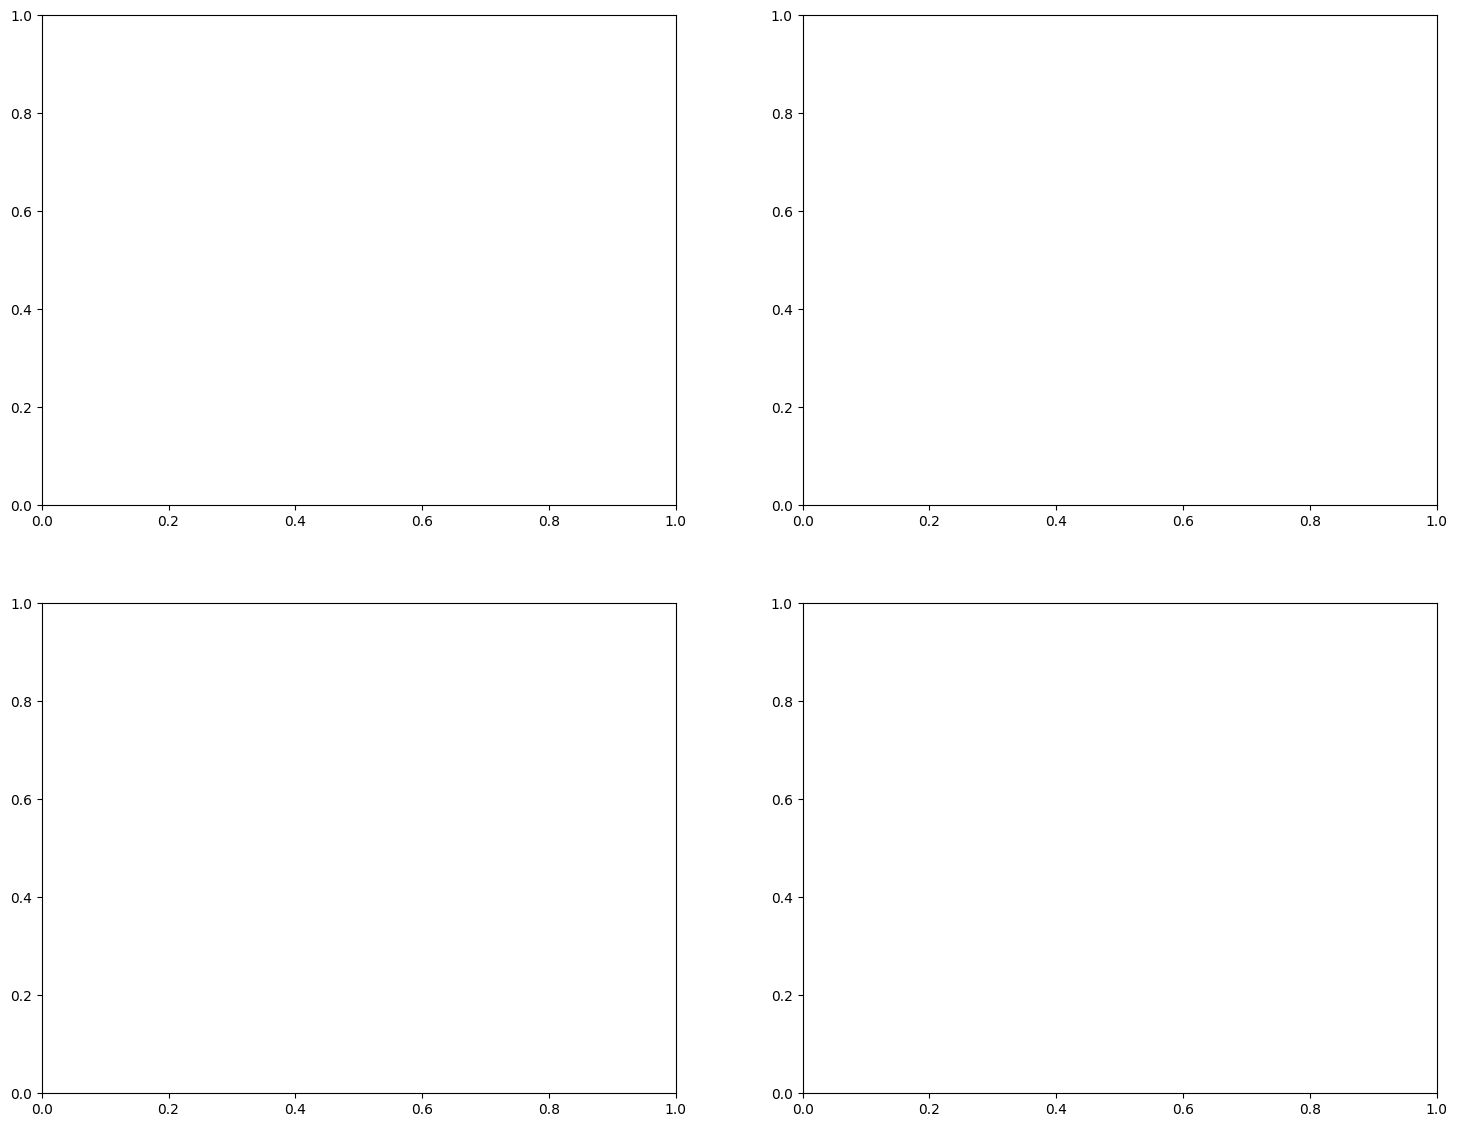

In [ ]:
"""
Visualización y Comparación de Resultados
RF vs SVM - Sleep Stage Classification

Este script carga los resultados guardados de Random Forest y SVM
y genera visualizaciones comparativas completas.
"""


# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")

# Directorios con resultados
RF_DIR = BASE_DIR / "rf_training_results_corrected"
SVM_DIR = BASE_DIR / "svm_training_results"

# Directorio para visualizaciones comparativas
VIZ_DIR = BASE_DIR / "comparative_visualizations"
VIZ_DIR.mkdir(exist_ok=True)

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#96CEB4', 4: '#FFEAA7'}


# ===================== FUNCIONES AUXILIARES =====================

def load_results_from_file(filepath):
    """Carga resultados desde archivo pickle o txt"""
    try:
        if filepath.suffix == '.pkl':
            with open(filepath, 'rb') as f:
                return pickle.load(f)
        elif filepath.suffix == '.txt':
            # Implementar parsing de archivo txt si es necesario
            pass
    except Exception as e:
        print(f"Error cargando {filepath}: {e}")
        return None


# ===================== FUNCIONES DE VISUALIZACIÓN =====================

def plot_model_comparison_per_dataset(save_dir):
    """Compara RF vs SVM para cada dataset (EOG y ALL)"""
    
    print(f"\n📊 Generando comparación RF vs SVM por dataset...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # EOG ONLY - Métricas globales
    ax = axes[0, 0]
    metrics = ['F1-Macro', 'Kappa', 'Accuracy']
    rf_vals = [
        RESULTS_RF_EOG['test_f1_macro']['mean'],
        RESULTS_RF_EOG['test_kappa']['mean'],
        RESULTS_RF_EOG['test_acc']['mean']
    ]
    svm_vals = [
        RESULTS_SVM_EOG['test_f1_macro']['mean'],
        RESULTS_SVM_EOG['test_kappa']['mean'],
        RESULTS_SVM_EOG['test_acc']['mean']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, rf_vals, width, label='Random Forest',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, svm_vals, width, label='SVM',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('EOG Only - Métricas Globales (Test Set)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    
    # EOG ONLY - F1-Score por stage
    ax = axes[0, 1]
    stages = sorted(RESULTS_RF_EOG['test_f1_per_stage'].keys())
    rf_f1_means = [RESULTS_RF_EOG['test_f1_per_stage'][s]['mean'] for s in stages]
    rf_f1_stds = [RESULTS_RF_EOG['test_f1_per_stage'][s]['std'] for s in stages]
    svm_f1_means = [RESULTS_SVM_EOG['test_f1_per_stage'][s]['mean'] for s in stages]
    svm_f1_stds = [RESULTS_SVM_EOG['test_f1_per_stage'][s]['std'] for s in stages]
    
    x = np.arange(len(stages))
    width = 0.35
    
    ax.bar(x - width/2, rf_f1_means, width, yerr=rf_f1_stds, capsize=5,
           label='Random Forest', color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, svm_f1_means, width, yerr=svm_f1_stds, capsize=5,
           label='SVM', color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('EOG Only - F1-Score por Sleep Stage', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # ALL CHANNELS - Métricas globales
    ax = axes[1, 0]
    rf_vals_all = [
        RESULTS_RF_ALL['test_f1_macro']['mean'],
        RESULTS_RF_ALL['test_kappa']['mean'],
        RESULTS_RF_ALL['test_acc']['mean']
    ]
    svm_vals_all = [
        RESULTS_SVM_ALL['test_f1_macro']['mean'],
        RESULTS_SVM_ALL['test_kappa']['mean'],
        RESULTS_SVM_ALL['test_acc']['mean']
    ]
    
    x = np.arange(len(metrics))
    bars1 = ax.bar(x - width/2, rf_vals_all, width, label='Random Forest',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, svm_vals_all, width, label='SVM',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('ALL Channels - Métricas Globales (Test Set)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    
    # ALL CHANNELS - F1-Score por stage
    ax = axes[1, 1]
    rf_f1_means_all = [RESULTS_RF_ALL['test_f1_per_stage'][s]['mean'] for s in stages]
    rf_f1_stds_all = [RESULTS_RF_ALL['test_f1_per_stage'][s]['std'] for s in stages]
    svm_f1_means_all = [RESULTS_SVM_ALL['test_f1_per_stage'][s]['mean'] for s in stages]
    svm_f1_stds_all = [RESULTS_SVM_ALL['test_f1_per_stage'][s]['std'] for s in stages]
    
    x = np.arange(len(stages))
    ax.bar(x - width/2, rf_f1_means_all, width, yerr=rf_f1_stds_all, capsize=5,
           label='Random Forest', color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, svm_f1_means_all, width, yerr=svm_f1_stds_all, capsize=5,
           label='SVM', color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('ALL Channels - F1-Score por Sleep Stage', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    plt.suptitle('Comparación Random Forest vs SVM', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = save_dir / 'rf_vs_svm_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def plot_kappa_comparison(save_dir):
    """Comparación de Cohen's Kappa por etapa"""
    
    print(f"\n📊 Generando comparación de Cohen's Kappa...")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    stages = sorted(RESULTS_RF_EOG['test_kappa_per_stage'].keys())
    x = np.arange(len(stages))
    width = 0.35
    
    # EOG Only
    ax = axes[0]
    rf_kappa_eog = [RESULTS_RF_EOG['test_kappa_per_stage'][s]['mean'] for s in stages]
    rf_kappa_eog_std = [RESULTS_RF_EOG['test_kappa_per_stage'][s]['std'] for s in stages]
    svm_kappa_eog = [RESULTS_SVM_EOG['test_kappa_per_stage'][s]['mean'] for s in stages]
    svm_kappa_eog_std = [RESULTS_SVM_EOG['test_kappa_per_stage'][s]['std'] for s in stages]
    
    ax.bar(x - width/2, rf_kappa_eog, width, yerr=rf_kappa_eog_std, capsize=5,
           label='Random Forest', color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, svm_kappa_eog, width, yerr=svm_kappa_eog_std, capsize=5,
           label='SVM', color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.axhline(y=0.6, color='orange', linestyle='--', linewidth=2, alpha=0.6, label='Substantial (0.6)')
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.6, label='Almost Perfect (0.8)')
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax.set_title("EOG Only - Cohen's Kappa por Sleep Stage", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # ALL Channels
    ax = axes[1]
    rf_kappa_all = [RESULTS_RF_ALL['test_kappa_per_stage'][s]['mean'] for s in stages]
    rf_kappa_all_std = [RESULTS_RF_ALL['test_kappa_per_stage'][s]['std'] for s in stages]
    svm_kappa_all = [RESULTS_SVM_ALL['test_kappa_per_stage'][s]['mean'] for s in stages]
    svm_kappa_all_std = [RESULTS_SVM_ALL['test_kappa_per_stage'][s]['std'] for s in stages]
    
    ax.bar(x - width/2, rf_kappa_all, width, yerr=rf_kappa_all_std, capsize=5,
           label='Random Forest', color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, svm_kappa_all, width, yerr=svm_kappa_all_std, capsize=5,
           label='SVM', color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.axhline(y=0.6, color='orange', linestyle='--', linewidth=2, alpha=0.6, label='Substantial (0.6)')
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.6, label='Almost Perfect (0.8)')
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax.set_title("ALL Channels - Cohen's Kappa por Sleep Stage", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    save_path = save_dir / 'kappa_comparison_rf_vs_svm.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def plot_dataset_comparison(save_dir):
    """Compara EOG vs ALL para cada modelo"""
    
    print(f"\n📊 Generando comparación EOG vs ALL por modelo...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    metrics = ['F1-Macro', 'Kappa', 'Accuracy']
    
    # RANDOM FOREST - Métricas globales
    ax = axes[0, 0]
    eog_vals = [
        RESULTS_RF_EOG['test_f1_macro']['mean'],
        RESULTS_RF_EOG['test_kappa']['mean'],
        RESULTS_RF_EOG['test_acc']['mean']
    ]
    all_vals = [
        RESULTS_RF_ALL['test_f1_macro']['mean'],
        RESULTS_RF_ALL['test_kappa']['mean'],
        RESULTS_RF_ALL['test_acc']['mean']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, eog_vals, width, label='EOG Only',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, all_vals, width, label='ALL Channels',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Random Forest - Métricas Globales', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    
    # RANDOM FOREST - F1-Score por stage
    ax = axes[0, 1]
    stages = sorted(RESULTS_RF_EOG['test_f1_per_stage'].keys())
    eog_f1 = [RESULTS_RF_EOG['test_f1_per_stage'][s]['mean'] for s in stages]
    all_f1 = [RESULTS_RF_ALL['test_f1_per_stage'][s]['mean'] for s in stages]
    
    x = np.arange(len(stages))
    width = 0.35
    
    ax.bar(x - width/2, eog_f1, width, label='EOG Only',
           color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, all_f1, width, label='ALL Channels',
           color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Random Forest - F1-Score por Stage', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # SVM - Métricas globales
    ax = axes[1, 0]
    eog_vals_svm = [
        RESULTS_SVM_EOG['test_f1_macro']['mean'],
        RESULTS_SVM_EOG['test_kappa']['mean'],
        RESULTS_SVM_EOG['test_acc']['mean']
    ]
    all_vals_svm = [
        RESULTS_SVM_ALL['test_f1_macro']['mean'],
        RESULTS_SVM_ALL['test_kappa']['mean'],
        RESULTS_SVM_ALL['test_acc']['mean']
    ]
    
    x = np.arange(len(metrics))
    bars1 = ax.bar(x - width/2, eog_vals_svm, width, label='EOG Only',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, all_vals_svm, width, label='ALL Channels',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('SVM - Métricas Globales', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    
    # SVM - F1-Score por stage
    ax = axes[1, 1]
    eog_f1_svm = [RESULTS_SVM_EOG['test_f1_per_stage'][s]['mean'] for s in stages]
    all_f1_svm = [RESULTS_SVM_ALL['test_f1_per_stage'][s]['mean'] for s in stages]
    
    x = np.arange(len(stages))
    ax.bar(x - width/2, eog_f1_svm, width, label='EOG Only',
           color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.bar(x + width/2, all_f1_svm, width, label='ALL Channels',
           color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('SVM - F1-Score por Stage', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    plt.suptitle('Comparación EOG Only vs ALL Channels', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = save_dir / 'eog_vs_all_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def plot_overall_summary(save_dir):
    """Resumen general con heatmaps"""
    
    print(f"\n📊 Generando resumen general...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Heatmap de F1-Score
    ax = axes[0, 0]
    data_f1 = [
        [RESULTS_RF_EOG['test_f1_macro']['mean'], RESULTS_RF_ALL['test_f1_macro']['mean']],
        [RESULTS_SVM_EOG['test_f1_macro']['mean'], RESULTS_SVM_ALL['test_f1_macro']['mean']]
    ]
    
    sns.heatmap(data_f1, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.5, vmax=0.9,
                xticklabels=['EOG Only', 'ALL Channels'],
                yticklabels=['Random Forest', 'SVM'],
                cbar_kws={'label': 'F1-Score (Macro)'},
                ax=ax, linewidths=2, linecolor='black')
    ax.set_title('F1-Score (Macro) - Heatmap', fontsize=14, fontweight='bold')
    
    # Heatmap de Cohen's Kappa
    ax = axes[0, 1]
    data_kappa = [
        [RESULTS_RF_EOG['test_kappa']['mean'], RESULTS_RF_ALL['test_kappa']['mean']],
        [RESULTS_SVM_EOG['test_kappa']['mean'], RESULTS_SVM_ALL['test_kappa']['mean']]
    ]
    
    sns.heatmap(data_kappa, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.5, vmax=0.9,
                xticklabels=['EOG Only', 'ALL Channels'],
                yticklabels=['Random Forest', 'SVM'],
                cbar_kws={'label': "Cohen's Kappa"},
                ax=ax, linewidths=2, linecolor='black')
    ax.set_title("Cohen's Kappa - Heatmap", fontsize=14, fontweight='bold')
    
    # Heatmap de Accuracy
    ax = axes[1, 0]
    data_acc = [
        [RESULTS_RF_EOG['test_acc']['mean'], RESULTS_RF_ALL['test_acc']['mean']],
        [RESULTS_SVM_EOG['test_acc']['mean'], RESULTS_SVM_ALL['test_acc']['mean']]
    ]
    
    sns.heatmap(data_acc, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.5, vmax=0.9,
                xticklabels=['EOG Only', 'ALL Channels'],
                yticklabels=['Random Forest', 'SVM'],
                cbar_kws={'label': 'Accuracy'},
                ax=ax, linewidths=2, linecolor='black')
    ax.set_title('Accuracy - Heatmap', fontsize=14, fontweight='bold')
    
    # Resumen comparativo en barras
    ax = axes[1, 1]
    categories = ['F1-Macro', 'Kappa', 'Accuracy']
    
    rf_eog_vals = [RESULTS_RF_EOG['test_f1_macro']['mean'],
                   RESULTS_RF_EOG['test_kappa']['mean'],
                   RESULTS_RF_EOG['test_acc']['mean']]
    rf_all_vals = [RESULTS_RF_ALL['test_f1_macro']['mean'],
                   RESULTS_RF_ALL['test_kappa']['mean'],
                   RESULTS_RF_ALL['test_acc']['mean']]
    svm_eog_vals = [RESULTS_SVM_EOG['test_f1_macro']['mean'],
                    RESULTS_SVM_EOG['test_kappa']['mean'],
                    RESULTS_SVM_EOG['test_acc']['mean']]
    svm_all_vals = [RESULTS_SVM_ALL['test_f1_macro']['mean'],
                    RESULTS_SVM_ALL['test_kappa']['mean'],
                    RESULTS_SVM_ALL['test_acc']['mean']]
    
    x = np.arange(len(categories))
    width = 0.2
    
    ax.bar(x - 1.5*width, rf_eog_vals, width, label='RF EOG', color='#FF6B6B', alpha=0.8)
    ax.bar(x - 0.5*width, rf_all_vals, width, label='RF ALL', color='#FF6B6B', alpha=0.5)
    ax.bar(x + 0.5*width, svm_eog_vals, width, label='SVM EOG', color='#4ECDC4', alpha=0.8)
    ax.bar(x + 1.5*width, svm_all_vals, width, label='SVM ALL', color='#4ECDC4', alpha=0.5)
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Resumen Comparativo - Todas las Configuraciones', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=11)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])
    
    plt.suptitle('Resumen General - RF vs SVM (EOG vs ALL)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = save_dir / 'overall_summary.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def plot_improvement_analysis(save_dir):
    """Análisis de mejoras: cuánto mejora ALL vs EOG"""
    
    print(f"\n📊 Generando análisis de mejoras...")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Mejora porcentual en métricas globales
    ax = axes[0]
    metrics = ['F1-Macro', 'Kappa', 'Accuracy']
    
    rf_improvements = [
        (RESULTS_RF_ALL['test_f1_macro']['mean'] - RESULTS_RF_EOG['test_f1_macro']['mean']) / RESULTS_RF_EOG['test_f1_macro']['mean'] * 100,
        (RESULTS_RF_ALL['test_kappa']['mean'] - RESULTS_RF_EOG['test_kappa']['mean']) / RESULTS_RF_EOG['test_kappa']['mean'] * 100,
        (RESULTS_RF_ALL['test_acc']['mean'] - RESULTS_RF_EOG['test_acc']['mean']) / RESULTS_RF_EOG['test_acc']['mean'] * 100
    ]
    
    svm_improvements = [
        (RESULTS_SVM_ALL['test_f1_macro']['mean'] - RESULTS_SVM_EOG['test_f1_macro']['mean']) / RESULTS_SVM_EOG['test_f1_macro']['mean'] * 100,
        (RESULTS_SVM_ALL['test_kappa']['mean'] - RESULTS_SVM_EOG['test_kappa']['mean']) / RESULTS_SVM_EOG['test_kappa']['mean'] * 100,
        (RESULTS_SVM_ALL['test_acc']['mean'] - RESULTS_SVM_EOG['test_acc']['mean']) / RESULTS_SVM_EOG['test_acc']['mean'] * 100
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, rf_improvements, width, label='Random Forest',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, svm_improvements, width, label='SVM',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Mejora Porcentual (%)', fontsize=12, fontweight='bold')
    ax.set_title('Mejora de ALL Channels vs EOG Only', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5 if height > 0 else height - 0.5,
                   f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                   fontsize=10, fontweight='bold')
    
    # Mejora por Sleep Stage (F1-Score)
    ax = axes[1]
    stages = sorted(RESULTS_RF_EOG['test_f1_per_stage'].keys())
    
    rf_stage_improvements = []
    svm_stage_improvements = []
    
    for stage in stages:
        rf_imp = (RESULTS_RF_ALL['test_f1_per_stage'][stage]['mean'] - 
                  RESULTS_RF_EOG['test_f1_per_stage'][stage]['mean']) / \
                 RESULTS_RF_EOG['test_f1_per_stage'][stage]['mean'] * 100
        
        svm_imp = (RESULTS_SVM_ALL['test_f1_per_stage'][stage]['mean'] - 
                   RESULTS_SVM_EOG['test_f1_per_stage'][stage]['mean']) / \
                  RESULTS_SVM_EOG['test_f1_per_stage'][stage]['mean'] * 100
        
        rf_stage_improvements.append(rf_imp)
        svm_stage_improvements.append(svm_imp)
    
    x = np.arange(len(stages))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, rf_stage_improvements, width, label='Random Forest',
                   color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, svm_stage_improvements, width, label='SVM',
                   color='#4ECDC4', alpha=0.85, edgecolor='black', linewidth=1.5)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mejora Porcentual F1-Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Mejora por Sleep Stage (ALL vs EOG)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([STAGE_NAMES[s] for s in stages], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5 if height > 0 else height - 0.5,
                   f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                   fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    save_path = save_dir / 'improvement_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def create_results_table(save_dir):
    """Crea una tabla resumen en formato CSV y visualización"""
    
    print(f"\n📊 Generando tabla de resultados...")
    
    # Crear DataFrame con resultados
    data = {
        'Model': ['RF', 'RF', 'SVM', 'SVM'],
        'Dataset': ['EOG', 'ALL', 'EOG', 'ALL'],
        'F1-Macro': [
            f"{RESULTS_RF_EOG['test_f1_macro']['mean']:.4f} ± {RESULTS_RF_EOG['test_f1_macro']['std']:.4f}",
            f"{RESULTS_RF_ALL['test_f1_macro']['mean']:.4f} ± {RESULTS_RF_ALL['test_f1_macro']['std']:.4f}",
            f"{RESULTS_SVM_EOG['test_f1_macro']['mean']:.4f} ± {RESULTS_SVM_EOG['test_f1_macro']['std']:.4f}",
            f"{RESULTS_SVM_ALL['test_f1_macro']['mean']:.4f} ± {RESULTS_SVM_ALL['test_f1_macro']['std']:.4f}"
        ],
        'Kappa': [
            f"{RESULTS_RF_EOG['test_kappa']['mean']:.4f} ± {RESULTS_RF_EOG['test_kappa']['std']:.4f}",
            f"{RESULTS_RF_ALL['test_kappa']['mean']:.4f} ± {RESULTS_RF_ALL['test_kappa']['std']:.4f}",
            f"{RESULTS_SVM_EOG['test_kappa']['mean']:.4f} ± {RESULTS_SVM_EOG['test_kappa']['std']:.4f}",
            f"{RESULTS_SVM_ALL['test_kappa']['mean']:.4f} ± {RESULTS_SVM_ALL['test_kappa']['std']:.4f}"
        ],
        'Accuracy': [
            f"{RESULTS_RF_EOG['test_acc']['mean']:.4f} ± {RESULTS_RF_EOG['test_acc']['std']:.4f}",
            f"{RESULTS_RF_ALL['test_acc']['mean']:.4f} ± {RESULTS_RF_ALL['test_acc']['std']:.4f}",
            f"{RESULTS_SVM_EOG['test_acc']['mean']:.4f} ± {RESULTS_SVM_EOG['test_acc']['std']:.4f}",
            f"{RESULTS_SVM_ALL['test_acc']['mean']:.4f} ± {RESULTS_SVM_ALL['test_acc']['std']:.4f}"
        ]
    }
    
    df = pd.DataFrame(data)
    
    # Guardar como CSV
    csv_path = save_dir / 'results_summary.csv'
    df.to_csv(csv_path, index=False)
    print(f"  ✓ Guardado: {csv_path.name}")
    
    # Crear tabla visual
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df.values, colLabels=df.columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.15, 0.15, 0.25, 0.25, 0.20])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Estilo del header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4ECDC4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Colorear filas alternadas
    for i in range(1, len(df) + 1):
        for j in range(len(df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    plt.title('Resumen de Resultados - RF vs SVM', 
             fontsize=16, fontweight='bold', pad=20)
    
    save_path = save_dir / 'results_table.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {save_path.name}")
    plt.close()


def generate_all_visualizations():
    """Genera todas las visualizaciones"""
    
    print("\n" + "="*70)
    print("GENERANDO VISUALIZACIONES COMPARATIVAS RF vs SVM")
    print("="*70)
    
    # Generar todas las visualizaciones
    plot_model_comparison_per_dataset(VIZ_DIR)
    plot_kappa_comparison(VIZ_DIR)
    plot_dataset_comparison(VIZ_DIR)
    plot_overall_summary(VIZ_DIR)
    plot_improvement_analysis(VIZ_DIR)
    create_results_table(VIZ_DIR)
    
    print("\n" + "="*70)
    print("✅ TODAS LAS VISUALIZACIONES GENERADAS EXITOSAMENTE")
    print(f"📁 Guardadas en: {VIZ_DIR}")
    print("="*70)
    
    # Listar archivos generados
    print("\n📊 Archivos generados:")
    for file in sorted(VIZ_DIR.glob("*.png")):
        print(f"  • {file.name}")
    for file in sorted(VIZ_DIR.glob("*.csv")):
        print(f"  • {file.name}")


# ===================== EJECUCIÓN PRINCIPAL =====================

if __name__ == "__main__":
    generate_all_visualizations()

In [ ]:
"""
Generación de Tablas Comparativas
RF vs SVM - Sleep Stage Classification
"""

# ===================== CONFIGURACIÓN =====================

BASE_DIR = Path(r"C:\Users\Alfredo Sempertegui\Documents\Proyecto IC\sleep_edf")
VIZ_DIR = BASE_DIR / "comparative_visualizations"
VIZ_DIR.mkdir(exist_ok=True)

STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

# ===================== FUNCIONES =====================

def create_general_metrics_table(model_name, results_eog, results_all):
    """Crea tabla de métricas generales para un modelo"""
    
    data = {
        'Métrica': ['F1-Score (Macro)', "Cohen's Kappa", 'Accuracy'],
        'EOG Only': [
            f"{results_eog['test_f1_macro']['mean']:.4f} ± {results_eog['test_f1_macro']['std']:.4f}",
            f"{results_eog['test_kappa']['mean']:.4f} ± {results_eog['test_kappa']['std']:.4f}",
            f"{results_eog['test_acc']['mean']:.4f} ± {results_eog['test_acc']['std']:.4f}"
        ],
        'ALL Channels': [
            f"{results_all['test_f1_macro']['mean']:.4f} ± {results_all['test_f1_macro']['std']:.4f}",
            f"{results_all['test_kappa']['mean']:.4f} ± {results_all['test_kappa']['std']:.4f}",
            f"{results_all['test_acc']['mean']:.4f} ± {results_all['test_acc']['std']:.4f}"
        ],
        'Δ (%)': [
            f"{((results_all['test_f1_macro']['mean'] - results_eog['test_f1_macro']['mean']) / results_eog['test_f1_macro']['mean'] * 100):.2f}%",
            f"{((results_all['test_kappa']['mean'] - results_eog['test_kappa']['mean']) / results_eog['test_kappa']['mean'] * 100):.2f}%",
            f"{((results_all['test_acc']['mean'] - results_eog['test_acc']['mean']) / results_eog['test_acc']['mean'] * 100):.2f}%"
        ]
    }
    
    df = pd.DataFrame(data)
    return df


def create_stage_metrics_table(model_name, results_eog, results_all):
    """Crea tabla de métricas por etapa para un modelo"""
    
    stages = sorted(results_eog['test_f1_per_stage'].keys())
    
    data = {
        'Stage': [STAGE_NAMES[s] for s in stages],
        'F1 (EOG)': [
            f"{results_eog['test_f1_per_stage'][s]['mean']:.4f} ± {results_eog['test_f1_per_stage'][s]['std']:.4f}"
            for s in stages
        ],
        'F1 (ALL)': [
            f"{results_all['test_f1_per_stage'][s]['mean']:.4f} ± {results_all['test_f1_per_stage'][s]['std']:.4f}"
            for s in stages
        ],
        'Kappa (EOG)': [
            f"{results_eog['test_kappa_per_stage'][s]['mean']:.4f} ± {results_eog['test_kappa_per_stage'][s]['std']:.4f}"
            for s in stages
        ],
        'Kappa (ALL)': [
            f"{results_all['test_kappa_per_stage'][s]['mean']:.4f} ± {results_all['test_kappa_per_stage'][s]['std']:.4f}"
            for s in stages
        ]
    }
    
    df = pd.DataFrame(data)
    return df


def save_table_as_image(df, title, filename, save_dir):
    """Guarda un DataFrame como imagen"""
    
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.6 + 1.5))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df.values, colLabels=df.columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.2] * len(df.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    # Estilo del header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4ECDC4')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=11)
    
    # Colorear filas alternadas
    for i in range(1, len(df) + 1):
        for j in range(len(df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    save_path = save_dir / filename
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Guardado: {filename}")
    plt.close()


def generate_all_tables():
    """Genera las 4 tablas solicitadas"""
    
    print("\n" + "="*70)
    print("GENERANDO TABLAS COMPARATIVAS")
    print("="*70)
    
    # TABLA 1: Métricas generales RF
    print("\n📊 Tabla 1: Métricas Generales - Random Forest")
    df1 = create_general_metrics_table('Random Forest', RESULTS_RF_EOG, RESULTS_RF_ALL)
    print(df1.to_string(index=False))
    df1.to_csv(VIZ_DIR / 'tabla1_rf_general.csv', index=False)
    save_table_as_image(df1, 'Random Forest - Métricas Generales (EOG vs ALL)', 
                        'tabla1_rf_general.png', VIZ_DIR)
    
    # TABLA 2: Métricas por etapa RF
    print("\n📊 Tabla 2: Métricas por Etapa - Random Forest")
    df2 = create_stage_metrics_table('Random Forest', RESULTS_RF_EOG, RESULTS_RF_ALL)
    print(df2.to_string(index=False))
    df2.to_csv(VIZ_DIR / 'tabla2_rf_stages.csv', index=False)
    save_table_as_image(df2, 'Random Forest - Métricas por Sleep Stage (EOG vs ALL)', 
                        'tabla2_rf_stages.png', VIZ_DIR)
    
    # TABLA 3: Métricas generales SVM
    print("\n📊 Tabla 3: Métricas Generales - SVM")
    df3 = create_general_metrics_table('SVM', RESULTS_SVM_EOG, RESULTS_SVM_ALL)
    print(df3.to_string(index=False))
    df3.to_csv(VIZ_DIR / 'tabla3_svm_general.csv', index=False)
    save_table_as_image(df3, 'SVM - Métricas Generales (EOG vs ALL)', 
                        'tabla3_svm_general.png', VIZ_DIR)
    
    # TABLA 4: Métricas por etapa SVM
    print("\n📊 Tabla 4: Métricas por Etapa - SVM")
    df4 = create_stage_metrics_table('SVM', RESULTS_SVM_EOG, RESULTS_SVM_ALL)
    print(df4.to_string(index=False))
    df4.to_csv(VIZ_DIR / 'tabla4_svm_stages.csv', index=False)
    save_table_as_image(df4, 'SVM - Métricas por Sleep Stage (EOG vs ALL)', 
                        'tabla4_svm_stages.png', VIZ_DIR)
    
    print("\n" + "="*70)
    print("✅ TODAS LAS TABLAS GENERADAS EXITOSAMENTE")
    print(f"📁 Guardadas en: {VIZ_DIR}")
    print("="*70)
    
    print("\n📄 Archivos generados:")
    print("  CSV:")
    for file in sorted(VIZ_DIR.glob("tabla*.csv")):
        print(f"    • {file.name}")
    print("  PNG:")
    for file in sorted(VIZ_DIR.glob("tabla*.png")):
        print(f"    • {file.name}")


# ===================== EJECUCIÓN =====================

if __name__ == "__main__":
    generate_all_tables()


GENERANDO TABLAS COMPARATIVAS

📊 Tabla 1: Métricas Generales - Random Forest
         Métrica        EOG Only    ALL Channels   Δ (%)
F1-Score (Macro) 0.6522 ± 0.0147 0.5579 ± 0.0086 -14.46%
   Cohen's Kappa 0.5817 ± 0.0221 0.4872 ± 0.0153 -16.25%
        Accuracy 0.6877 ± 0.0175 0.6138 ± 0.0129 -10.75%
  ✓ Guardado: tabla1_rf_general.png

📊 Tabla 2: Métricas por Etapa - Random Forest
Stage        F1 (EOG)        F1 (ALL)     Kappa (EOG)     Kappa (ALL)
 Wake 0.7858 ± 0.0354 0.7876 ± 0.0256 0.7075 ± 0.0386 0.7077 ± 0.0276
   N1 0.3837 ± 0.0121 0.3176 ± 0.0059 0.2814 ± 0.0156 0.2068 ± 0.0077
   N2 0.7379 ± 0.0257 0.6809 ± 0.0200 0.5889 ± 0.0348 0.5123 ± 0.0200
   N3 0.6716 ± 0.0438 0.5617 ± 0.0367 0.6444 ± 0.0467 0.5220 ± 0.0404
  REM 0.6820 ± 0.0191 0.4415 ± 0.0186 0.6289 ± 0.0227 0.3436 ± 0.0185
  ✓ Guardado: tabla2_rf_stages.png

📊 Tabla 3: Métricas Generales - SVM
         Métrica        EOG Only    ALL Channels   Δ (%)
F1-Score (Macro) 0.6441 ± 0.0213 0.5205 ± 0.0190 -19.19%
   Co